In [1]:
#import modules

import numpy as np
import os
import matplotlib.pyplot as plt
import pickle

from keras import layers
from keras import models
from keras import optimizers
from keras.preprocessing import image_dataset_from_directory
from keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import EarlyStopping, ModelCheckpoint
from keras.regularizers import l2
from keras.utils import to_categorical
from keras.utils import multi_gpu_model
from keras.utils import Sequence
from keras.models import load_model
from tensorflow.distribute import MirroredStrategy

In [2]:
#initialise random generator
rng = np.random.default_rng()

In [3]:
#Define FelixDataflow classes and functions.

class FelixSequence(Sequence):
    def __init__(self, x_set, y_set, batch_size, file_type, use_index):
        """Here self.x is a list of paths to file_type files. self.y is a
        corresponding list of labels."""
        self.x, self.y = x_set, y_set
        self.batch_size = batch_size
        self.file_type = file_type
        self.use_index = use_index

    def __len__(self):
        return int(np.ceil(len(self.x) / float(self.batch_size)))

    def __getitem__(self, idx):
        batch_x = self.x[idx * self.batch_size:(idx + 1) * self.batch_size]
        batch_y = self.y[idx * self.batch_size:(idx + 1) * self.batch_size]
        return arrs_from_paths(batch_x, self.file_type, self.use_index), to_categorical(np.array(batch_y),10)

def gen_paths_labels(base_path):
    """A generator to yield (data-paths, corresponding labels) tuples for each
    segment of data (typically training, validation, and testing)."""
    for segment in sorted(os.listdir(base_path)):
        segment_path = os.path.join(base_path, segment)
        segment_paths = []
        segment_labels = []
        for label in os.listdir(segment_path):
            label_path = os.path.join(segment_path, label)
            for crystal in os.listdir(label_path):
                segment_paths.append(os.path.join(label_path, crystal))
                segment_labels.append(label)
        indexes = np.arange(len(segment_labels))
        rng.shuffle(indexes)
        yield [np.array(segment_paths)[indexes], np.array(list(map(int,segment_labels)))[indexes]]

def arrs_from_paths(paths, file_type, use_index):
    if file_type == "txt":
        return np.array([np.loadtxt(file_name) for file_name in paths])
    elif file_type == "npy":
        return np.array([np.load(file_name)[use_index,:,:] for file_name in paths])
        #return np.array([np.load(file_name) for file_name in paths])

  

In [4]:
def felix_fit_new(model, batch_size, epochs, workers, callbacks, AllPaths, file_type, train_history, val_history, patience, test_history, Monitor, use_index):
    #AllPaths = [[TrainingPaths, TrainingThickness], [], []]
    """A fit function to allow validation and test data to be supplied via a
    generator."""
    
    best_val_loss = np.inf
    best_val_acc = 0
    
    x = np.arange(0, epochs)
    
    train_seq = FelixSequence(AllPaths[0][0], AllPaths[0][1], batch_size, file_type, use_index)
    val_seq = FelixSequence(AllPaths[1][0], AllPaths[1][1], batch_size, file_type, use_index)
    test_seq = FelixSequence(AllPaths[2][0], AllPaths[2][1], batch_size, file_type, use_index)
    for epoch in range(epochs):
        print("-------------------------------------------------------------------------")
        print("Epoch", epoch+1, "/", epochs, ": ")
        print("Training: ")
        train_hist = model.fit(x = train_seq, epochs = epoch+1, workers = workers, initial_epoch = epoch, shuffle=True)
        train_history[0][epoch] = train_hist.history["loss"][0]
        train_history[1][epoch] = train_hist.history["acc"][0]
        print("Validation: ")
        val_hist = model.evaluate(x = val_seq, workers = workers, callbacks = callbacks)
        #print(val_hist)
        val_history[0][epoch] = val_hist[0]
        val_history[1][epoch] = val_hist[1]
        
        plt.plot(x, val_history[1])
        plt.show()
        
        epoch_loss = val_hist[0]
        epoch_acc = val_hist[1]
        
        
        if(Monitor == "loss"):
            if(epoch_loss < best_val_loss):
                print("The model loss improved from: ",best_val_loss, "to: ", epoch_loss)
                best_val_loss = epoch_loss
                patience_i = 0
            else:
                patience_i+=1
                print("The model did not improve, patience_i = ", patience_i)

            #val_hist[0][epoch] = avg_recon_loss
            if(patience_i > patience):
                print("Early Stopping, the model did not improve from a loss: ", best_val_loss)
                break
        
        elif(Monitor == "acc"):
            if(best_val_acc < epoch_acc):
                print("The model accuracy improved from: ",best_val_acc, "to: ", epoch_acc)
                best_val_acc = epoch_acc
                patience_i = 0
            else:
                patience_i+=1
                print("The model accuracy did not improve, patience_i = ", patience_i)

            #val_hist[0][epoch] = avg_recon_loss
            if(patience_i > patience):
                print("Early Stopping, the model did not improve from an accuracy: ", best_val_loss)
                break

    print("-------------------------------------------------------------------------")
    print("Testing: ")
    tst_hist = model.evaluate(test_seq)
    test_history[0] = tst_hist[0]
    test_history[1] = tst_hist[1]
    print("Test Results: ", tst_hist[0], tst_hist[1])
    return(tst_hist[0], tst_hist[1])



In [11]:
#All paths

SaveDataPath = "/home/ug-ml/Documents/GitHub_BigFiles/SaveFolder" #Base directory of place you store information of models
SaveFolderName = "/Classifer_1_V3" #Will create a folder and put in information about the outcome / inputs
ModelName = "/Model.hdf5"


#Many variables

#Model Variables


#Hyper parameters
learning_rate = 0.0005
l2_regularizer = 0.0001
loss = 'categorical_crossentropy'
optimizer = "RMSprop" #Not a variable ONLY used for a note
batch_size = 32
epochs = 30
ShuffleTrainData = True

#Call back variables
TrainingPatience = 10
CheckPointMonitor = 'val_acc'
EarlyStopMonitor = 'val_acc'

#CPU variables
CPUworkers = 16


In [12]:
#Early stopping and check points

EarlyStop = EarlyStopping(monitor = EarlyStopMonitor,
                          mode = 'min',
                          verbose = 1,
                          patience = TrainingPatience)

NewPath = SaveDataPath + SaveFolderName
Checkpoint = ModelCheckpoint(NewPath + ModelName, #Save path
                             monitor = CheckPointMonitor,
                             verbose = 1,
                             save_best_only = True,
                             mode = 'auto',
                             save_freq = 'epoch')



In [13]:

def BuildModel(input_shape):

    model = models.Sequential()
    model.add(layers.Conv2D(48 * 3, (4, 4),
                                     activation='relu',
                                     data_format='channels_first',
                                     input_shape= input_shape))
    model.add(layers.MaxPooling2D((2, 2), data_format='channels_first'))
    model.add(layers.Conv2D(48 * 3, (4, 4),
                                     data_format='channels_first',
                                     activation='relu'))
    model.add(layers.MaxPooling2D((2, 2), data_format='channels_first'))
    model.add(layers.Conv2D(48 * 3, (4, 4),
                                     data_format='channels_first',
                                     activation='relu'))
    model.add(layers.MaxPooling2D((2, 2), data_format='channels_first'))
    model.add(layers.Flatten())
    model.add(layers.Dropout(0.2))
    model.add(layers.Dense(48 * 3, activation='relu',
                           kernel_regularizer = l2(0.0001)))

    model.add(layers.Dense(10, activation='softmax',
                           kernel_regularizer = l2(0.0001)))

    model.compile(loss = 'categorical_crossentropy',
                  optimizer = optimizers.RMSprop(learning_rate = 0.0005),
                  metrics=['acc'])
    return model

In [14]:
def MakeThicknessList(ListPaths):
    Thickness = []
    for i in ListPaths:
        Thickness.append(int(i.split("/")[-1].split(".")[0]))
    Thickness = np.array(Thickness)
    return(Thickness)

def OpenTxt(Path):
    with open(Path) as textFile:
        lines = [line.split() for line in textFile]
    List = []
    for i in lines:
        List.append(i[0])
    return(List)

DataPath = "/home/ug-ml/felix-ML/classification/Classification15/DataPaths/"

TrainPath = OpenTxt(DataPath + "Train_0p1.txt")
ValPath = OpenTxt(DataPath + "Validation_0p1.txt")
TestPath = OpenTxt(DataPath + "Test_0p1.txt")

TrainThickness = MakeThicknessList(TrainPath)
ValThickness = MakeThicknessList(ValPath)
TestThickness = MakeThicknessList(TestPath)

AllPaths = [[TrainPath,TrainThickness],[ValPath,ValThickness],[TestPath,TestThickness]]

-------------------------------------------------------------------------
Epoch 1 / 30 : 
Training: 
1769/1769 [==============================] - 332s 188ms/step - loss: 1.7950 - acc: 0.3732
Validation: 
208/208 [==============================] - 38s 182ms/step - loss: 1.3733 - acc: 0.5145


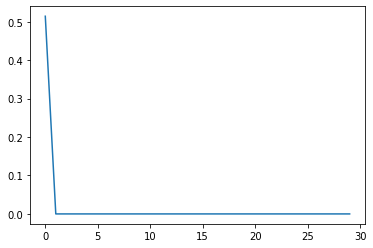

The model accuracy improved from:  0 to:  0.5145090818405151
-------------------------------------------------------------------------
Epoch 2 / 30 : 
Training: 
Epoch 2/2
1769/1769 [==============================] - 324s 183ms/step - loss: 1.3616 - acc: 0.5585
Validation: 
208/208 [==============================] - 39s 187ms/step - loss: 1.4030 - acc: 0.5327


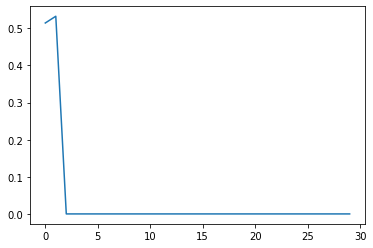

The model accuracy improved from:  0.5145090818405151 to:  0.532701849937439
-------------------------------------------------------------------------
Epoch 3 / 30 : 
Training: 
Epoch 3/3
1769/1769 [==============================] - 331s 187ms/step - loss: 1.1318 - acc: 0.6437
Validation: 
208/208 [==============================] - 37s 179ms/step - loss: 1.0685 - acc: 0.6489


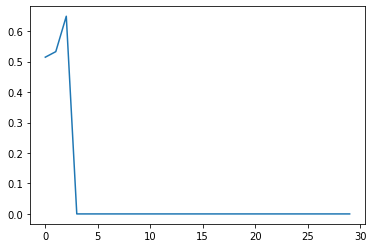

The model accuracy improved from:  0.532701849937439 to:  0.6489249467849731
-------------------------------------------------------------------------
Epoch 4 / 30 : 
Training: 
Epoch 4/4
1769/1769 [==============================] - 332s 188ms/step - loss: 1.0744 - acc: 0.7016
Validation: 
208/208 [==============================] - 38s 185ms/step - loss: 1.0071 - acc: 0.6861


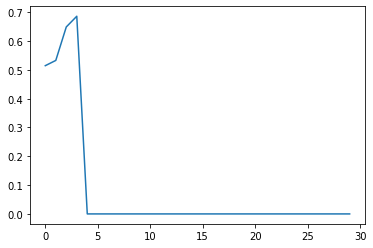

The model accuracy improved from:  0.6489249467849731 to:  0.686062216758728
-------------------------------------------------------------------------
Epoch 5 / 30 : 
Training: 
Epoch 5/5
1769/1769 [==============================] - 331s 187ms/step - loss: 0.8844 - acc: 0.7389
Validation: 
208/208 [==============================] - 39s 185ms/step - loss: 0.9701 - acc: 0.7067


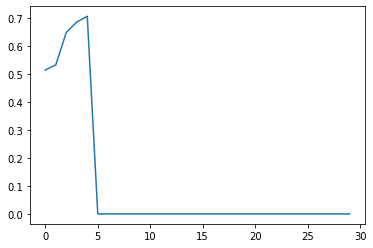

The model accuracy improved from:  0.686062216758728 to:  0.7066606283187866
-------------------------------------------------------------------------
Epoch 6 / 30 : 
Training: 
Epoch 6/6
1769/1769 [==============================] - 332s 188ms/step - loss: 0.8098 - acc: 0.7701
Validation: 
208/208 [==============================] - 38s 184ms/step - loss: 1.0294 - acc: 0.7179


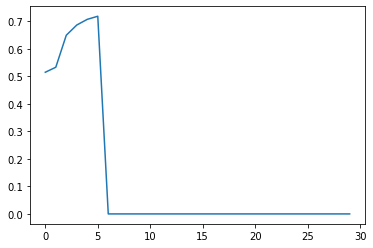

The model accuracy improved from:  0.7066606283187866 to:  0.717937171459198
-------------------------------------------------------------------------
Epoch 7 / 30 : 
Training: 
Epoch 7/7
1769/1769 [==============================] - 330s 186ms/step - loss: 0.8232 - acc: 0.7910
Validation: 
208/208 [==============================] - 38s 182ms/step - loss: 0.9743 - acc: 0.7367


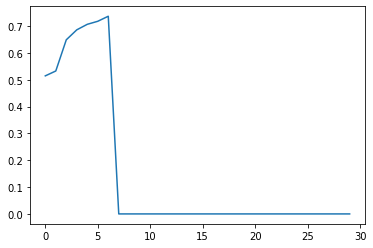

The model accuracy improved from:  0.717937171459198 to:  0.7367312908172607
-------------------------------------------------------------------------
Epoch 8 / 30 : 
Training: 
Epoch 8/8
1769/1769 [==============================] - 328s 185ms/step - loss: 0.7809 - acc: 0.8067s - loss: 0.7816 - a
Validation: 
208/208 [==============================] - 38s 181ms/step - loss: 1.1048 - acc: 0.7309


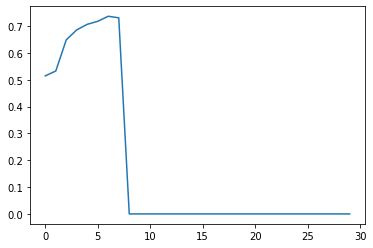

The model accuracy did not improve, patience_i =  1
-------------------------------------------------------------------------
Epoch 9 / 30 : 
Training: 
Epoch 9/9
1769/1769 [==============================] - 324s 183ms/step - loss: 0.6814 - acc: 0.8195
Validation: 
208/208 [==============================] - 37s 179ms/step - loss: 0.9568 - acc: 0.7370


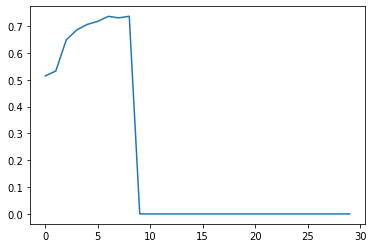

The model accuracy improved from:  0.7367312908172607 to:  0.7370319962501526
-------------------------------------------------------------------------
Epoch 10 / 30 : 
Training: 
Epoch 10/10
1769/1769 [==============================] - 356s 201ms/step - loss: 0.6511 - acc: 0.8318
Validation: 
208/208 [==============================] - 37s 177ms/step - loss: 0.9539 - acc: 0.7345


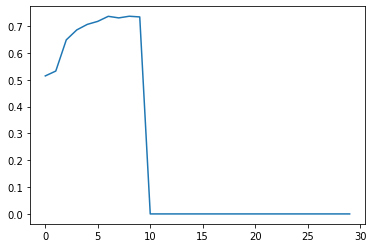

The model accuracy did not improve, patience_i =  1
-------------------------------------------------------------------------
Epoch 11 / 30 : 
Training: 
Epoch 11/11
1769/1769 [==============================] - 330s 187ms/step - loss: 0.6357 - acc: 0.8397
Validation: 
208/208 [==============================] - 38s 182ms/step - loss: 1.0189 - acc: 0.7560


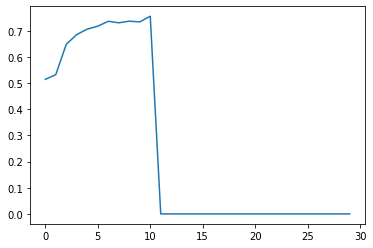

The model accuracy improved from:  0.7370319962501526 to:  0.7559765577316284
-------------------------------------------------------------------------
Epoch 12 / 30 : 
Training: 
Epoch 12/12
1769/1769 [==============================] - 327s 185ms/step - loss: 0.6657 - acc: 0.8445
Validation: 
208/208 [==============================] - 37s 180ms/step - loss: 1.0242 - acc: 0.7661


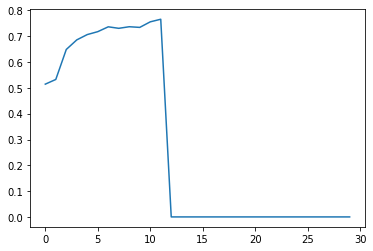

The model accuracy improved from:  0.7559765577316284 to:  0.7660502195358276
-------------------------------------------------------------------------
Epoch 13 / 30 : 
Training: 
Epoch 13/13
1769/1769 [==============================] - 328s 185ms/step - loss: 0.6379 - acc: 0.8515
Validation: 
208/208 [==============================] - 38s 181ms/step - loss: 1.0297 - acc: 0.7611


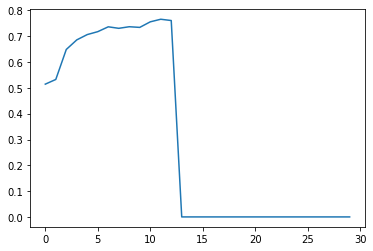

The model accuracy did not improve, patience_i =  1
-------------------------------------------------------------------------
Epoch 14 / 30 : 
Training: 
Epoch 14/14
1769/1769 [==============================] - 331s 187ms/step - loss: 0.5910 - acc: 0.8537
Validation: 
208/208 [==============================] - 37s 180ms/step - loss: 1.0410 - acc: 0.7623


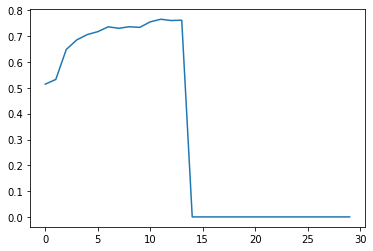

The model accuracy did not improve, patience_i =  2
-------------------------------------------------------------------------
Epoch 15 / 30 : 
Training: 
Epoch 15/15
1769/1769 [==============================] - 362s 205ms/step - loss: 0.5762 - acc: 0.8581
Validation: 
208/208 [==============================] - 37s 179ms/step - loss: 1.0171 - acc: 0.7651


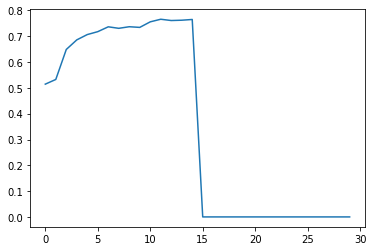

The model accuracy did not improve, patience_i =  3
-------------------------------------------------------------------------
Epoch 16 / 30 : 
Training: 
Epoch 16/16
1769/1769 [==============================] - 326s 184ms/step - loss: 0.6069 - acc: 0.8600
Validation: 
208/208 [==============================] - 37s 180ms/step - loss: 1.0725 - acc: 0.7465


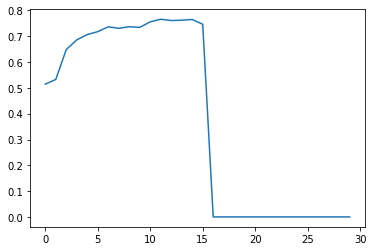

The model accuracy did not improve, patience_i =  4
-------------------------------------------------------------------------
Epoch 17 / 30 : 
Training: 
Epoch 17/17
1769/1769 [==============================] - 359s 203ms/step - loss: 0.5916 - acc: 0.8594
Validation: 
208/208 [==============================] - 38s 183ms/step - loss: 1.0523 - acc: 0.7543


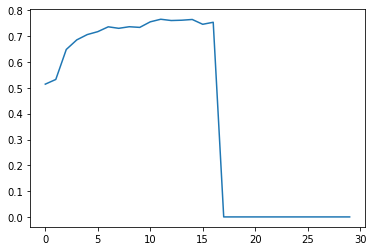

The model accuracy did not improve, patience_i =  5
-------------------------------------------------------------------------
Epoch 18 / 30 : 
Training: 
Epoch 18/18
1769/1769 [==============================] - 356s 201ms/step - loss: 0.5688 - acc: 0.8613
Validation: 
208/208 [==============================] - 68s 327ms/step - loss: 1.1534 - acc: 0.7572


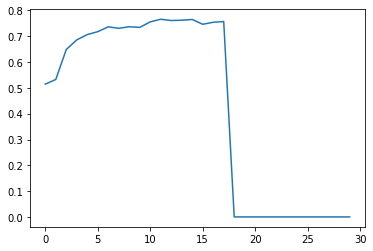

The model accuracy did not improve, patience_i =  6
-------------------------------------------------------------------------
Epoch 19 / 30 : 
Training: 
Epoch 19/19
1769/1769 [==============================] - 332s 188ms/step - loss: 0.6100 - acc: 0.8629
Validation: 
208/208 [==============================] - 38s 183ms/step - loss: 1.1579 - acc: 0.7654


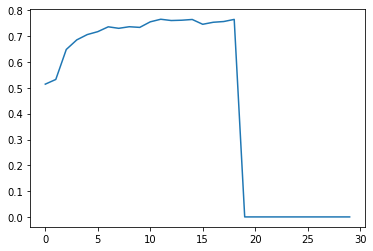

The model accuracy did not improve, patience_i =  7
-------------------------------------------------------------------------
Epoch 20 / 30 : 
Training: 
Epoch 20/20
1769/1769 [==============================] - 334s 189ms/step - loss: 0.5738 - acc: 0.8661
Validation: 
208/208 [==============================] - 38s 181ms/step - loss: 1.0796 - acc: 0.7596


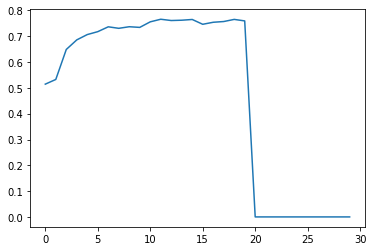

The model accuracy did not improve, patience_i =  8
-------------------------------------------------------------------------
Epoch 21 / 30 : 
Training: 
Epoch 21/21
1769/1769 [==============================] - 324s 183ms/step - loss: 0.5674 - acc: 0.8656
Validation: 
208/208 [==============================] - 36s 173ms/step - loss: 1.4017 - acc: 0.7578


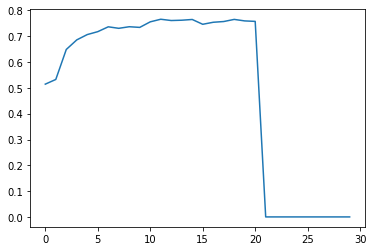

The model accuracy did not improve, patience_i =  9
-------------------------------------------------------------------------
Epoch 22 / 30 : 
Training: 
Epoch 22/22
1769/1769 [==============================] - 319s 181ms/step - loss: 0.5646 - acc: 0.8665
Validation: 
208/208 [==============================] - 36s 173ms/step - loss: 1.2750 - acc: 0.7510


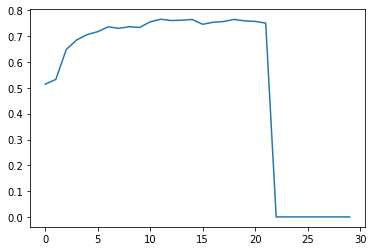

The model accuracy did not improve, patience_i =  10
-------------------------------------------------------------------------
Epoch 23 / 30 : 
Training: 
Epoch 23/23
1769/1769 [==============================] - 320s 181ms/step - loss: 0.5468 - acc: 0.8669
Validation: 
208/208 [==============================] - 37s 178ms/step - loss: 0.9671 - acc: 0.7388


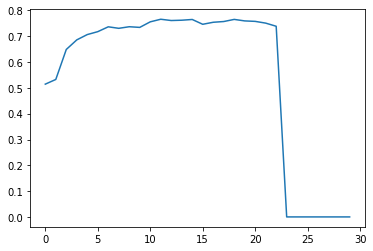

The model accuracy did not improve, patience_i =  11
Early Stopping, the model did not improve from an accuracy:  inf
-------------------------------------------------------------------------
Testing: 
105/105 [==============================] - 25s 240ms/step - loss: 0.9740 - acc: 0.7338
Test Results:  0.9739919900894165 0.7337526082992554
-------------------------------------------------------------------------
Epoch 1 / 30 : 
Training: 
1769/1769 [==============================] - 353s 199ms/step - loss: 1.7070 - acc: 0.3750
Validation: 
208/208 [==============================] - 38s 181ms/step - loss: 1.4125 - acc: 0.4885


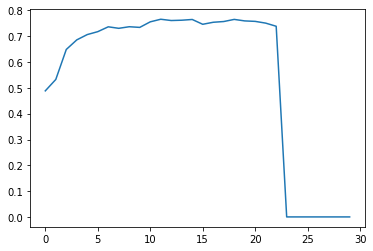

The model accuracy improved from:  0 to:  0.4884979724884033
-------------------------------------------------------------------------
Epoch 2 / 30 : 
Training: 
Epoch 2/2
1769/1769 [==============================] - 354s 200ms/step - loss: 1.3217 - acc: 0.5563
Validation: 
208/208 [==============================] - 37s 180ms/step - loss: 1.1617 - acc: 0.6071


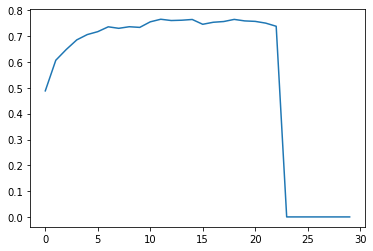

The model accuracy improved from:  0.4884979724884033 to:  0.607126772403717
-------------------------------------------------------------------------
Epoch 3 / 30 : 
Training: 
Epoch 3/3
1769/1769 [==============================] - 327s 185ms/step - loss: 1.1235 - acc: 0.6427
Validation: 
208/208 [==============================] - 38s 183ms/step - loss: 1.0524 - acc: 0.6620


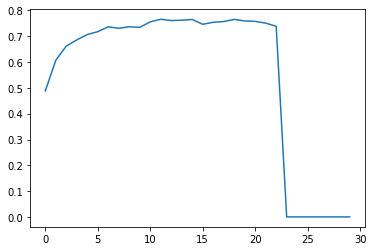

The model accuracy improved from:  0.607126772403717 to:  0.6620057225227356
-------------------------------------------------------------------------
Epoch 4 / 30 : 
Training: 
Epoch 4/4
1769/1769 [==============================] - 328s 185ms/step - loss: 0.9849 - acc: 0.7007
Validation: 
208/208 [==============================] - 36s 175ms/step - loss: 1.0228 - acc: 0.6803


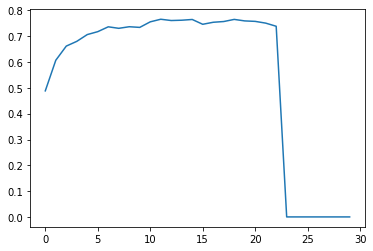

The model accuracy improved from:  0.6620057225227356 to:  0.680348813533783
-------------------------------------------------------------------------
Epoch 5 / 30 : 
Training: 
Epoch 5/5
1769/1769 [==============================] - 327s 185ms/step - loss: 0.8749 - acc: 0.7432
Validation: 
208/208 [==============================] - 38s 183ms/step - loss: 0.9774 - acc: 0.7176


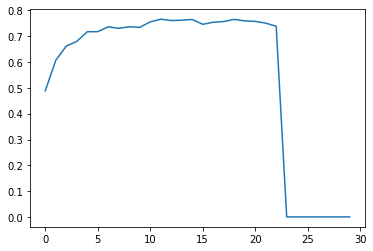

The model accuracy improved from:  0.680348813533783 to:  0.7176364660263062
-------------------------------------------------------------------------
Epoch 6 / 30 : 
Training: 
Epoch 6/6
1769/1769 [==============================] - 328s 186ms/step - loss: 0.8357 - acc: 0.7713
Validation: 
208/208 [==============================] - 37s 180ms/step - loss: 0.9850 - acc: 0.7223


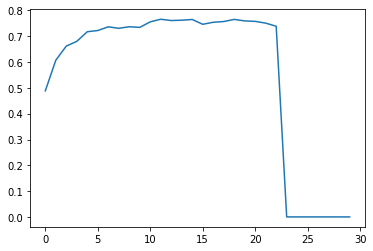

The model accuracy improved from:  0.7176364660263062 to:  0.7222973704338074
-------------------------------------------------------------------------
Epoch 7 / 30 : 
Training: 
Epoch 7/7
1769/1769 [==============================] - 327s 185ms/step - loss: 0.7677 - acc: 0.7920
Validation: 
208/208 [==============================] - 37s 177ms/step - loss: 0.9754 - acc: 0.7185


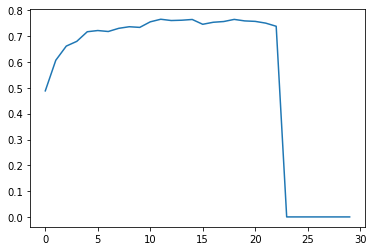

The model accuracy did not improve, patience_i =  1
-------------------------------------------------------------------------
Epoch 8 / 30 : 
Training: 
Epoch 8/8
1769/1769 [==============================] - 326s 184ms/step - loss: 0.7026 - acc: 0.8078
Validation: 
208/208 [==============================] - 37s 177ms/step - loss: 1.0354 - acc: 0.7379


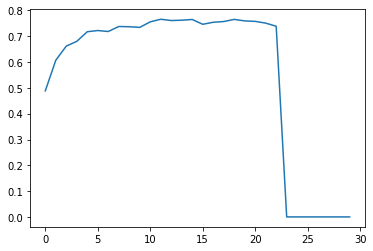

The model accuracy improved from:  0.7222973704338074 to:  0.7379341721534729
-------------------------------------------------------------------------
Epoch 9 / 30 : 
Training: 
Epoch 9/9
1769/1769 [==============================] - 328s 186ms/step - loss: 0.6658 - acc: 0.8230
Validation: 
208/208 [==============================] - 38s 182ms/step - loss: 1.0287 - acc: 0.7316


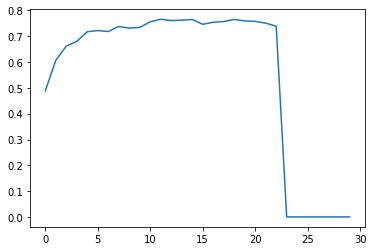

The model accuracy did not improve, patience_i =  1
-------------------------------------------------------------------------
Epoch 10 / 30 : 
Training: 
Epoch 10/10
1769/1769 [==============================] - 325s 184ms/step - loss: 0.6365 - acc: 0.8336
Validation: 
208/208 [==============================] - 38s 183ms/step - loss: 1.0026 - acc: 0.7518


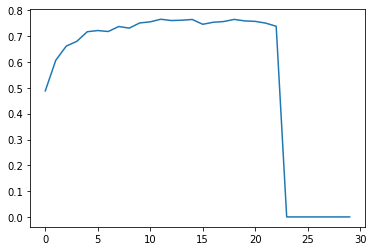

The model accuracy improved from:  0.7379341721534729 to:  0.7517666220664978
-------------------------------------------------------------------------
Epoch 11 / 30 : 
Training: 
Epoch 11/11
1769/1769 [==============================] - 325s 184ms/step - loss: 0.6227 - acc: 0.8444
Validation: 
208/208 [==============================] - 37s 180ms/step - loss: 1.0502 - acc: 0.7680


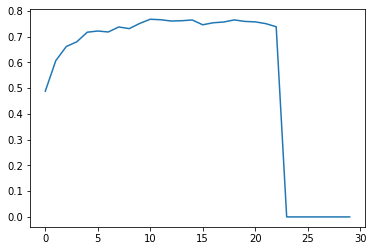

The model accuracy improved from:  0.7517666220664978 to:  0.768004834651947
-------------------------------------------------------------------------
Epoch 12 / 30 : 
Training: 
Epoch 12/12
1769/1769 [==============================] - 322s 182ms/step - loss: 0.6116 - acc: 0.8477
Validation: 
208/208 [==============================] - 37s 178ms/step - loss: 1.0570 - acc: 0.7540


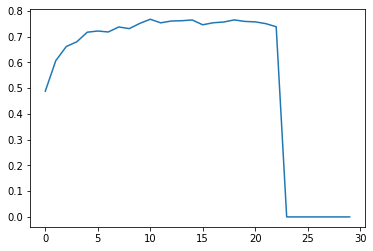

The model accuracy did not improve, patience_i =  1
-------------------------------------------------------------------------
Epoch 13 / 30 : 
Training: 
Epoch 13/13
1769/1769 [==============================] - 327s 185ms/step - loss: 0.6066 - acc: 0.8526
Validation: 
208/208 [==============================] - 37s 177ms/step - loss: 1.1784 - acc: 0.7602


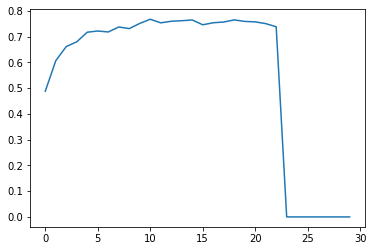

The model accuracy did not improve, patience_i =  2
-------------------------------------------------------------------------
Epoch 14 / 30 : 
Training: 
Epoch 14/14
1769/1769 [==============================] - 327s 185ms/step - loss: 0.5911 - acc: 0.8583
Validation: 
208/208 [==============================] - 38s 181ms/step - loss: 0.9421 - acc: 0.7579


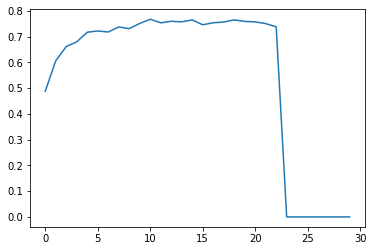

The model accuracy did not improve, patience_i =  3
-------------------------------------------------------------------------
Epoch 15 / 30 : 
Training: 
Epoch 15/15
1769/1769 [==============================] - 329s 186ms/step - loss: 0.5804 - acc: 0.8619
Validation: 
208/208 [==============================] - 38s 181ms/step - loss: 1.1303 - acc: 0.7473


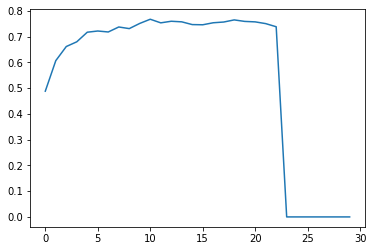

The model accuracy did not improve, patience_i =  4
-------------------------------------------------------------------------
Epoch 16 / 30 : 
Training: 
Epoch 16/16
1769/1769 [==============================] - 351s 198ms/step - loss: 0.5831 - acc: 0.8624
Validation: 
208/208 [==============================] - 37s 180ms/step - loss: 1.0585 - acc: 0.7657


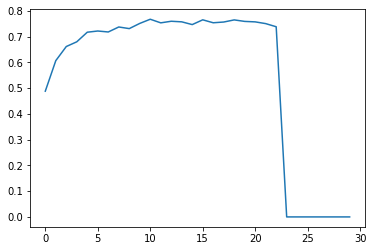

The model accuracy did not improve, patience_i =  5
-------------------------------------------------------------------------
Epoch 17 / 30 : 
Training: 
Epoch 17/17
1769/1769 [==============================] - 362s 204ms/step - loss: 0.6073 - acc: 0.8649
Validation: 
208/208 [==============================] - 38s 183ms/step - loss: 1.1671 - acc: 0.7539


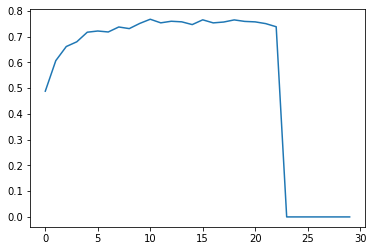

The model accuracy did not improve, patience_i =  6
-------------------------------------------------------------------------
Epoch 18 / 30 : 
Training: 
Epoch 18/18
1769/1769 [==============================] - 328s 186ms/step - loss: 0.5675 - acc: 0.8651
Validation: 
208/208 [==============================] - 38s 181ms/step - loss: 1.2755 - acc: 0.7575


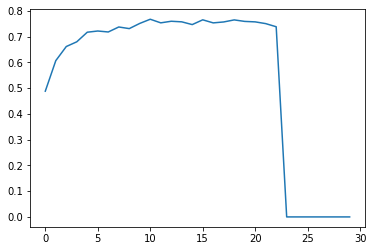

The model accuracy did not improve, patience_i =  7
-------------------------------------------------------------------------
Epoch 19 / 30 : 
Training: 
Epoch 19/19
1769/1769 [==============================] - 325s 184ms/step - loss: 0.6062 - acc: 0.8674
Validation: 
208/208 [==============================] - 37s 178ms/step - loss: 1.1766 - acc: 0.7575


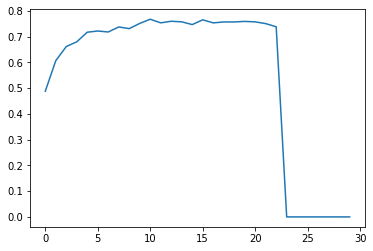

The model accuracy did not improve, patience_i =  8
-------------------------------------------------------------------------
Epoch 20 / 30 : 
Training: 
Epoch 20/20
1769/1769 [==============================] - 328s 186ms/step - loss: 0.5598 - acc: 0.8661
Validation: 
208/208 [==============================] - 38s 181ms/step - loss: 1.0698 - acc: 0.7561


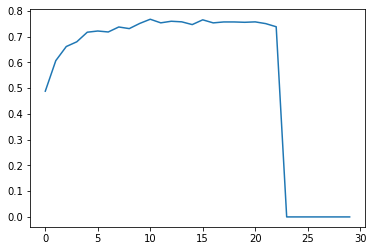

The model accuracy did not improve, patience_i =  9
-------------------------------------------------------------------------
Epoch 21 / 30 : 
Training: 
Epoch 21/21
1769/1769 [==============================] - 327s 185ms/step - loss: 0.5954 - acc: 0.8647
Validation: 
208/208 [==============================] - 37s 177ms/step - loss: 1.1566 - acc: 0.7656


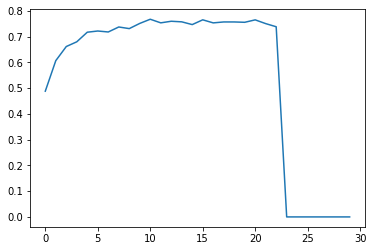

The model accuracy did not improve, patience_i =  10
-------------------------------------------------------------------------
Epoch 22 / 30 : 
Training: 
Epoch 22/22
1769/1769 [==============================] - 324s 183ms/step - loss: 0.5825 - acc: 0.8656
Validation: 
208/208 [==============================] - 37s 176ms/step - loss: 1.4072 - acc: 0.7418


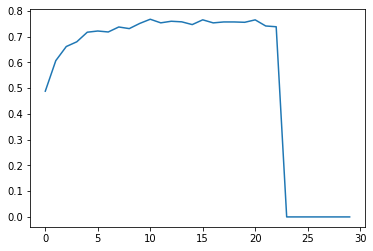

The model accuracy did not improve, patience_i =  11
Early Stopping, the model did not improve from an accuracy:  inf
-------------------------------------------------------------------------
Testing: 
105/105 [==============================] - 24s 228ms/step - loss: 1.3478 - acc: 0.7361
Test Results:  1.3477684259414673 0.7361485362052917
-------------------------------------------------------------------------
Epoch 1 / 30 : 
Training: 
1769/1769 [==============================] - 322s 182ms/step - loss: 1.8081 - acc: 0.3757
Validation: 
208/208 [==============================] - 37s 176ms/step - loss: 1.3794 - acc: 0.5073


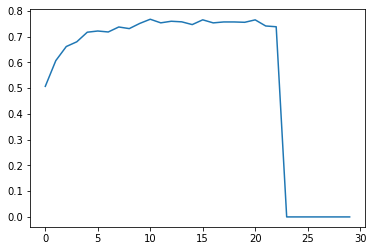

The model accuracy improved from:  0 to:  0.5072921514511108
-------------------------------------------------------------------------
Epoch 2 / 30 : 
Training: 
Epoch 2/2
1769/1769 [==============================] - 323s 183ms/step - loss: 1.2827 - acc: 0.5627
Validation: 
208/208 [==============================] - 37s 178ms/step - loss: 1.1236 - acc: 0.6271


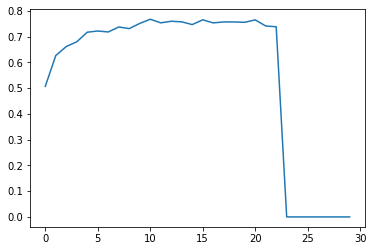

The model accuracy improved from:  0.5072921514511108 to:  0.6271237134933472
-------------------------------------------------------------------------
Epoch 3 / 30 : 
Training: 
Epoch 3/3
1769/1769 [==============================] - 322s 182ms/step - loss: 1.1518 - acc: 0.6593
Validation: 
208/208 [==============================] - 37s 177ms/step - loss: 1.0283 - acc: 0.6757


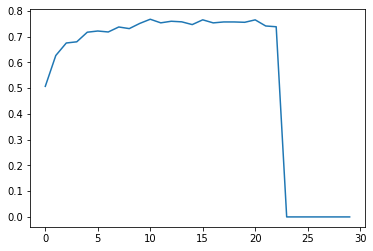

The model accuracy improved from:  0.6271237134933472 to:  0.675687849521637
-------------------------------------------------------------------------
Epoch 4 / 30 : 
Training: 
Epoch 4/4
1769/1769 [==============================] - 321s 181ms/step - loss: 0.9416 - acc: 0.7137
Validation: 
208/208 [==============================] - 37s 176ms/step - loss: 0.9961 - acc: 0.6913


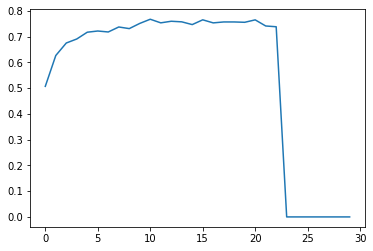

The model accuracy improved from:  0.675687849521637 to:  0.6913245916366577
-------------------------------------------------------------------------
Epoch 5 / 30 : 
Training: 
Epoch 5/5
1769/1769 [==============================] - 324s 183ms/step - loss: 0.9323 - acc: 0.7609
Validation: 
208/208 [==============================] - 37s 177ms/step - loss: 0.9383 - acc: 0.7237


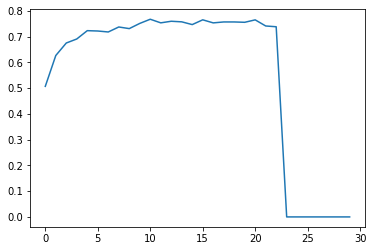

The model accuracy improved from:  0.6913245916366577 to:  0.7236505746841431
-------------------------------------------------------------------------
Epoch 6 / 30 : 
Training: 
Epoch 6/6
1769/1769 [==============================] - 325s 184ms/step - loss: 0.7852 - acc: 0.7881
Validation: 
208/208 [==============================] - 37s 178ms/step - loss: 0.9324 - acc: 0.7364


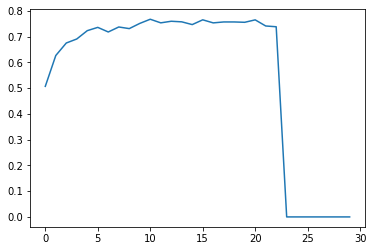

The model accuracy improved from:  0.7236505746841431 to:  0.7364305853843689
-------------------------------------------------------------------------
Epoch 7 / 30 : 
Training: 
Epoch 7/7
1769/1769 [==============================] - 324s 183ms/step - loss: 0.7367 - acc: 0.8111
Validation: 
208/208 [==============================] - 37s 178ms/step - loss: 0.9390 - acc: 0.7533


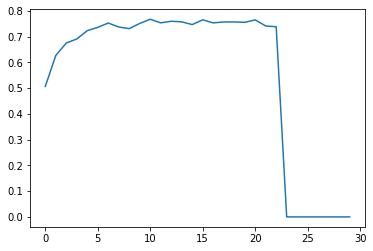

The model accuracy improved from:  0.7364305853843689 to:  0.7532702088356018
-------------------------------------------------------------------------
Epoch 8 / 30 : 
Training: 
Epoch 8/8
1769/1769 [==============================] - 326s 184ms/step - loss: 0.6893 - acc: 0.8289
Validation: 
208/208 [==============================] - 37s 177ms/step - loss: 0.9768 - acc: 0.7525


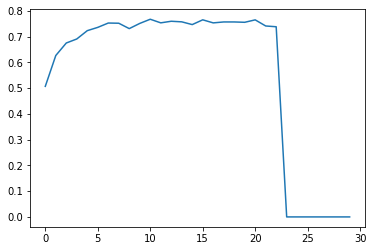

The model accuracy did not improve, patience_i =  1
-------------------------------------------------------------------------
Epoch 9 / 30 : 
Training: 
Epoch 9/9
1769/1769 [==============================] - 327s 185ms/step - loss: 0.6185 - acc: 0.8419
Validation: 
208/208 [==============================] - 38s 181ms/step - loss: 0.9685 - acc: 0.7394


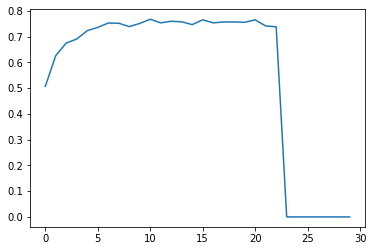

The model accuracy did not improve, patience_i =  2
-------------------------------------------------------------------------
Epoch 10 / 30 : 
Training: 
Epoch 10/10
1769/1769 [==============================] - 326s 184ms/step - loss: 0.6366 - acc: 0.8509
Validation: 
208/208 [==============================] - 38s 183ms/step - loss: 0.9691 - acc: 0.7503


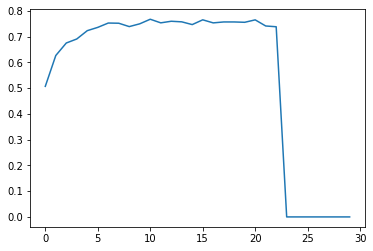

The model accuracy did not improve, patience_i =  3
-------------------------------------------------------------------------
Epoch 11 / 30 : 
Training: 
Epoch 11/11
1769/1769 [==============================] - 328s 185ms/step - loss: 0.5697 - acc: 0.8604
Validation: 
208/208 [==============================] - 37s 180ms/step - loss: 1.0301 - acc: 0.7641


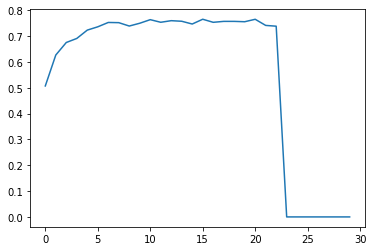

The model accuracy improved from:  0.7532702088356018 to:  0.7640956044197083
-------------------------------------------------------------------------
Epoch 12 / 30 : 
Training: 
Epoch 12/12
1769/1769 [==============================] - 323s 183ms/step - loss: 0.6702 - acc: 0.8631
Validation: 
208/208 [==============================] - 36s 175ms/step - loss: 0.9390 - acc: 0.7587


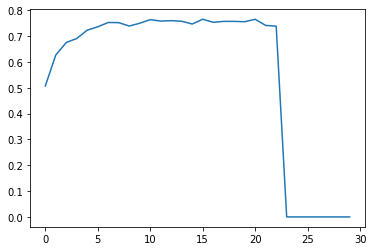

The model accuracy did not improve, patience_i =  1
-------------------------------------------------------------------------
Epoch 13 / 30 : 
Training: 
Epoch 13/13
1769/1769 [==============================] - 325s 184ms/step - loss: 0.5576 - acc: 0.8680
Validation: 
208/208 [==============================] - 38s 182ms/step - loss: 0.9919 - acc: 0.7721


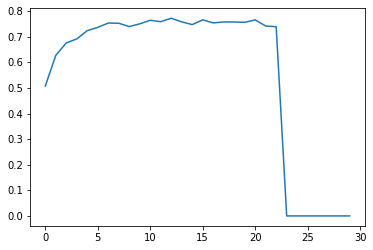

The model accuracy improved from:  0.7640956044197083 to:  0.7720643281936646
-------------------------------------------------------------------------
Epoch 14 / 30 : 
Training: 
Epoch 14/14
1769/1769 [==============================] - 325s 184ms/step - loss: 0.5366 - acc: 0.8702
Validation: 
208/208 [==============================] - 37s 176ms/step - loss: 1.0832 - acc: 0.7647


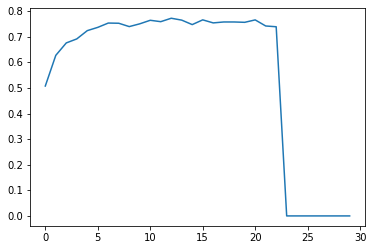

The model accuracy did not improve, patience_i =  1
-------------------------------------------------------------------------
Epoch 15 / 30 : 
Training: 
Epoch 15/15
1769/1769 [==============================] - 327s 185ms/step - loss: 0.5267 - acc: 0.8735
Validation: 
208/208 [==============================] - 38s 181ms/step - loss: 1.1722 - acc: 0.7567


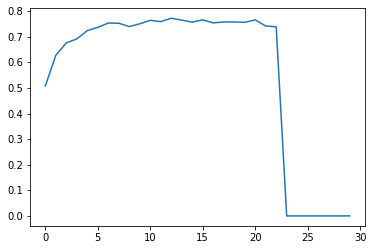

The model accuracy did not improve, patience_i =  2
-------------------------------------------------------------------------
Epoch 16 / 30 : 
Training: 
Epoch 16/16
1769/1769 [==============================] - 325s 184ms/step - loss: 0.5723 - acc: 0.8737
Validation: 
208/208 [==============================] - 37s 180ms/step - loss: 1.0607 - acc: 0.7417


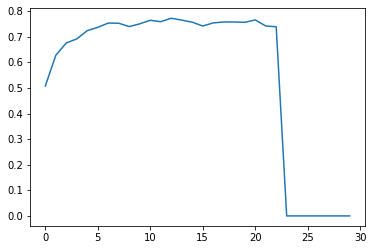

The model accuracy did not improve, patience_i =  3
-------------------------------------------------------------------------
Epoch 17 / 30 : 
Training: 
Epoch 17/17
1769/1769 [==============================] - 322s 182ms/step - loss: 0.5349 - acc: 0.8745
Validation: 
208/208 [==============================] - 36s 173ms/step - loss: 1.1709 - acc: 0.7706


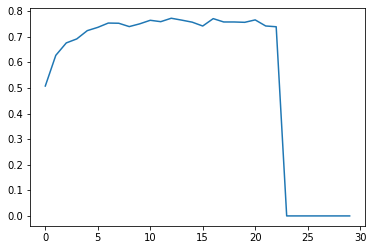

The model accuracy did not improve, patience_i =  4
-------------------------------------------------------------------------
Epoch 18 / 30 : 
Training: 
Epoch 18/18
1769/1769 [==============================] - 320s 181ms/step - loss: 0.5811 - acc: 0.8763
Validation: 
208/208 [==============================] - 37s 180ms/step - loss: 1.1438 - acc: 0.7754


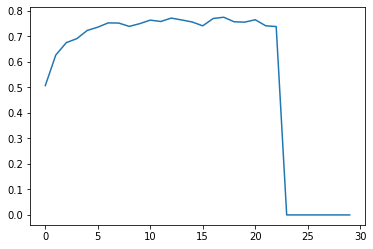

The model accuracy improved from:  0.7720643281936646 to:  0.7753721475601196
-------------------------------------------------------------------------
Epoch 19 / 30 : 
Training: 
Epoch 19/19
1769/1769 [==============================] - 323s 183ms/step - loss: 0.5187 - acc: 0.8775
Validation: 
208/208 [==============================] - 37s 178ms/step - loss: 1.1687 - acc: 0.7748


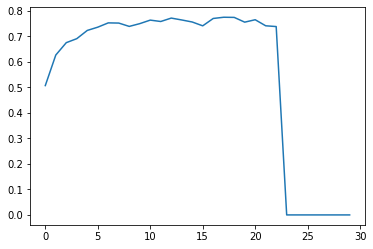

The model accuracy did not improve, patience_i =  1
-------------------------------------------------------------------------
Epoch 20 / 30 : 
Training: 
Epoch 20/20
1769/1769 [==============================] - 326s 184ms/step - loss: 0.6170 - acc: 0.8744
Validation: 
208/208 [==============================] - 36s 175ms/step - loss: 1.2663 - acc: 0.7653


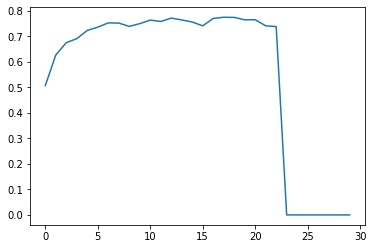

The model accuracy did not improve, patience_i =  2
-------------------------------------------------------------------------
Epoch 21 / 30 : 
Training: 
Epoch 21/21
1769/1769 [==============================] - 322s 182ms/step - loss: 0.5286 - acc: 0.8773
Validation: 
208/208 [==============================] - 36s 175ms/step - loss: 1.0705 - acc: 0.7605


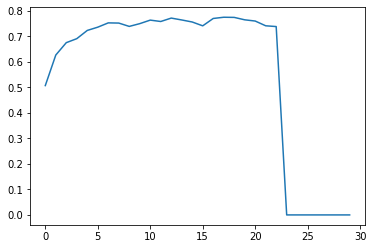

The model accuracy did not improve, patience_i =  3
-------------------------------------------------------------------------
Epoch 22 / 30 : 
Training: 
Epoch 22/22
1769/1769 [==============================] - 357s 202ms/step - loss: 0.5600 - acc: 0.8761
Validation: 
208/208 [==============================] - 37s 177ms/step - loss: 1.3301 - acc: 0.7704


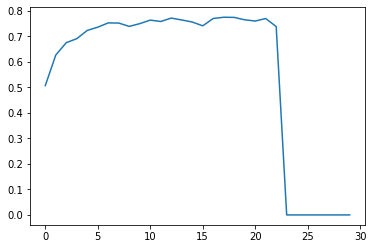

The model accuracy did not improve, patience_i =  4
-------------------------------------------------------------------------
Epoch 23 / 30 : 
Training: 
Epoch 23/23
1769/1769 [==============================] - 322s 182ms/step - loss: 0.5369 - acc: 0.8796
Validation: 
208/208 [==============================] - 37s 177ms/step - loss: 1.1813 - acc: 0.7488


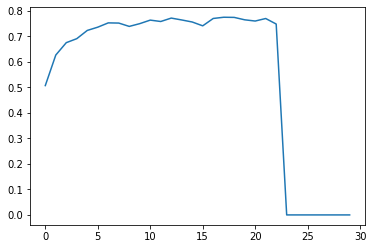

The model accuracy did not improve, patience_i =  5
-------------------------------------------------------------------------
Epoch 24 / 30 : 
Training: 
Epoch 24/24
1769/1769 [==============================] - 323s 182ms/step - loss: 0.5390 - acc: 0.8756
Validation: 
208/208 [==============================] - 37s 179ms/step - loss: 1.1122 - acc: 0.7633


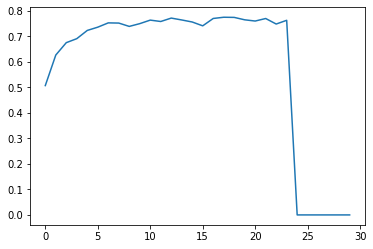

The model accuracy did not improve, patience_i =  6
-------------------------------------------------------------------------
Epoch 25 / 30 : 
Training: 
Epoch 25/25
1769/1769 [==============================] - 332s 188ms/step - loss: 0.5707 - acc: 0.8753
Validation: 
208/208 [==============================] - 38s 182ms/step - loss: 1.2033 - acc: 0.7576


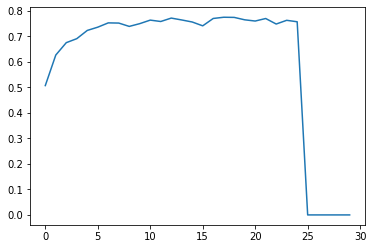

The model accuracy did not improve, patience_i =  7
-------------------------------------------------------------------------
Epoch 26 / 30 : 
Training: 
Epoch 26/26
1769/1769 [==============================] - 331s 187ms/step - loss: 0.5274 - acc: 0.8753
Validation: 
208/208 [==============================] - 38s 181ms/step - loss: 1.0360 - acc: 0.7664


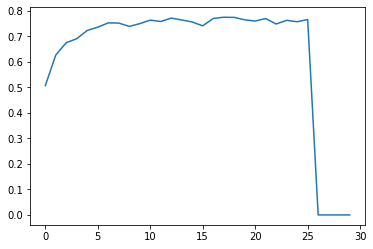

The model accuracy did not improve, patience_i =  8
-------------------------------------------------------------------------
Epoch 27 / 30 : 
Training: 
Epoch 27/27
1769/1769 [==============================] - 330s 187ms/step - loss: 0.5342 - acc: 0.8746
Validation: 
208/208 [==============================] - 37s 178ms/step - loss: 1.0944 - acc: 0.7373


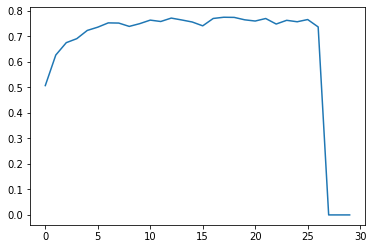

The model accuracy did not improve, patience_i =  9
-------------------------------------------------------------------------
Epoch 28 / 30 : 
Training: 
Epoch 28/28
1769/1769 [==============================] - 332s 188ms/step - loss: 0.5482 - acc: 0.8732
Validation: 
208/208 [==============================] - 38s 180ms/step - loss: 1.3514 - acc: 0.7677


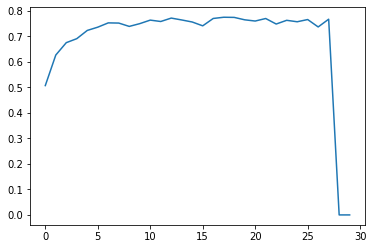

The model accuracy did not improve, patience_i =  10
-------------------------------------------------------------------------
Epoch 29 / 30 : 
Training: 
Epoch 29/29
1769/1769 [==============================] - 323s 182ms/step - loss: 0.5705 - acc: 0.8728
Validation: 
208/208 [==============================] - 36s 174ms/step - loss: 1.2306 - acc: 0.7650


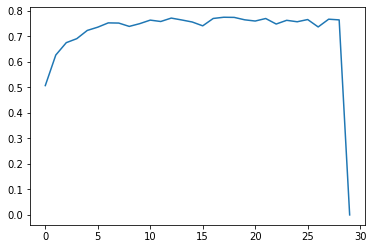

The model accuracy did not improve, patience_i =  11
Early Stopping, the model did not improve from an accuracy:  inf
-------------------------------------------------------------------------
Testing: 
105/105 [==============================] - 25s 235ms/step - loss: 1.2321 - acc: 0.7526
Test Results:  1.2320550680160522 0.75262051820755
-------------------------------------------------------------------------
Epoch 1 / 30 : 
Training: 
1769/1769 [==============================] - 314s 177ms/step - loss: 1.8050 - acc: 0.3567
Validation: 
208/208 [==============================] - 36s 173ms/step - loss: 1.5931 - acc: 0.4243


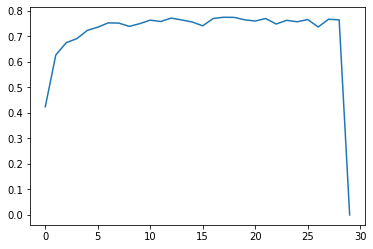

The model accuracy improved from:  0 to:  0.4242970943450928
-------------------------------------------------------------------------
Epoch 2 / 30 : 
Training: 
Epoch 2/2
1769/1769 [==============================] - 344s 195ms/step - loss: 1.3495 - acc: 0.5459
Validation: 
208/208 [==============================] - 36s 172ms/step - loss: 1.1685 - acc: 0.6005


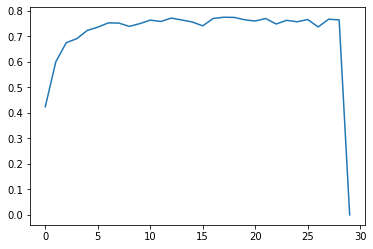

The model accuracy improved from:  0.4242970943450928 to:  0.6005111932754517
-------------------------------------------------------------------------
Epoch 3 / 30 : 
Training: 
Epoch 3/3
1769/1769 [==============================] - 314s 177ms/step - loss: 1.1083 - acc: 0.6388
Validation: 
208/208 [==============================] - 35s 170ms/step - loss: 1.0762 - acc: 0.6563


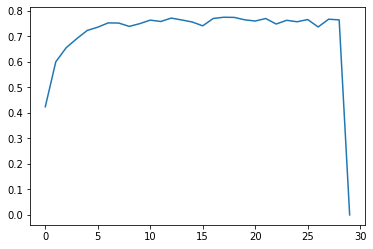

The model accuracy improved from:  0.6005111932754517 to:  0.6562922596931458
-------------------------------------------------------------------------
Epoch 4 / 30 : 
Training: 
Epoch 4/4
1769/1769 [==============================] - 316s 178ms/step - loss: 0.9498 - acc: 0.7014
Validation: 
208/208 [==============================] - 35s 169ms/step - loss: 0.9689 - acc: 0.7012


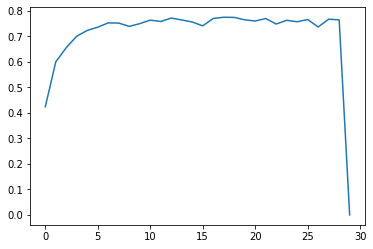

The model accuracy improved from:  0.6562922596931458 to:  0.7012479305267334
-------------------------------------------------------------------------
Epoch 5 / 30 : 
Training: 
Epoch 5/5
1769/1769 [==============================] - 315s 178ms/step - loss: 0.8512 - acc: 0.7472
Validation: 
208/208 [==============================] - 36s 171ms/step - loss: 0.9505 - acc: 0.7058


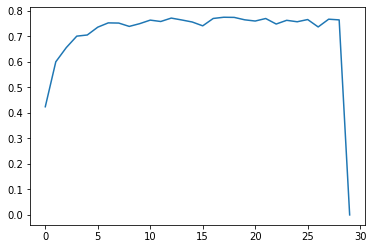

The model accuracy improved from:  0.7012479305267334 to:  0.7057585120201111
-------------------------------------------------------------------------
Epoch 6 / 30 : 
Training: 
Epoch 6/6
1769/1769 [==============================] - 313s 177ms/step - loss: 0.7970 - acc: 0.7747
Validation: 
208/208 [==============================] - 35s 170ms/step - loss: 0.9630 - acc: 0.7179


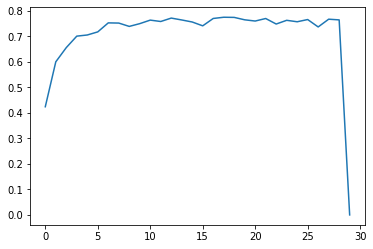

The model accuracy improved from:  0.7057585120201111 to:  0.717937171459198
-------------------------------------------------------------------------
Epoch 7 / 30 : 
Training: 
Epoch 7/7
1769/1769 [==============================] - 314s 177ms/step - loss: 0.7437 - acc: 0.7997
Validation: 
208/208 [==============================] - 36s 172ms/step - loss: 1.0068 - acc: 0.7333


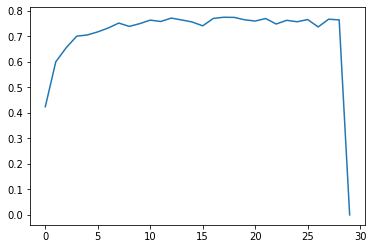

The model accuracy improved from:  0.717937171459198 to:  0.7332732081413269
-------------------------------------------------------------------------
Epoch 8 / 30 : 
Training: 
Epoch 8/8
1769/1769 [==============================] - 315s 178ms/step - loss: 0.7537 - acc: 0.8157
Validation: 
208/208 [==============================] - 36s 172ms/step - loss: 1.0559 - acc: 0.7382


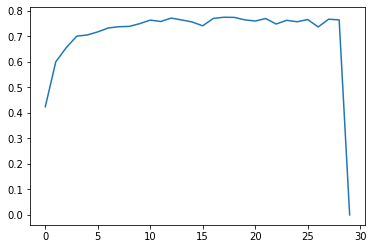

The model accuracy improved from:  0.7332732081413269 to:  0.7382348775863647
-------------------------------------------------------------------------
Epoch 9 / 30 : 
Training: 
Epoch 9/9
1769/1769 [==============================] - 314s 177ms/step - loss: 0.6965 - acc: 0.8305
Validation: 
208/208 [==============================] - 35s 170ms/step - loss: 1.0949 - acc: 0.7515


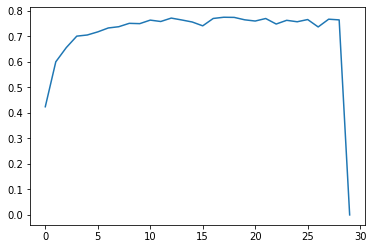

The model accuracy improved from:  0.7382348775863647 to:  0.751465916633606
-------------------------------------------------------------------------
Epoch 10 / 30 : 
Training: 
Epoch 10/10
1769/1769 [==============================] - 314s 177ms/step - loss: 0.6215 - acc: 0.8398
Validation: 
208/208 [==============================] - 36s 172ms/step - loss: 0.9222 - acc: 0.7509


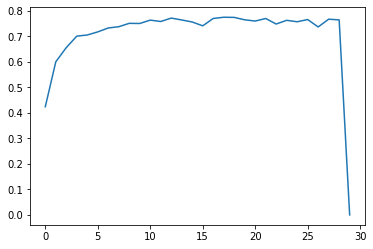

The model accuracy did not improve, patience_i =  1
-------------------------------------------------------------------------
Epoch 11 / 30 : 
Training: 
Epoch 11/11
1769/1769 [==============================] - 314s 177ms/step - loss: 0.5990 - acc: 0.8472
Validation: 
208/208 [==============================] - 36s 172ms/step - loss: 1.0671 - acc: 0.7680


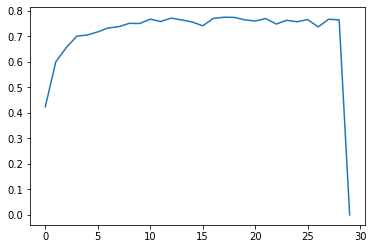

The model accuracy improved from:  0.751465916633606 to:  0.768004834651947
-------------------------------------------------------------------------
Epoch 12 / 30 : 
Training: 
Epoch 12/12
1769/1769 [==============================] - 314s 177ms/step - loss: 0.5789 - acc: 0.8530
Validation: 
208/208 [==============================] - 36s 171ms/step - loss: 1.2294 - acc: 0.7563


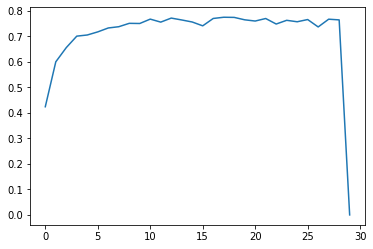

The model accuracy did not improve, patience_i =  1
-------------------------------------------------------------------------
Epoch 13 / 30 : 
Training: 
Epoch 13/13
1769/1769 [==============================] - 313s 177ms/step - loss: 0.5841 - acc: 0.8555
Validation: 
208/208 [==============================] - 36s 172ms/step - loss: 1.0473 - acc: 0.7677


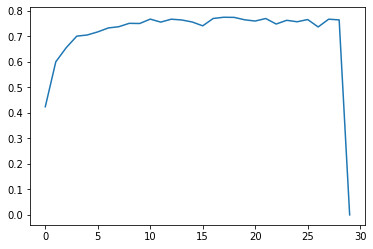

The model accuracy did not improve, patience_i =  2
-------------------------------------------------------------------------
Epoch 14 / 30 : 
Training: 
Epoch 14/14
1769/1769 [==============================] - 314s 177ms/step - loss: 0.5713 - acc: 0.8627
Validation: 
208/208 [==============================] - 36s 171ms/step - loss: 1.0575 - acc: 0.7579


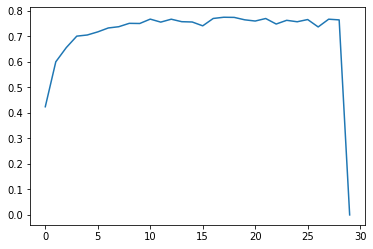

The model accuracy did not improve, patience_i =  3
-------------------------------------------------------------------------
Epoch 15 / 30 : 
Training: 
Epoch 15/15
1769/1769 [==============================] - 314s 177ms/step - loss: 0.6160 - acc: 0.8637
Validation: 
208/208 [==============================] - 35s 171ms/step - loss: 1.0751 - acc: 0.7692


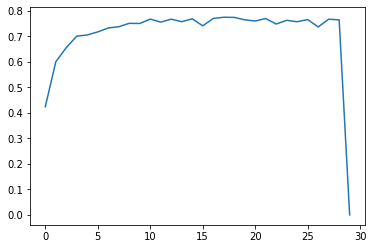

The model accuracy improved from:  0.768004834651947 to:  0.7692076563835144
-------------------------------------------------------------------------
Epoch 16 / 30 : 
Training: 
Epoch 16/16
1769/1769 [==============================] - 315s 178ms/step - loss: 0.5839 - acc: 0.8684
Validation: 
208/208 [==============================] - 35s 170ms/step - loss: 1.1029 - acc: 0.7421


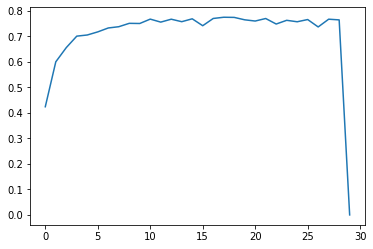

The model accuracy did not improve, patience_i =  1
-------------------------------------------------------------------------
Epoch 17 / 30 : 
Training: 
Epoch 17/17
1769/1769 [==============================] - 343s 194ms/step - loss: 0.7015 - acc: 0.8711
Validation: 
208/208 [==============================] - 35s 170ms/step - loss: 1.0965 - acc: 0.7775


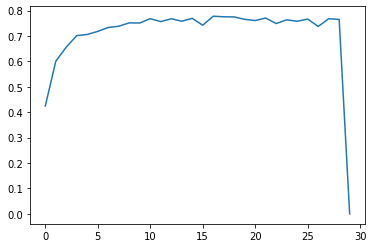

The model accuracy improved from:  0.7692076563835144 to:  0.7774770855903625
-------------------------------------------------------------------------
Epoch 18 / 30 : 
Training: 
Epoch 18/18
1769/1769 [==============================] - 313s 177ms/step - loss: 0.5493 - acc: 0.8773
Validation: 
208/208 [==============================] - 36s 172ms/step - loss: 1.1719 - acc: 0.7635


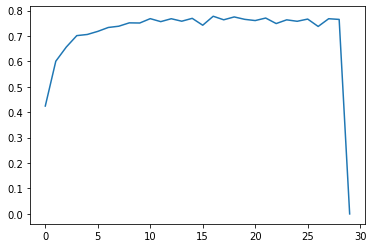

The model accuracy did not improve, patience_i =  1
-------------------------------------------------------------------------
Epoch 19 / 30 : 
Training: 
Epoch 19/19
1769/1769 [==============================] - 314s 177ms/step - loss: 0.5277 - acc: 0.8767
Validation: 
208/208 [==============================] - 36s 171ms/step - loss: 1.1662 - acc: 0.7340


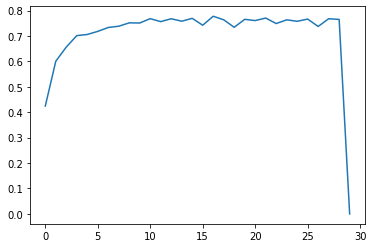

The model accuracy did not improve, patience_i =  2
-------------------------------------------------------------------------
Epoch 20 / 30 : 
Training: 
Epoch 20/20
1769/1769 [==============================] - 313s 177ms/step - loss: 0.5270 - acc: 0.8791
Validation: 
208/208 [==============================] - 36s 172ms/step - loss: 1.1258 - acc: 0.7683


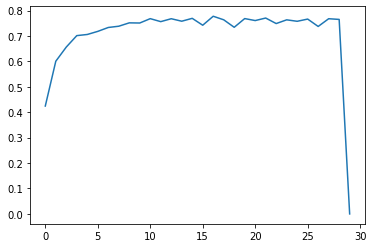

The model accuracy did not improve, patience_i =  3
-------------------------------------------------------------------------
Epoch 21 / 30 : 
Training: 
Epoch 21/21
1769/1769 [==============================] - 314s 177ms/step - loss: 0.5343 - acc: 0.8774
Validation: 
208/208 [==============================] - 36s 172ms/step - loss: 1.1588 - acc: 0.7772


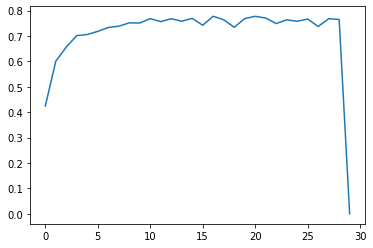

The model accuracy did not improve, patience_i =  4
-------------------------------------------------------------------------
Epoch 22 / 30 : 
Training: 
Epoch 22/22
1769/1769 [==============================] - 314s 178ms/step - loss: 0.5281 - acc: 0.8792
Validation: 
208/208 [==============================] - 36s 171ms/step - loss: 1.1614 - acc: 0.7537


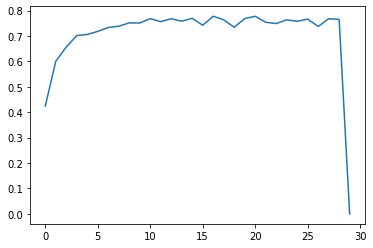

The model accuracy did not improve, patience_i =  5
-------------------------------------------------------------------------
Epoch 23 / 30 : 
Training: 
Epoch 23/23
1769/1769 [==============================] - 345s 195ms/step - loss: 0.5198 - acc: 0.8782
Validation: 
208/208 [==============================] - 36s 172ms/step - loss: 1.2148 - acc: 0.7698


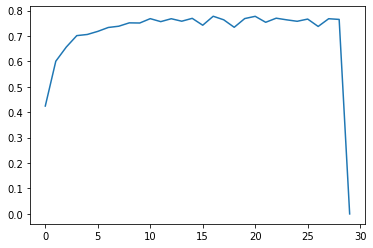

The model accuracy did not improve, patience_i =  6
-------------------------------------------------------------------------
Epoch 24 / 30 : 
Training: 
Epoch 24/24
1769/1769 [==============================] - 314s 177ms/step - loss: 0.5878 - acc: 0.8773
Validation: 
208/208 [==============================] - 36s 171ms/step - loss: 1.1638 - acc: 0.7679


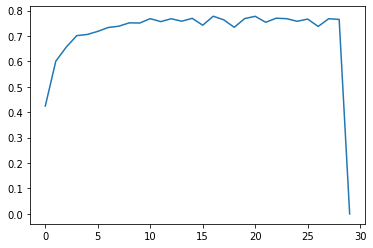

The model accuracy did not improve, patience_i =  7
-------------------------------------------------------------------------
Epoch 25 / 30 : 
Training: 
Epoch 25/25
1769/1769 [==============================] - 314s 177ms/step - loss: 0.5455 - acc: 0.8845
Validation: 
208/208 [==============================] - 36s 171ms/step - loss: 1.1640 - acc: 0.7710


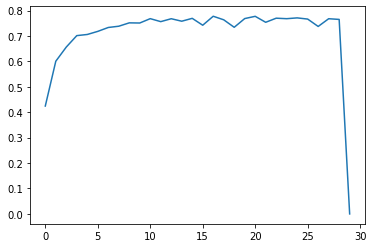

The model accuracy did not improve, patience_i =  8
-------------------------------------------------------------------------
Epoch 26 / 30 : 
Training: 
Epoch 26/26
1769/1769 [==============================] - 314s 177ms/step - loss: 0.5318 - acc: 0.8831
Validation: 
208/208 [==============================] - 36s 172ms/step - loss: 1.3799 - acc: 0.7555


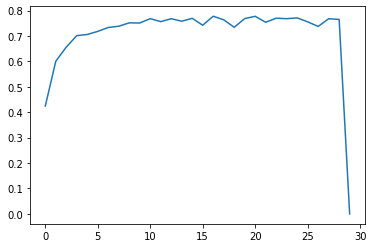

The model accuracy did not improve, patience_i =  9
-------------------------------------------------------------------------
Epoch 27 / 30 : 
Training: 
Epoch 27/27
1769/1769 [==============================] - 344s 195ms/step - loss: 0.5363 - acc: 0.8835
Validation: 
208/208 [==============================] - 36s 172ms/step - loss: 1.2455 - acc: 0.7703


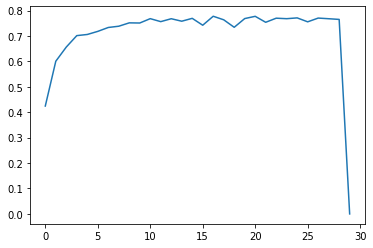

The model accuracy did not improve, patience_i =  10
-------------------------------------------------------------------------
Epoch 28 / 30 : 
Training: 
Epoch 28/28
1769/1769 [==============================] - 314s 178ms/step - loss: 0.5053 - acc: 0.8832
Validation: 
208/208 [==============================] - 36s 173ms/step - loss: 0.9964 - acc: 0.7638


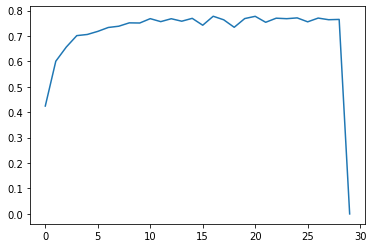

The model accuracy did not improve, patience_i =  11
Early Stopping, the model did not improve from an accuracy:  inf
-------------------------------------------------------------------------
Testing: 
105/105 [==============================] - 54s 515ms/step - loss: 1.0369 - acc: 0.7643
Test Results:  1.0369402170181274 0.7643007040023804
-------------------------------------------------------------------------
Epoch 1 / 30 : 
Training: 
1769/1769 [==============================] - 314s 178ms/step - loss: 1.6962 - acc: 0.3734
Validation: 
208/208 [==============================] - 36s 172ms/step - loss: 1.3854 - acc: 0.5040


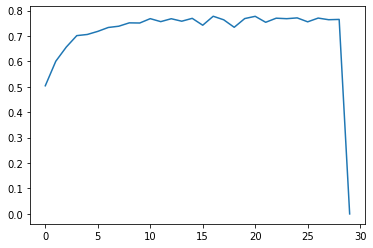

The model accuracy improved from:  0 to:  0.5039843916893005
-------------------------------------------------------------------------
Epoch 2 / 30 : 
Training: 
Epoch 2/2
1769/1769 [==============================] - 316s 179ms/step - loss: 1.5017 - acc: 0.5610
Validation: 
208/208 [==============================] - 35s 170ms/step - loss: 1.1835 - acc: 0.5977


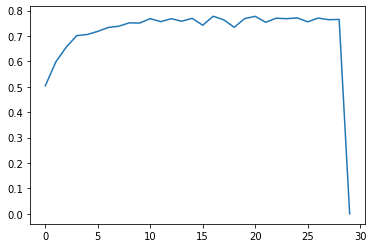

The model accuracy improved from:  0.5039843916893005 to:  0.5976544618606567
-------------------------------------------------------------------------
Epoch 3 / 30 : 
Training: 
Epoch 3/3
1769/1769 [==============================] - 314s 178ms/step - loss: 1.1507 - acc: 0.6474
Validation: 
208/208 [==============================] - 36s 172ms/step - loss: 1.0761 - acc: 0.6593


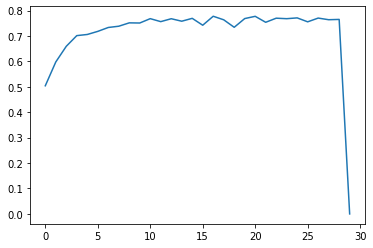

The model accuracy improved from:  0.5976544618606567 to:  0.659299373626709
-------------------------------------------------------------------------
Epoch 4 / 30 : 
Training: 
Epoch 4/4
1769/1769 [==============================] - 315s 178ms/step - loss: 0.9903 - acc: 0.7028
Validation: 
208/208 [==============================] - 36s 171ms/step - loss: 0.9670 - acc: 0.7034


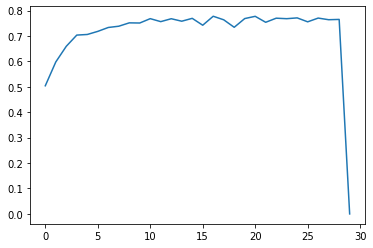

The model accuracy improved from:  0.659299373626709 to:  0.7033528685569763
-------------------------------------------------------------------------
Epoch 5 / 30 : 
Training: 
Epoch 5/5
1769/1769 [==============================] - 317s 179ms/step - loss: 0.8584 - acc: 0.7452
Validation: 
208/208 [==============================] - 36s 172ms/step - loss: 0.9724 - acc: 0.7122


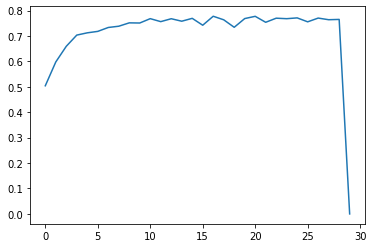

The model accuracy improved from:  0.7033528685569763 to:  0.7122237086296082
-------------------------------------------------------------------------
Epoch 6 / 30 : 
Training: 
Epoch 6/6
1769/1769 [==============================] - 315s 178ms/step - loss: 0.8053 - acc: 0.7747
Validation: 
208/208 [==============================] - 36s 171ms/step - loss: 1.0733 - acc: 0.7127


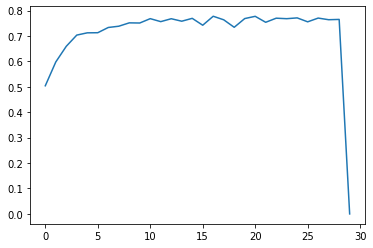

The model accuracy improved from:  0.7122237086296082 to:  0.7126747965812683
-------------------------------------------------------------------------
Epoch 7 / 30 : 
Training: 
Epoch 7/7
1769/1769 [==============================] - 315s 178ms/step - loss: 0.7526 - acc: 0.7971
Validation: 
208/208 [==============================] - 36s 173ms/step - loss: 1.0107 - acc: 0.7351


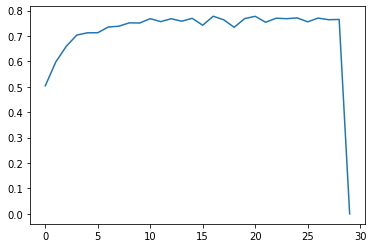

The model accuracy improved from:  0.7126747965812683 to:  0.735077440738678
-------------------------------------------------------------------------
Epoch 8 / 30 : 
Training: 
Epoch 8/8
1769/1769 [==============================] - 316s 179ms/step - loss: 0.7813 - acc: 0.8141
Validation: 
208/208 [==============================] - 36s 171ms/step - loss: 0.9792 - acc: 0.7567


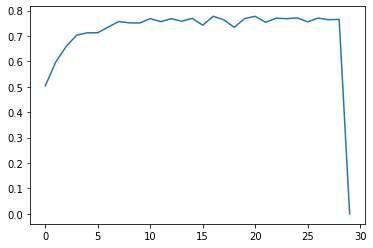

The model accuracy improved from:  0.735077440738678 to:  0.7567282915115356
-------------------------------------------------------------------------
Epoch 9 / 30 : 
Training: 
Epoch 9/9
1769/1769 [==============================] - 315s 178ms/step - loss: 0.6818 - acc: 0.8284
Validation: 
208/208 [==============================] - 36s 172ms/step - loss: 0.9829 - acc: 0.7606


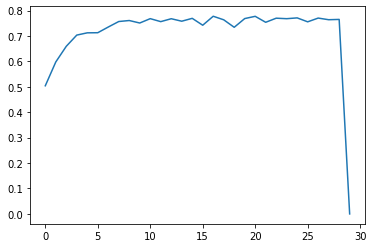

The model accuracy improved from:  0.7567282915115356 to:  0.7606375217437744
-------------------------------------------------------------------------
Epoch 10 / 30 : 
Training: 
Epoch 10/10
1769/1769 [==============================] - 315s 178ms/step - loss: 0.6091 - acc: 0.8416
Validation: 
208/208 [==============================] - 36s 175ms/step - loss: 0.9466 - acc: 0.7552


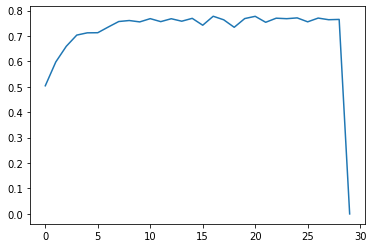

The model accuracy did not improve, patience_i =  1
-------------------------------------------------------------------------
Epoch 11 / 30 : 
Training: 
Epoch 11/11
1769/1769 [==============================] - 317s 179ms/step - loss: 0.6685 - acc: 0.8485
Validation: 
208/208 [==============================] - 36s 172ms/step - loss: 1.0190 - acc: 0.7569


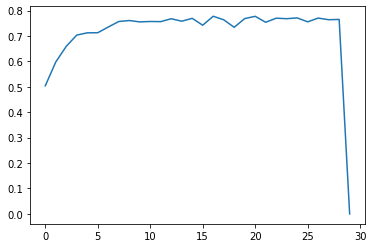

The model accuracy did not improve, patience_i =  2
-------------------------------------------------------------------------
Epoch 12 / 30 : 
Training: 
Epoch 12/12
1769/1769 [==============================] - 315s 178ms/step - loss: 0.5999 - acc: 0.8563
Validation: 
208/208 [==============================] - 36s 175ms/step - loss: 0.9874 - acc: 0.7627


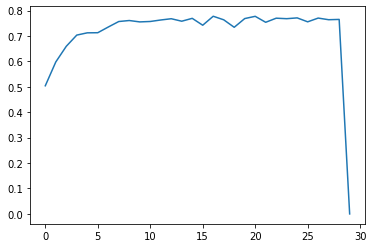

The model accuracy improved from:  0.7606375217437744 to:  0.7627424597740173
-------------------------------------------------------------------------
Epoch 13 / 30 : 
Training: 
Epoch 13/13
1769/1769 [==============================] - 315s 178ms/step - loss: 0.5932 - acc: 0.8577
Validation: 
208/208 [==============================] - 36s 171ms/step - loss: 1.0456 - acc: 0.7665


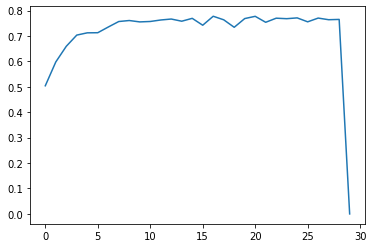

The model accuracy improved from:  0.7627424597740173 to:  0.7665013074874878
-------------------------------------------------------------------------
Epoch 14 / 30 : 
Training: 
Epoch 14/14
1769/1769 [==============================] - 315s 178ms/step - loss: 0.5684 - acc: 0.8606
Validation: 
208/208 [==============================] - 36s 172ms/step - loss: 0.9967 - acc: 0.7603


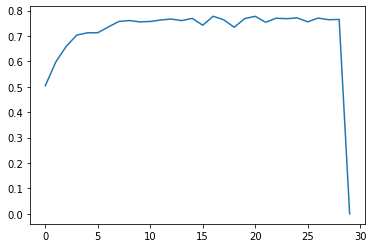

The model accuracy did not improve, patience_i =  1
-------------------------------------------------------------------------
Epoch 15 / 30 : 
Training: 
Epoch 15/15
1769/1769 [==============================] - 315s 178ms/step - loss: 0.5505 - acc: 0.8655
Validation: 
208/208 [==============================] - 36s 173ms/step - loss: 1.1345 - acc: 0.7486


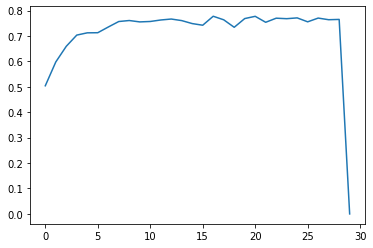

The model accuracy did not improve, patience_i =  2
-------------------------------------------------------------------------
Epoch 16 / 30 : 
Training: 
Epoch 16/16
1769/1769 [==============================] - 315s 178ms/step - loss: 0.5751 - acc: 0.8681
Validation: 
208/208 [==============================] - 36s 172ms/step - loss: 1.0213 - acc: 0.7573


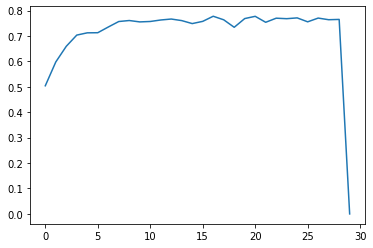

The model accuracy did not improve, patience_i =  3
-------------------------------------------------------------------------
Epoch 17 / 30 : 
Training: 
Epoch 17/17
1769/1769 [==============================] - 313s 177ms/step - loss: 0.7337 - acc: 0.8712
Validation: 
208/208 [==============================] - 36s 171ms/step - loss: 1.1358 - acc: 0.7618


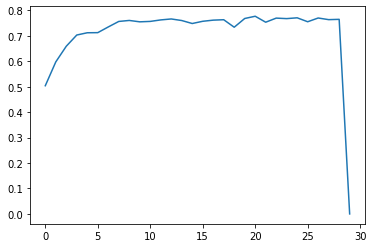

The model accuracy did not improve, patience_i =  4
-------------------------------------------------------------------------
Epoch 18 / 30 : 
Training: 
Epoch 18/18
1769/1769 [==============================] - 315s 178ms/step - loss: 0.5497 - acc: 0.8717
Validation: 
208/208 [==============================] - 36s 173ms/step - loss: 1.0857 - acc: 0.7638


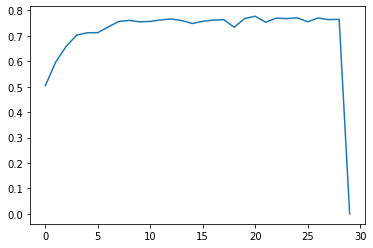

The model accuracy did not improve, patience_i =  5
-------------------------------------------------------------------------
Epoch 19 / 30 : 
Training: 
Epoch 19/19
1769/1769 [==============================] - 315s 178ms/step - loss: 0.5175 - acc: 0.8762
Validation: 
208/208 [==============================] - 35s 170ms/step - loss: 1.1968 - acc: 0.7585


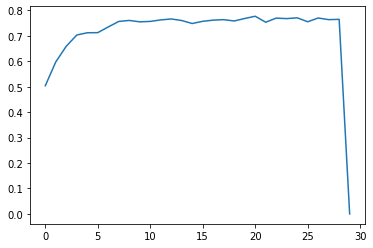

The model accuracy did not improve, patience_i =  6
-------------------------------------------------------------------------
Epoch 20 / 30 : 
Training: 
Epoch 20/20
1769/1769 [==============================] - 314s 178ms/step - loss: 0.5194 - acc: 0.8772
Validation: 
208/208 [==============================] - 36s 171ms/step - loss: 1.0942 - acc: 0.7746


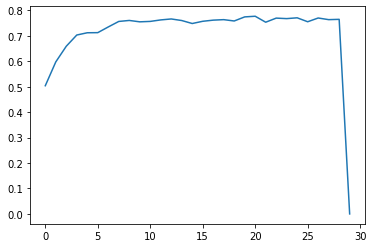

The model accuracy improved from:  0.7665013074874878 to:  0.7746203541755676
-------------------------------------------------------------------------
Epoch 21 / 30 : 
Training: 
Epoch 21/21
1769/1769 [==============================] - 314s 177ms/step - loss: 0.5227 - acc: 0.8782
Validation: 
208/208 [==============================] - 36s 172ms/step - loss: 1.0170 - acc: 0.7584


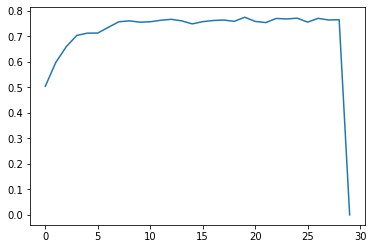

The model accuracy did not improve, patience_i =  1
-------------------------------------------------------------------------
Epoch 22 / 30 : 
Training: 
Epoch 22/22
1769/1769 [==============================] - 314s 178ms/step - loss: 0.5116 - acc: 0.8792
Validation: 
208/208 [==============================] - 36s 171ms/step - loss: 1.1045 - acc: 0.7676


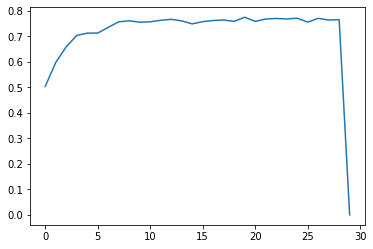

The model accuracy did not improve, patience_i =  2
-------------------------------------------------------------------------
Epoch 23 / 30 : 
Training: 
Epoch 23/23
1769/1769 [==============================] - 315s 178ms/step - loss: 0.5215 - acc: 0.8799
Validation: 
208/208 [==============================] - 36s 173ms/step - loss: 1.2268 - acc: 0.7701


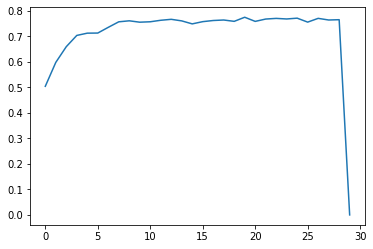

The model accuracy did not improve, patience_i =  3
-------------------------------------------------------------------------
Epoch 24 / 30 : 
Training: 
Epoch 24/24
1769/1769 [==============================] - 315s 178ms/step - loss: 0.5311 - acc: 0.8825
Validation: 
208/208 [==============================] - 36s 172ms/step - loss: 1.0255 - acc: 0.7588


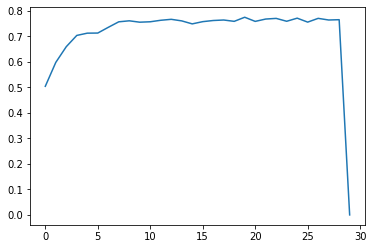

The model accuracy did not improve, patience_i =  4
-------------------------------------------------------------------------
Epoch 25 / 30 : 
Training: 
Epoch 25/25
1769/1769 [==============================] - 315s 178ms/step - loss: 0.5080 - acc: 0.8800
Validation: 
208/208 [==============================] - 36s 171ms/step - loss: 1.0840 - acc: 0.7823


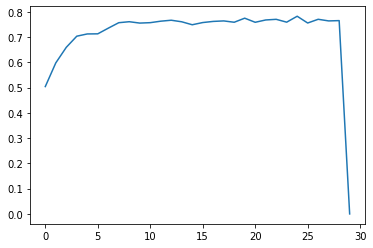

The model accuracy improved from:  0.7746203541755676 to:  0.7822883725166321
-------------------------------------------------------------------------
Epoch 26 / 30 : 
Training: 
Epoch 26/26
1769/1769 [==============================] - 317s 179ms/step - loss: 0.5042 - acc: 0.8821
Validation: 
208/208 [==============================] - 36s 173ms/step - loss: 1.1082 - acc: 0.7781


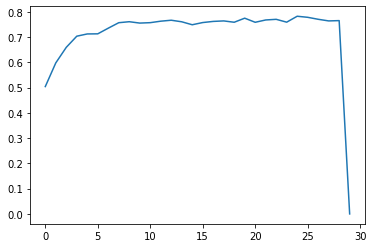

The model accuracy did not improve, patience_i =  1
-------------------------------------------------------------------------
Epoch 27 / 30 : 
Training: 
Epoch 27/27
1769/1769 [==============================] - 314s 177ms/step - loss: 0.5029 - acc: 0.8840
Validation: 
208/208 [==============================] - 35s 169ms/step - loss: 1.1228 - acc: 0.7641


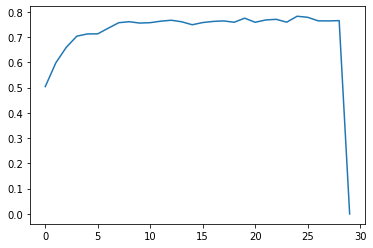

The model accuracy did not improve, patience_i =  2
-------------------------------------------------------------------------
Epoch 28 / 30 : 
Training: 
Epoch 28/28
1769/1769 [==============================] - 315s 178ms/step - loss: 0.5370 - acc: 0.8809
Validation: 
208/208 [==============================] - 36s 173ms/step - loss: 1.0903 - acc: 0.7624


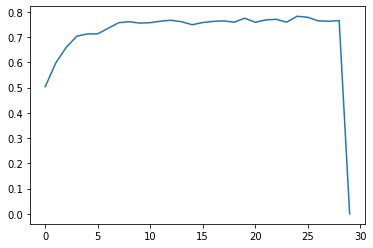

The model accuracy did not improve, patience_i =  3
-------------------------------------------------------------------------
Epoch 29 / 30 : 
Training: 
Epoch 29/29
1769/1769 [==============================] - 315s 178ms/step - loss: 0.5570 - acc: 0.8811
Validation: 
208/208 [==============================] - 36s 172ms/step - loss: 1.4592 - acc: 0.7608


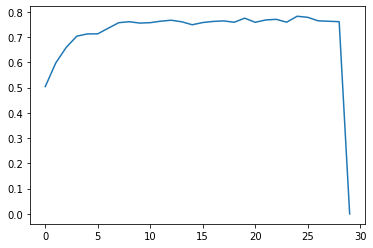

The model accuracy did not improve, patience_i =  4
-------------------------------------------------------------------------
Epoch 30 / 30 : 
Training: 
Epoch 30/30
1769/1769 [==============================] - 316s 178ms/step - loss: 0.5347 - acc: 0.8837
Validation: 
208/208 [==============================] - 36s 172ms/step - loss: 1.1725 - acc: 0.7721


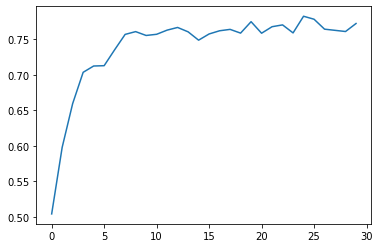

The model accuracy did not improve, patience_i =  5
-------------------------------------------------------------------------
Testing: 
105/105 [==============================] - 22s 205ms/step - loss: 1.1983 - acc: 0.7706
Test Results:  1.198324203491211 0.7705900073051453
-------------------------------------------------------------------------
Epoch 1 / 30 : 
Training: 
1769/1769 [==============================] - 316s 178ms/step - loss: 1.7488 - acc: 0.3737
Validation: 
208/208 [==============================] - 36s 171ms/step - loss: 1.4347 - acc: 0.4826


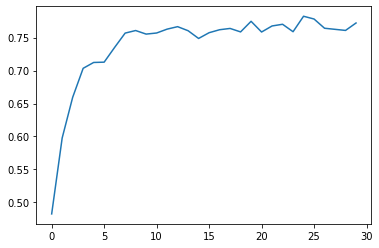

The model accuracy improved from:  0 to:  0.48263418674468994
-------------------------------------------------------------------------
Epoch 2 / 30 : 
Training: 
Epoch 2/2
1769/1769 [==============================] - 315s 178ms/step - loss: 1.2777 - acc: 0.5624
Validation: 
208/208 [==============================] - 36s 174ms/step - loss: 1.1408 - acc: 0.6184


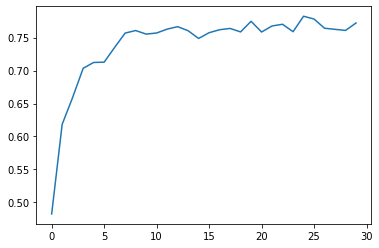

The model accuracy improved from:  0.48263418674468994 to:  0.6184032559394836
-------------------------------------------------------------------------
Epoch 3 / 30 : 
Training: 
Epoch 3/3
1769/1769 [==============================] - 342s 193ms/step - loss: 1.0850 - acc: 0.6535
Validation: 
208/208 [==============================] - 34s 161ms/step - loss: 1.0293 - acc: 0.6662


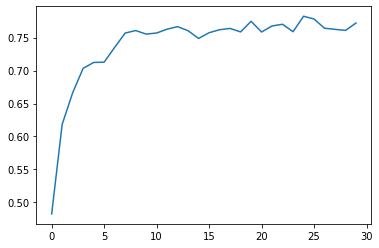

The model accuracy improved from:  0.6184032559394836 to:  0.6662155985832214
-------------------------------------------------------------------------
Epoch 4 / 30 : 
Training: 
Epoch 4/4
1769/1769 [==============================] - 306s 173ms/step - loss: 0.9560 - acc: 0.7108
Validation: 
208/208 [==============================] - 36s 173ms/step - loss: 0.9709 - acc: 0.7083


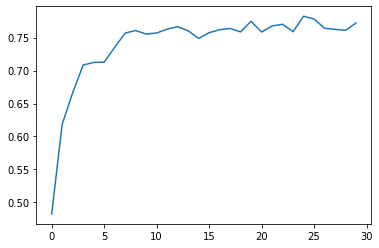

The model accuracy improved from:  0.6662155985832214 to:  0.7083145380020142
-------------------------------------------------------------------------
Epoch 5 / 30 : 
Training: 
Epoch 5/5
1769/1769 [==============================] - 308s 174ms/step - loss: 0.8451 - acc: 0.7490
Validation: 
208/208 [==============================] - 36s 173ms/step - loss: 0.9678 - acc: 0.7109


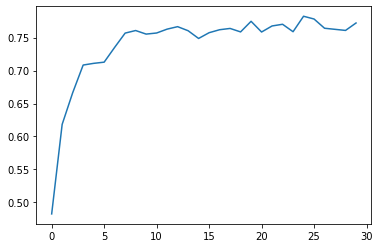

The model accuracy improved from:  0.7083145380020142 to:  0.7108705639839172
-------------------------------------------------------------------------
Epoch 6 / 30 : 
Training: 
Epoch 6/6
1769/1769 [==============================] - 317s 179ms/step - loss: 0.7723 - acc: 0.7812
Validation: 
208/208 [==============================] - 36s 174ms/step - loss: 1.0470 - acc: 0.7139


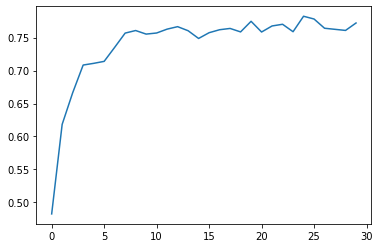

The model accuracy improved from:  0.7108705639839172 to:  0.7138776183128357
-------------------------------------------------------------------------
Epoch 7 / 30 : 
Training: 
Epoch 7/7
1769/1769 [==============================] - 318s 180ms/step - loss: 0.7202 - acc: 0.8048
Validation: 
208/208 [==============================] - 36s 173ms/step - loss: 0.9389 - acc: 0.7346


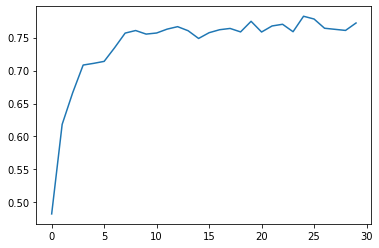

The model accuracy improved from:  0.7138776183128357 to:  0.7346263527870178
-------------------------------------------------------------------------
Epoch 8 / 30 : 
Training: 
Epoch 8/8
1769/1769 [==============================] - 317s 179ms/step - loss: 0.7284 - acc: 0.8197
Validation: 
208/208 [==============================] - 36s 172ms/step - loss: 0.9755 - acc: 0.7566


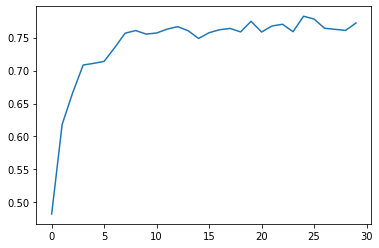

The model accuracy improved from:  0.7346263527870178 to:  0.7565779685974121
-------------------------------------------------------------------------
Epoch 9 / 30 : 
Training: 
Epoch 9/9
1769/1769 [==============================] - 317s 179ms/step - loss: 0.6407 - acc: 0.8352
Validation: 
208/208 [==============================] - 36s 172ms/step - loss: 0.9479 - acc: 0.7418


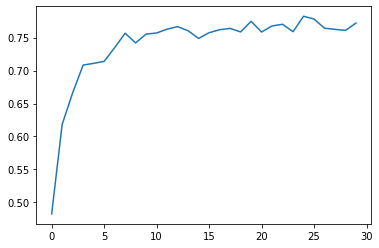

The model accuracy did not improve, patience_i =  1
-------------------------------------------------------------------------
Epoch 10 / 30 : 
Training: 
Epoch 10/10
1769/1769 [==============================] - 317s 179ms/step - loss: 0.6297 - acc: 0.8406
Validation: 
208/208 [==============================] - 36s 172ms/step - loss: 0.9159 - acc: 0.7588


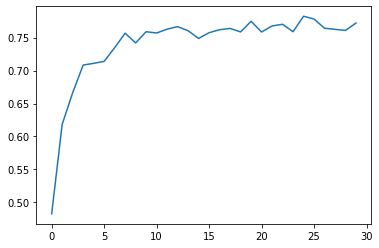

The model accuracy improved from:  0.7565779685974121 to:  0.7588332295417786
-------------------------------------------------------------------------
Epoch 11 / 30 : 
Training: 
Epoch 11/11
1769/1769 [==============================] - 316s 178ms/step - loss: 0.7736 - acc: 0.8507
Validation: 
208/208 [==============================] - 36s 172ms/step - loss: 0.9237 - acc: 0.7467


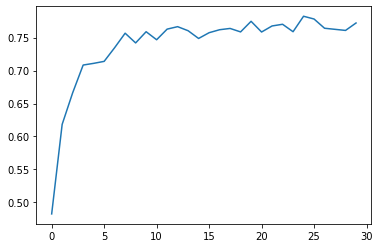

The model accuracy did not improve, patience_i =  1
-------------------------------------------------------------------------
Epoch 12 / 30 : 
Training: 
Epoch 12/12
1769/1769 [==============================] - 316s 178ms/step - loss: 0.5912 - acc: 0.8563
Validation: 
208/208 [==============================] - 36s 173ms/step - loss: 1.0862 - acc: 0.7324


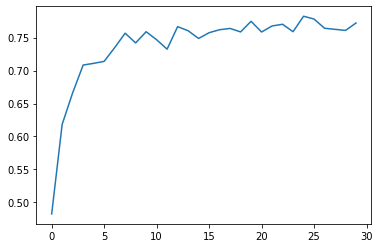

The model accuracy did not improve, patience_i =  2
-------------------------------------------------------------------------
Epoch 13 / 30 : 
Training: 
Epoch 13/13
1769/1769 [==============================] - 317s 179ms/step - loss: 0.5696 - acc: 0.8601
Validation: 
208/208 [==============================] - 36s 172ms/step - loss: 1.0976 - acc: 0.7409


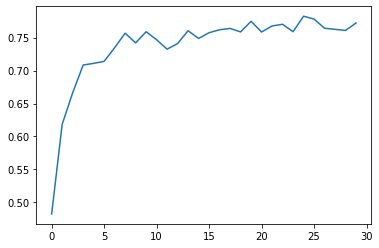

The model accuracy did not improve, patience_i =  3
-------------------------------------------------------------------------
Epoch 14 / 30 : 
Training: 
Epoch 14/14
1769/1769 [==============================] - 317s 179ms/step - loss: 0.5727 - acc: 0.8650
Validation: 
208/208 [==============================] - 36s 174ms/step - loss: 1.0083 - acc: 0.7606


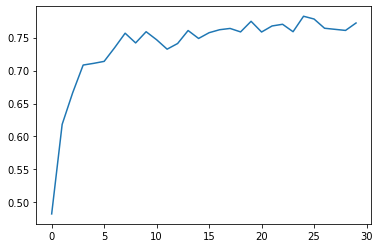

The model accuracy improved from:  0.7588332295417786 to:  0.7606375217437744
-------------------------------------------------------------------------
Epoch 15 / 30 : 
Training: 
Epoch 15/15
1769/1769 [==============================] - 317s 179ms/step - loss: 0.5516 - acc: 0.8658
Validation: 
208/208 [==============================] - 36s 173ms/step - loss: 1.0426 - acc: 0.7642


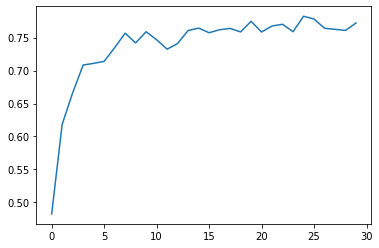

The model accuracy improved from:  0.7606375217437744 to:  0.7642459869384766
-------------------------------------------------------------------------
Epoch 16 / 30 : 
Training: 
Epoch 16/16
1769/1769 [==============================] - 315s 178ms/step - loss: 0.5388 - acc: 0.8686
Validation: 
208/208 [==============================] - 36s 171ms/step - loss: 1.0678 - acc: 0.7739


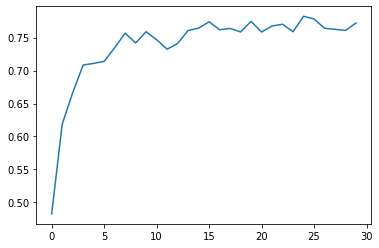

The model accuracy improved from:  0.7642459869384766 to:  0.7738686203956604
-------------------------------------------------------------------------
Epoch 17 / 30 : 
Training: 
Epoch 17/17
1769/1769 [==============================] - 318s 180ms/step - loss: 0.5303 - acc: 0.8707
Validation: 
208/208 [==============================] - 36s 174ms/step - loss: 1.0111 - acc: 0.7782


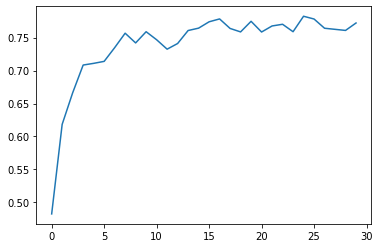

The model accuracy improved from:  0.7738686203956604 to:  0.7782288193702698
-------------------------------------------------------------------------
Epoch 18 / 30 : 
Training: 
Epoch 18/18
1769/1769 [==============================] - 319s 180ms/step - loss: 0.5384 - acc: 0.8695
Validation: 
208/208 [==============================] - 36s 173ms/step - loss: 1.0511 - acc: 0.7673


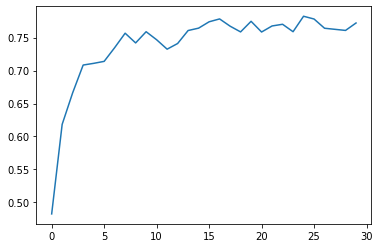

The model accuracy did not improve, patience_i =  1
-------------------------------------------------------------------------
Epoch 19 / 30 : 
Training: 
Epoch 19/19
1769/1769 [==============================] - 318s 180ms/step - loss: 0.5594 - acc: 0.8724
Validation: 
208/208 [==============================] - 36s 174ms/step - loss: 1.2055 - acc: 0.7719


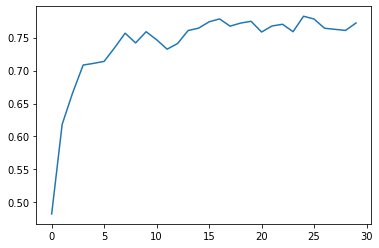

The model accuracy did not improve, patience_i =  2
-------------------------------------------------------------------------
Epoch 20 / 30 : 
Training: 
Epoch 20/20
1769/1769 [==============================] - 350s 198ms/step - loss: 0.5178 - acc: 0.8786
Validation: 
208/208 [==============================] - 36s 173ms/step - loss: 1.0069 - acc: 0.7724


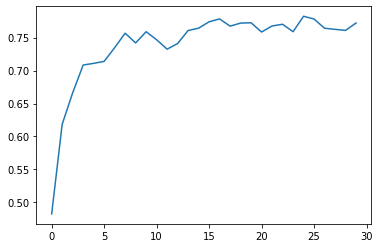

The model accuracy did not improve, patience_i =  3
-------------------------------------------------------------------------
Epoch 21 / 30 : 
Training: 
Epoch 21/21
1769/1769 [==============================] - 319s 180ms/step - loss: 0.5247 - acc: 0.8784
Validation: 
208/208 [==============================] - 36s 174ms/step - loss: 1.1073 - acc: 0.7581


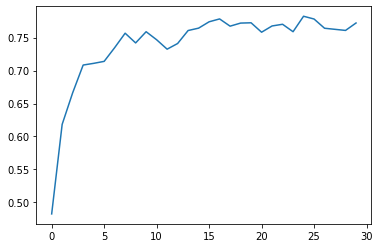

The model accuracy did not improve, patience_i =  4
-------------------------------------------------------------------------
Epoch 22 / 30 : 
Training: 
Epoch 22/22
1769/1769 [==============================] - 318s 180ms/step - loss: 0.5069 - acc: 0.8806
Validation: 
208/208 [==============================] - 37s 176ms/step - loss: 1.0522 - acc: 0.7647


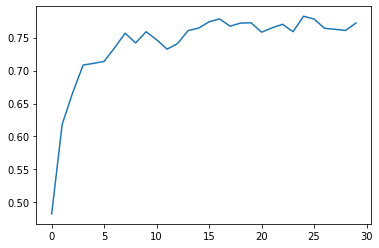

The model accuracy did not improve, patience_i =  5
-------------------------------------------------------------------------
Epoch 23 / 30 : 
Training: 
Epoch 23/23
1769/1769 [==============================] - 352s 199ms/step - loss: 0.5082 - acc: 0.8798
Validation: 
208/208 [==============================] - 36s 174ms/step - loss: 1.1150 - acc: 0.7632


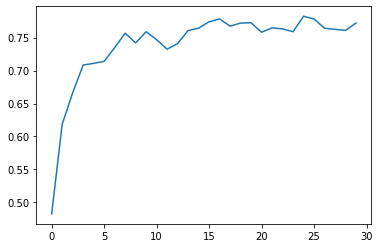

The model accuracy did not improve, patience_i =  6
-------------------------------------------------------------------------
Epoch 24 / 30 : 
Training: 
Epoch 24/24
1769/1769 [==============================] - 319s 180ms/step - loss: 0.6487 - acc: 0.8828
Validation: 
208/208 [==============================] - 36s 175ms/step - loss: 1.0858 - acc: 0.7701


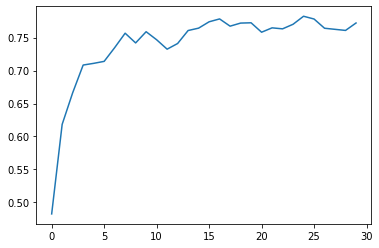

The model accuracy did not improve, patience_i =  7
-------------------------------------------------------------------------
Epoch 25 / 30 : 
Training: 
Epoch 25/25
1769/1769 [==============================] - 350s 198ms/step - loss: 0.5243 - acc: 0.8825
Validation: 
208/208 [==============================] - 36s 173ms/step - loss: 1.0752 - acc: 0.7621


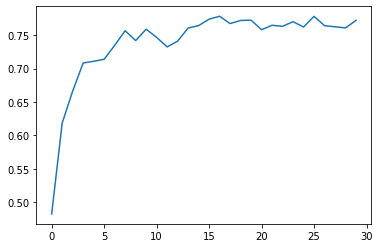

The model accuracy did not improve, patience_i =  8
-------------------------------------------------------------------------
Epoch 26 / 30 : 
Training: 
Epoch 26/26
1769/1769 [==============================] - 318s 180ms/step - loss: 0.5193 - acc: 0.8785
Validation: 
208/208 [==============================] - 37s 177ms/step - loss: 1.2105 - acc: 0.7635


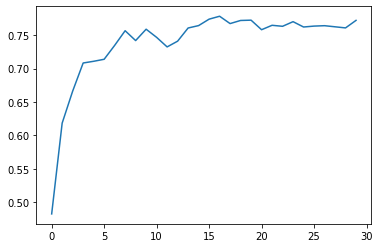

The model accuracy did not improve, patience_i =  9
-------------------------------------------------------------------------
Epoch 27 / 30 : 
Training: 
Epoch 27/27
1769/1769 [==============================] - 318s 180ms/step - loss: 0.5344 - acc: 0.8794
Validation: 
208/208 [==============================] - 36s 175ms/step - loss: 1.4233 - acc: 0.7790


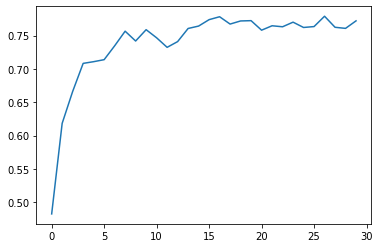

The model accuracy improved from:  0.7782288193702698 to:  0.7789806127548218
-------------------------------------------------------------------------
Epoch 28 / 30 : 
Training: 
Epoch 28/28
1769/1769 [==============================] - 320s 181ms/step - loss: 0.5220 - acc: 0.8792
Validation: 
208/208 [==============================] - 36s 175ms/step - loss: 1.1387 - acc: 0.7570


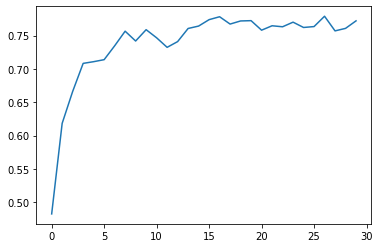

The model accuracy did not improve, patience_i =  1
-------------------------------------------------------------------------
Epoch 29 / 30 : 
Training: 
Epoch 29/29
1769/1769 [==============================] - 319s 181ms/step - loss: 0.5516 - acc: 0.8805
Validation: 
208/208 [==============================] - 36s 174ms/step - loss: 1.3645 - acc: 0.7698


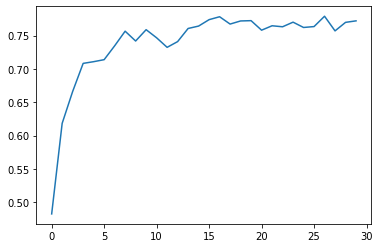

The model accuracy did not improve, patience_i =  2
-------------------------------------------------------------------------
Epoch 30 / 30 : 
Training: 
Epoch 30/30
1769/1769 [==============================] - 351s 198ms/step - loss: 0.7072 - acc: 0.8803
Validation: 
208/208 [==============================] - 36s 175ms/step - loss: 1.1339 - acc: 0.7674


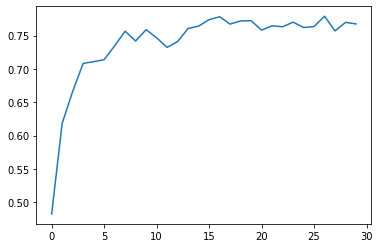

The model accuracy did not improve, patience_i =  3
-------------------------------------------------------------------------
Testing: 
105/105 [==============================] - 21s 201ms/step - loss: 1.1639 - acc: 0.7589
Test Results:  1.1639018058776855 0.7589098811149597
-------------------------------------------------------------------------
Epoch 1 / 30 : 
Training: 
1769/1769 [==============================] - 316s 178ms/step - loss: 1.7464 - acc: 0.3524
Validation: 
208/208 [==============================] - 36s 172ms/step - loss: 1.3826 - acc: 0.5008


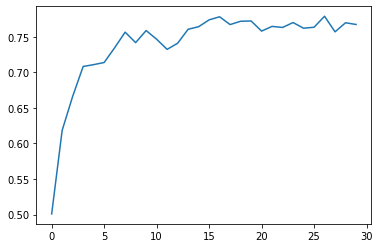

The model accuracy improved from:  0 to:  0.5008269548416138
-------------------------------------------------------------------------
Epoch 2 / 30 : 
Training: 
Epoch 2/2
1769/1769 [==============================] - 315s 178ms/step - loss: 1.3166 - acc: 0.5520
Validation: 
208/208 [==============================] - 36s 172ms/step - loss: 1.1924 - acc: 0.5888


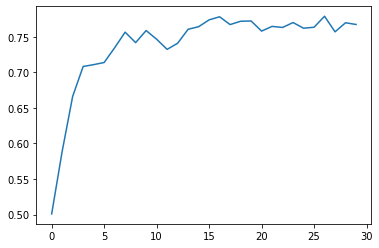

The model accuracy improved from:  0.5008269548416138 to:  0.5887836217880249
-------------------------------------------------------------------------
Epoch 3 / 30 : 
Training: 
Epoch 3/3
1769/1769 [==============================] - 315s 178ms/step - loss: 1.1104 - acc: 0.6491
Validation: 
208/208 [==============================] - 66s 318ms/step - loss: 1.0733 - acc: 0.6509


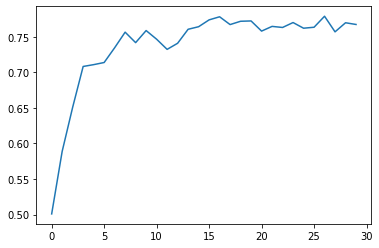

The model accuracy improved from:  0.5887836217880249 to:  0.6508795619010925
-------------------------------------------------------------------------
Epoch 4 / 30 : 
Training: 
Epoch 4/4
1769/1769 [==============================] - 316s 179ms/step - loss: 0.9878 - acc: 0.7105
Validation: 
208/208 [==============================] - 36s 173ms/step - loss: 1.0172 - acc: 0.6778


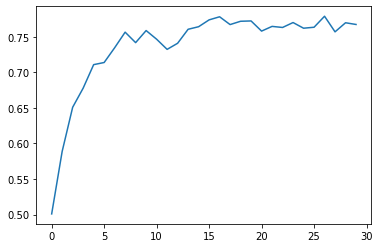

The model accuracy improved from:  0.6508795619010925 to:  0.6777927875518799
-------------------------------------------------------------------------
Epoch 5 / 30 : 
Training: 
Epoch 5/5
1769/1769 [==============================] - 315s 178ms/step - loss: 0.8602 - acc: 0.7544
Validation: 
208/208 [==============================] - 36s 172ms/step - loss: 0.9472 - acc: 0.7188


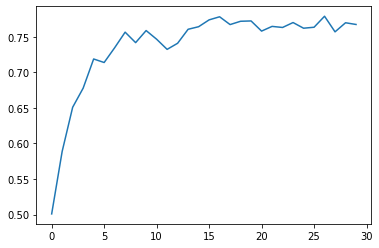

The model accuracy improved from:  0.6777927875518799 to:  0.7188392877578735
-------------------------------------------------------------------------
Epoch 6 / 30 : 
Training: 
Epoch 6/6
1769/1769 [==============================] - 316s 179ms/step - loss: 0.7572 - acc: 0.7847
Validation: 
208/208 [==============================] - 36s 172ms/step - loss: 0.9697 - acc: 0.7170


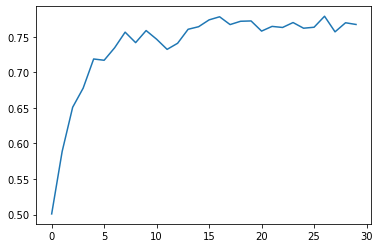

The model accuracy did not improve, patience_i =  1
-------------------------------------------------------------------------
Epoch 7 / 30 : 
Training: 
Epoch 7/7
1769/1769 [==============================] - 315s 178ms/step - loss: 0.6992 - acc: 0.8085
Validation: 
208/208 [==============================] - 36s 172ms/step - loss: 0.9610 - acc: 0.7433


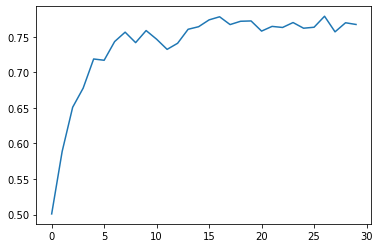

The model accuracy improved from:  0.7188392877578735 to:  0.7433468699455261
-------------------------------------------------------------------------
Epoch 8 / 30 : 
Training: 
Epoch 8/8
1769/1769 [==============================] - 315s 178ms/step - loss: 0.6775 - acc: 0.8250
Validation: 
208/208 [==============================] - 36s 172ms/step - loss: 0.9652 - acc: 0.7426


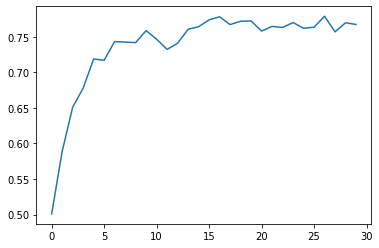

The model accuracy did not improve, patience_i =  1
-------------------------------------------------------------------------
Epoch 9 / 30 : 
Training: 
Epoch 9/9
1769/1769 [==============================] - 315s 178ms/step - loss: 0.6200 - acc: 0.8390
Validation: 
208/208 [==============================] - 36s 172ms/step - loss: 1.0054 - acc: 0.7566


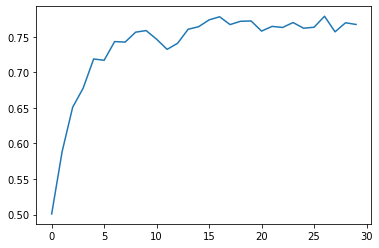

The model accuracy improved from:  0.7433468699455261 to:  0.7565779685974121
-------------------------------------------------------------------------
Epoch 10 / 30 : 
Training: 
Epoch 10/10
1769/1769 [==============================] - 315s 178ms/step - loss: 0.6484 - acc: 0.8489
Validation: 
208/208 [==============================] - 36s 173ms/step - loss: 1.0333 - acc: 0.7551


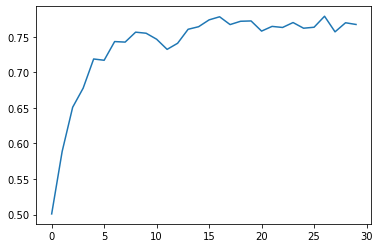

The model accuracy did not improve, patience_i =  1
-------------------------------------------------------------------------
Epoch 11 / 30 : 
Training: 
Epoch 11/11
1769/1769 [==============================] - 315s 178ms/step - loss: 0.5754 - acc: 0.8580
Validation: 
208/208 [==============================] - 36s 172ms/step - loss: 1.0008 - acc: 0.7627


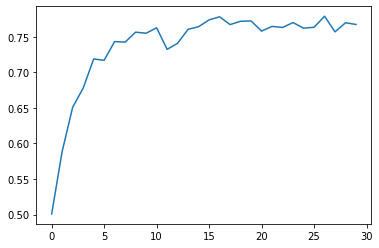

The model accuracy improved from:  0.7565779685974121 to:  0.7627424597740173
-------------------------------------------------------------------------
Epoch 12 / 30 : 
Training: 
Epoch 12/12
1769/1769 [==============================] - 316s 178ms/step - loss: 0.6623 - acc: 0.8635
Validation: 
208/208 [==============================] - 36s 172ms/step - loss: 1.0476 - acc: 0.7540


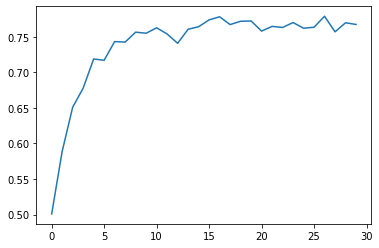

The model accuracy did not improve, patience_i =  1
-------------------------------------------------------------------------
Epoch 13 / 30 : 
Training: 
Epoch 13/13
1769/1769 [==============================] - 316s 179ms/step - loss: 0.5433 - acc: 0.8681
Validation: 
208/208 [==============================] - 36s 172ms/step - loss: 1.0351 - acc: 0.7661


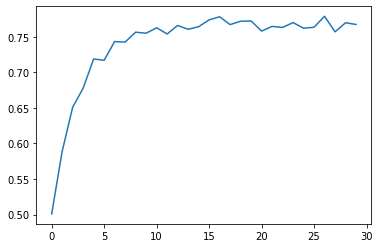

The model accuracy improved from:  0.7627424597740173 to:  0.7660502195358276
-------------------------------------------------------------------------
Epoch 14 / 30 : 
Training: 
Epoch 14/14
1769/1769 [==============================] - 315s 178ms/step - loss: 0.6446 - acc: 0.8746
Validation: 
208/208 [==============================] - 36s 172ms/step - loss: 1.1206 - acc: 0.7763


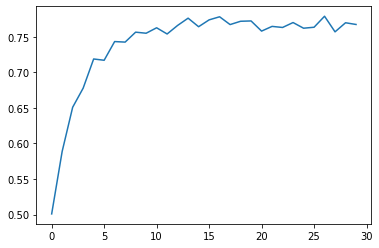

The model accuracy improved from:  0.7660502195358276 to:  0.7762742638587952
-------------------------------------------------------------------------
Epoch 15 / 30 : 
Training: 
Epoch 15/15
1769/1769 [==============================] - 316s 179ms/step - loss: 0.5290 - acc: 0.8741
Validation: 
208/208 [==============================] - 36s 173ms/step - loss: 1.0831 - acc: 0.7534


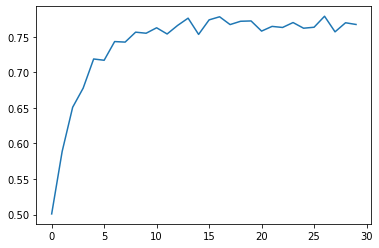

The model accuracy did not improve, patience_i =  1
-------------------------------------------------------------------------
Epoch 16 / 30 : 
Training: 
Epoch 16/16
1769/1769 [==============================] - 316s 178ms/step - loss: 0.6091 - acc: 0.8762
Validation: 
208/208 [==============================] - 36s 172ms/step - loss: 1.0787 - acc: 0.7558


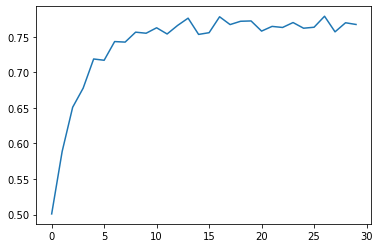

The model accuracy did not improve, patience_i =  2
-------------------------------------------------------------------------
Epoch 17 / 30 : 
Training: 
Epoch 17/17
1769/1769 [==============================] - 316s 179ms/step - loss: 0.5335 - acc: 0.8781
Validation: 
208/208 [==============================] - 36s 172ms/step - loss: 1.2599 - acc: 0.7473


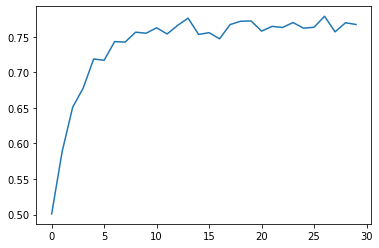

The model accuracy did not improve, patience_i =  3
-------------------------------------------------------------------------
Epoch 18 / 30 : 
Training: 
Epoch 18/18
1769/1769 [==============================] - 315s 178ms/step - loss: 0.5580 - acc: 0.8770
Validation: 
208/208 [==============================] - 36s 172ms/step - loss: 1.0154 - acc: 0.7575


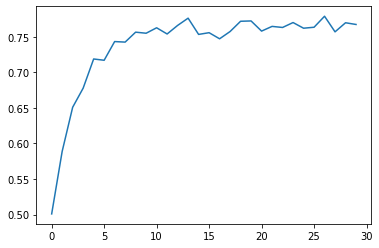

The model accuracy did not improve, patience_i =  4
-------------------------------------------------------------------------
Epoch 19 / 30 : 
Training: 
Epoch 19/19
1769/1769 [==============================] - 316s 179ms/step - loss: 0.5191 - acc: 0.8822
Validation: 
208/208 [==============================] - 36s 172ms/step - loss: 1.0984 - acc: 0.7615


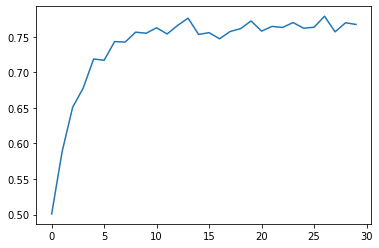

The model accuracy did not improve, patience_i =  5
-------------------------------------------------------------------------
Epoch 20 / 30 : 
Training: 
Epoch 20/20
1769/1769 [==============================] - 316s 179ms/step - loss: 0.5927 - acc: 0.8817
Validation: 
208/208 [==============================] - 36s 171ms/step - loss: 1.1444 - acc: 0.7670


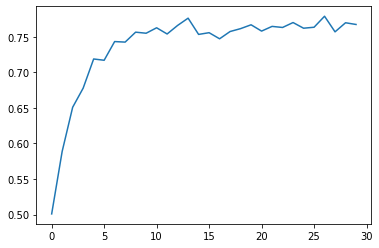

The model accuracy did not improve, patience_i =  6
-------------------------------------------------------------------------
Epoch 21 / 30 : 
Training: 
Epoch 21/21
1769/1769 [==============================] - 316s 179ms/step - loss: 0.6114 - acc: 0.8788
Validation: 
208/208 [==============================] - 36s 172ms/step - loss: 1.3107 - acc: 0.7670


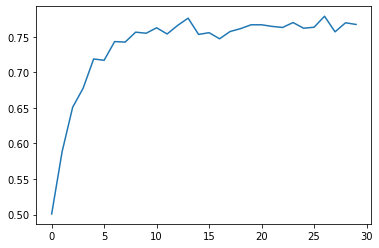

The model accuracy did not improve, patience_i =  7
-------------------------------------------------------------------------
Epoch 22 / 30 : 
Training: 
Epoch 22/22
1769/1769 [==============================] - 316s 179ms/step - loss: 0.5164 - acc: 0.8819
Validation: 
208/208 [==============================] - 36s 172ms/step - loss: 1.1826 - acc: 0.7503


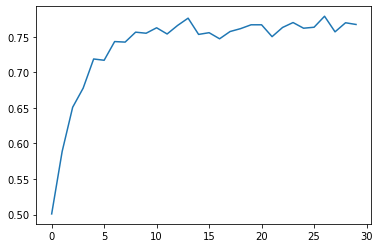

The model accuracy did not improve, patience_i =  8
-------------------------------------------------------------------------
Epoch 23 / 30 : 
Training: 
Epoch 23/23
1769/1769 [==============================] - 316s 179ms/step - loss: 0.5253 - acc: 0.8802
Validation: 
208/208 [==============================] - 36s 171ms/step - loss: 1.1288 - acc: 0.7554


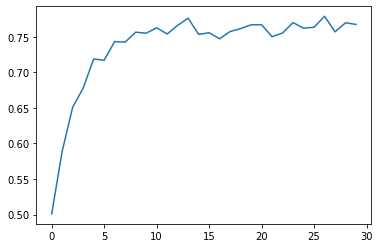

The model accuracy did not improve, patience_i =  9
-------------------------------------------------------------------------
Epoch 24 / 30 : 
Training: 
Epoch 24/24
1769/1769 [==============================] - 346s 196ms/step - loss: 0.5789 - acc: 0.8817
Validation: 
208/208 [==============================] - 36s 173ms/step - loss: 1.1275 - acc: 0.7569


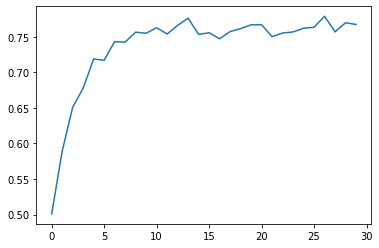

The model accuracy did not improve, patience_i =  10
-------------------------------------------------------------------------
Epoch 25 / 30 : 
Training: 
Epoch 25/25
1769/1769 [==============================] - 315s 178ms/step - loss: 0.5126 - acc: 0.8812
Validation: 
208/208 [==============================] - 36s 172ms/step - loss: 1.0360 - acc: 0.7641


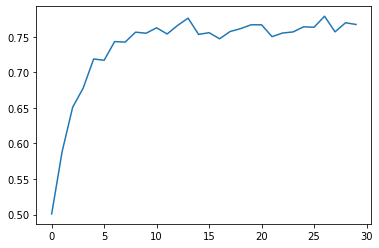

The model accuracy did not improve, patience_i =  11
Early Stopping, the model did not improve from an accuracy:  inf
-------------------------------------------------------------------------
Testing: 
105/105 [==============================] - 20s 189ms/step - loss: 1.0559 - acc: 0.7478
Test Results:  1.0559215545654297 0.7478286623954773
-------------------------------------------------------------------------
Epoch 1 / 30 : 
Training: 
1769/1769 [==============================] - 315s 178ms/step - loss: 1.7407 - acc: 0.3676
Validation: 
208/208 [==============================] - 36s 172ms/step - loss: 1.4248 - acc: 0.4855


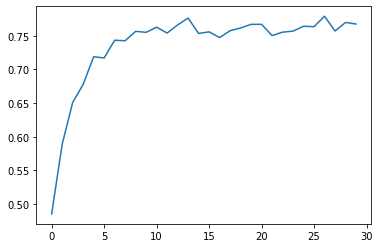

The model accuracy improved from:  0 to:  0.48549091815948486
-------------------------------------------------------------------------
Epoch 2 / 30 : 
Training: 
Epoch 2/2
1769/1769 [==============================] - 347s 196ms/step - loss: 1.3074 - acc: 0.5540
Validation: 
208/208 [==============================] - 36s 172ms/step - loss: 1.1810 - acc: 0.6011


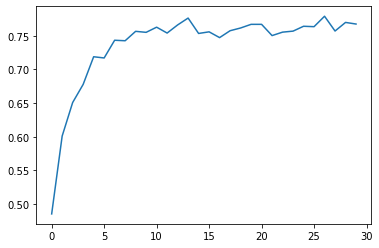

The model accuracy improved from:  0.48549091815948486 to:  0.6011126041412354
-------------------------------------------------------------------------
Epoch 3 / 30 : 
Training: 
Epoch 3/3
1769/1769 [==============================] - 316s 178ms/step - loss: 1.1084 - acc: 0.6460
Validation: 
208/208 [==============================] - 36s 171ms/step - loss: 1.0938 - acc: 0.6504


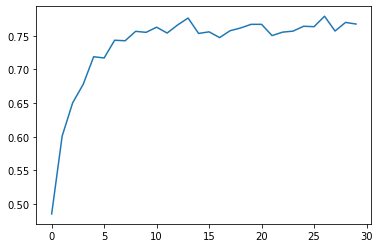

The model accuracy improved from:  0.6011126041412354 to:  0.6504285335540771
-------------------------------------------------------------------------
Epoch 4 / 30 : 
Training: 
Epoch 4/4
1769/1769 [==============================] - 346s 196ms/step - loss: 0.9677 - acc: 0.7060
Validation: 
208/208 [==============================] - 36s 173ms/step - loss: 0.9876 - acc: 0.6951


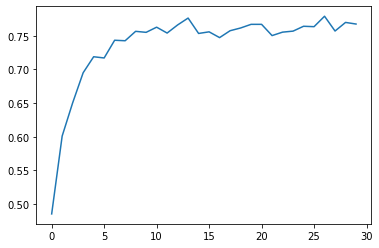

The model accuracy improved from:  0.6504285335540771 to:  0.6950834393501282
-------------------------------------------------------------------------
Epoch 5 / 30 : 
Training: 
Epoch 5/5
1769/1769 [==============================] - 315s 178ms/step - loss: 0.8796 - acc: 0.7482
Validation: 
208/208 [==============================] - 36s 174ms/step - loss: 0.9397 - acc: 0.7252


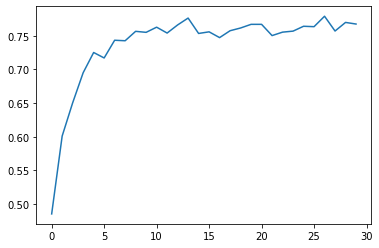

The model accuracy improved from:  0.6950834393501282 to:  0.7251541018486023
-------------------------------------------------------------------------
Epoch 6 / 30 : 
Training: 
Epoch 6/6
1769/1769 [==============================] - 347s 196ms/step - loss: 0.8205 - acc: 0.7817
Validation: 
208/208 [==============================] - 36s 171ms/step - loss: 0.9263 - acc: 0.7321


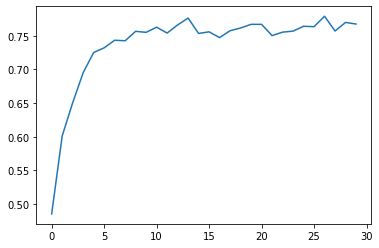

The model accuracy improved from:  0.7251541018486023 to:  0.7320703864097595
-------------------------------------------------------------------------
Epoch 7 / 30 : 
Training: 
Epoch 7/7
1769/1769 [==============================] - 347s 196ms/step - loss: 0.7387 - acc: 0.8031
Validation: 
208/208 [==============================] - 36s 172ms/step - loss: 1.0807 - acc: 0.7330


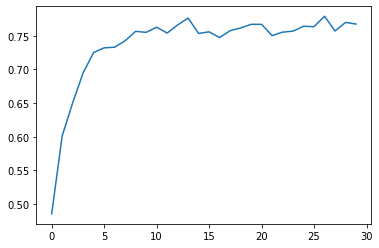

The model accuracy improved from:  0.7320703864097595 to:  0.7329725027084351
-------------------------------------------------------------------------
Epoch 8 / 30 : 
Training: 
Epoch 8/8
1769/1769 [==============================] - 315s 178ms/step - loss: 0.6669 - acc: 0.8234
Validation: 
208/208 [==============================] - 36s 171ms/step - loss: 1.0592 - acc: 0.7369


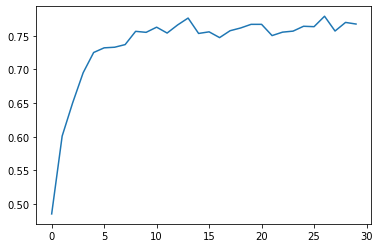

The model accuracy improved from:  0.7329725027084351 to:  0.736881673336029
-------------------------------------------------------------------------
Epoch 9 / 30 : 
Training: 
Epoch 9/9
1769/1769 [==============================] - 315s 178ms/step - loss: 0.6560 - acc: 0.8369
Validation: 
208/208 [==============================] - 36s 172ms/step - loss: 1.0097 - acc: 0.7438


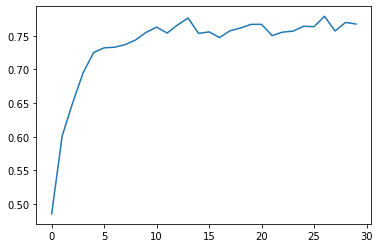

The model accuracy improved from:  0.736881673336029 to:  0.7437978982925415
-------------------------------------------------------------------------
Epoch 10 / 30 : 
Training: 
Epoch 10/10
1769/1769 [==============================] - 315s 178ms/step - loss: 0.6503 - acc: 0.8470
Validation: 
208/208 [==============================] - 36s 172ms/step - loss: 0.9873 - acc: 0.7489


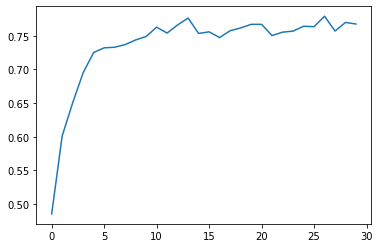

The model accuracy improved from:  0.7437978982925415 to:  0.7489099502563477
-------------------------------------------------------------------------
Epoch 11 / 30 : 
Training: 
Epoch 11/11
1769/1769 [==============================] - 315s 178ms/step - loss: 0.5911 - acc: 0.8533
Validation: 
208/208 [==============================] - 36s 172ms/step - loss: 1.0910 - acc: 0.7406


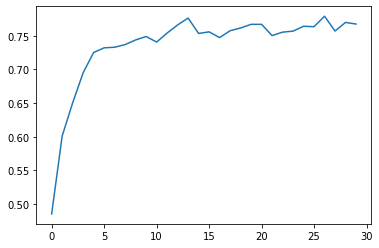

The model accuracy did not improve, patience_i =  1
-------------------------------------------------------------------------
Epoch 12 / 30 : 
Training: 
Epoch 12/12
1769/1769 [==============================] - 315s 178ms/step - loss: 0.5670 - acc: 0.8629
Validation: 
208/208 [==============================] - 36s 172ms/step - loss: 1.0708 - acc: 0.7512


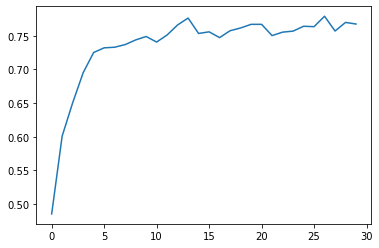

The model accuracy improved from:  0.7489099502563477 to:  0.7511652112007141
-------------------------------------------------------------------------
Epoch 13 / 30 : 
Training: 
Epoch 13/13
1769/1769 [==============================] - 316s 178ms/step - loss: 0.5649 - acc: 0.8691
Validation: 
208/208 [==============================] - 36s 171ms/step - loss: 1.1252 - acc: 0.7461


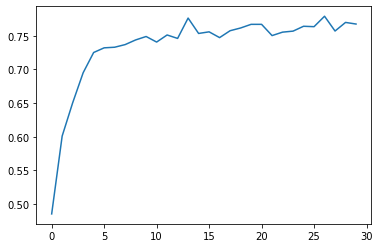

The model accuracy did not improve, patience_i =  1
-------------------------------------------------------------------------
Epoch 14 / 30 : 
Training: 
Epoch 14/14
1769/1769 [==============================] - 315s 178ms/step - loss: 0.5761 - acc: 0.8710
Validation: 
208/208 [==============================] - 36s 171ms/step - loss: 1.2400 - acc: 0.7534


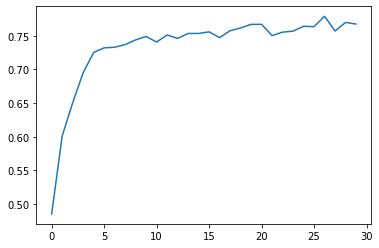

The model accuracy improved from:  0.7511652112007141 to:  0.7534205317497253
-------------------------------------------------------------------------
Epoch 15 / 30 : 
Training: 
Epoch 15/15
1769/1769 [==============================] - 316s 178ms/step - loss: 0.5609 - acc: 0.8751
Validation: 
208/208 [==============================] - 36s 172ms/step - loss: 1.0564 - acc: 0.7667


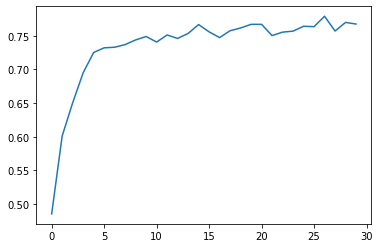

The model accuracy improved from:  0.7534205317497253 to:  0.7666516304016113
-------------------------------------------------------------------------
Epoch 16 / 30 : 
Training: 
Epoch 16/16
1769/1769 [==============================] - 315s 178ms/step - loss: 0.5566 - acc: 0.8792
Validation: 
208/208 [==============================] - 36s 172ms/step - loss: 1.0277 - acc: 0.7653


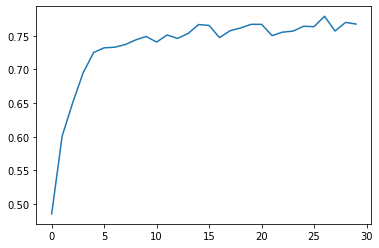

The model accuracy did not improve, patience_i =  1
-------------------------------------------------------------------------
Epoch 17 / 30 : 
Training: 
Epoch 17/17
1769/1769 [==============================] - 316s 179ms/step - loss: 0.7422 - acc: 0.8806
Validation: 
208/208 [==============================] - 36s 172ms/step - loss: 1.2077 - acc: 0.7594


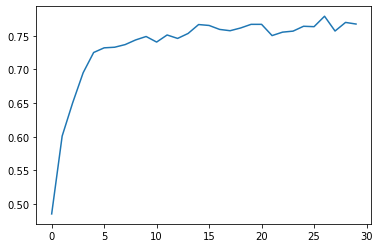

The model accuracy did not improve, patience_i =  2
-------------------------------------------------------------------------
Epoch 18 / 30 : 
Training: 
Epoch 18/18
1769/1769 [==============================] - 315s 178ms/step - loss: 0.5360 - acc: 0.8829
Validation: 
208/208 [==============================] - 36s 174ms/step - loss: 1.1173 - acc: 0.7674


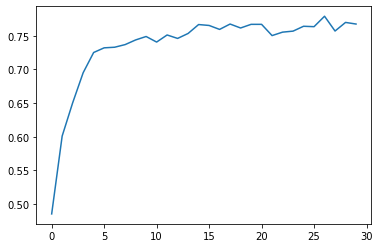

The model accuracy improved from:  0.7666516304016113 to:  0.7674034237861633
-------------------------------------------------------------------------
Epoch 19 / 30 : 
Training: 
Epoch 19/19
1769/1769 [==============================] - 316s 179ms/step - loss: 0.5746 - acc: 0.8820
Validation: 
208/208 [==============================] - 36s 172ms/step - loss: 1.0512 - acc: 0.7605


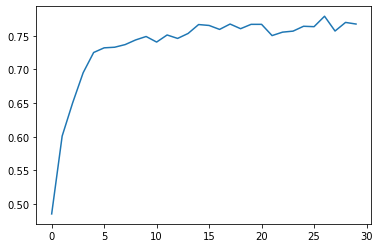

The model accuracy did not improve, patience_i =  1
-------------------------------------------------------------------------
Epoch 20 / 30 : 
Training: 
Epoch 20/20
1769/1769 [==============================] - 316s 179ms/step - loss: 0.5086 - acc: 0.8852
Validation: 
208/208 [==============================] - 36s 173ms/step - loss: 1.1923 - acc: 0.7593


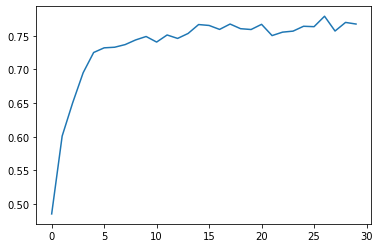

The model accuracy did not improve, patience_i =  2
-------------------------------------------------------------------------
Epoch 21 / 30 : 
Training: 
Epoch 21/21
1769/1769 [==============================] - 315s 178ms/step - loss: 0.5024 - acc: 0.8845
Validation: 
208/208 [==============================] - 36s 172ms/step - loss: 1.3125 - acc: 0.7596


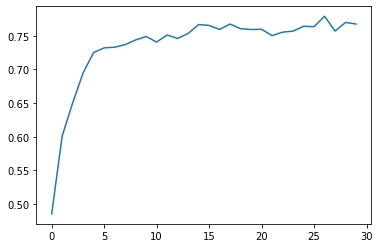

The model accuracy did not improve, patience_i =  3
-------------------------------------------------------------------------
Epoch 22 / 30 : 
Training: 
Epoch 22/22
1769/1769 [==============================] - 315s 178ms/step - loss: 0.4910 - acc: 0.8848
Validation: 
208/208 [==============================] - 36s 171ms/step - loss: 1.0532 - acc: 0.7609


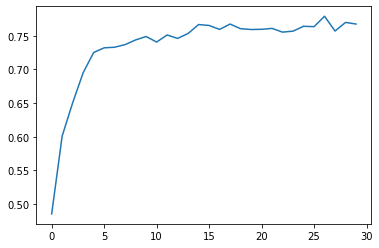

The model accuracy did not improve, patience_i =  4
-------------------------------------------------------------------------
Epoch 23 / 30 : 
Training: 
Epoch 23/23
1769/1769 [==============================] - 315s 178ms/step - loss: 0.5039 - acc: 0.8858
Validation: 
208/208 [==============================] - 36s 171ms/step - loss: 1.2071 - acc: 0.7491


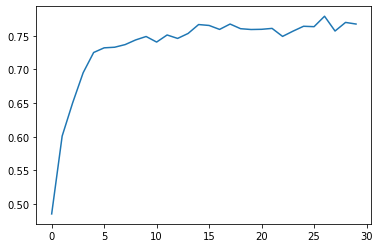

The model accuracy did not improve, patience_i =  5
-------------------------------------------------------------------------
Epoch 24 / 30 : 
Training: 
Epoch 24/24
1769/1769 [==============================] - 315s 178ms/step - loss: 0.6376 - acc: 0.8849
Validation: 
208/208 [==============================] - 36s 172ms/step - loss: 1.1945 - acc: 0.7650


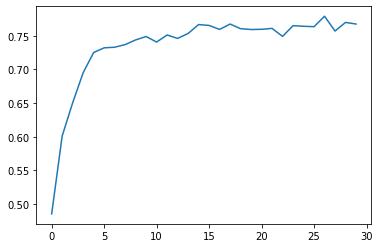

The model accuracy did not improve, patience_i =  6
-------------------------------------------------------------------------
Epoch 25 / 30 : 
Training: 
Epoch 25/25
1769/1769 [==============================] - 315s 178ms/step - loss: 0.5086 - acc: 0.8879
Validation: 
208/208 [==============================] - 36s 172ms/step - loss: 1.1994 - acc: 0.7645


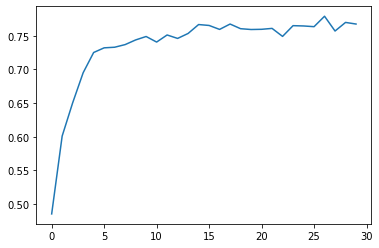

The model accuracy did not improve, patience_i =  7
-------------------------------------------------------------------------
Epoch 26 / 30 : 
Training: 
Epoch 26/26
1769/1769 [==============================] - 315s 178ms/step - loss: 0.5325 - acc: 0.8914
Validation: 
208/208 [==============================] - 36s 172ms/step - loss: 1.1711 - acc: 0.7593


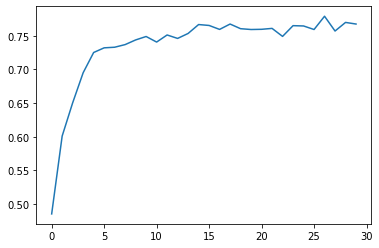

The model accuracy did not improve, patience_i =  8
-------------------------------------------------------------------------
Epoch 27 / 30 : 
Training: 
Epoch 27/27
1769/1769 [==============================] - 315s 178ms/step - loss: 0.5909 - acc: 0.8886
Validation: 
208/208 [==============================] - 36s 172ms/step - loss: 1.1693 - acc: 0.7548


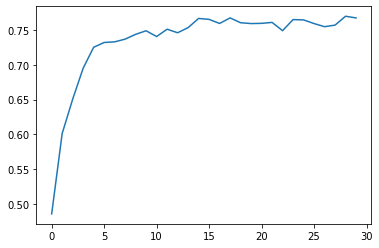

The model accuracy did not improve, patience_i =  9
-------------------------------------------------------------------------
Epoch 28 / 30 : 
Training: 
Epoch 28/28
1769/1769 [==============================] - 315s 178ms/step - loss: 0.4853 - acc: 0.8900
Validation: 
208/208 [==============================] - 36s 172ms/step - loss: 1.2006 - acc: 0.7647


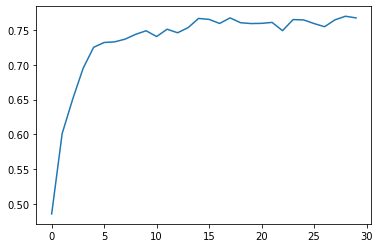

The model accuracy did not improve, patience_i =  10
-------------------------------------------------------------------------
Epoch 29 / 30 : 
Training: 
Epoch 29/29
1769/1769 [==============================] - 346s 195ms/step - loss: 0.5090 - acc: 0.8877
Validation: 
208/208 [==============================] - 36s 172ms/step - loss: 1.0739 - acc: 0.7703


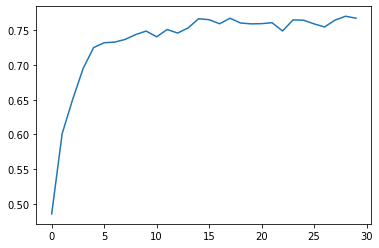

The model accuracy improved from:  0.7674034237861633 to:  0.7702600955963135
-------------------------------------------------------------------------
Epoch 30 / 30 : 
Training: 
Epoch 30/30
1769/1769 [==============================] - 346s 196ms/step - loss: 0.5136 - acc: 0.8890
Validation: 
208/208 [==============================] - 36s 172ms/step - loss: 1.1440 - acc: 0.7721


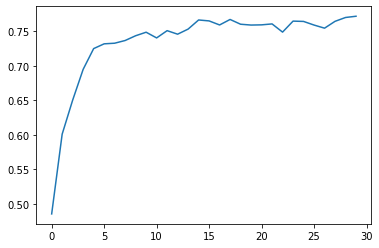

The model accuracy improved from:  0.7702600955963135 to:  0.7720643281936646
-------------------------------------------------------------------------
Testing: 
105/105 [==============================] - 20s 193ms/step - loss: 1.2065 - acc: 0.7616
Test Results:  1.206514596939087 0.7616052627563477
-------------------------------------------------------------------------
Epoch 1 / 30 : 
Training: 
1769/1769 [==============================] - 315s 178ms/step - loss: 1.8445 - acc: 0.3570
Validation: 
208/208 [==============================] - 36s 172ms/step - loss: 1.5662 - acc: 0.4685


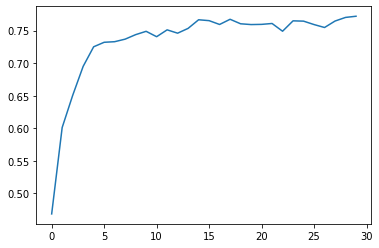

The model accuracy improved from:  0 to:  0.4685009717941284
-------------------------------------------------------------------------
Epoch 2 / 30 : 
Training: 
Epoch 2/2
1769/1769 [==============================] - 315s 178ms/step - loss: 1.3257 - acc: 0.5436
Validation: 
208/208 [==============================] - 36s 171ms/step - loss: 1.2268 - acc: 0.5937


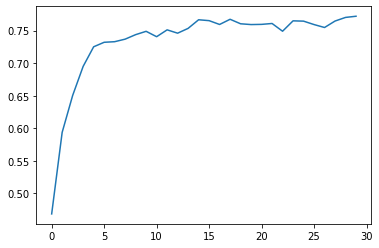

The model accuracy improved from:  0.4685009717941284 to:  0.5937452912330627
-------------------------------------------------------------------------
Epoch 3 / 30 : 
Training: 
Epoch 3/3
1769/1769 [==============================] - 315s 178ms/step - loss: 1.1436 - acc: 0.6371
Validation: 
208/208 [==============================] - 36s 172ms/step - loss: 1.1001 - acc: 0.6560


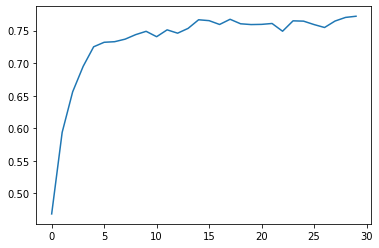

The model accuracy improved from:  0.5937452912330627 to:  0.6559915542602539
-------------------------------------------------------------------------
Epoch 4 / 30 : 
Training: 
Epoch 4/4
1769/1769 [==============================] - 315s 178ms/step - loss: 1.1036 - acc: 0.6989
Validation: 
208/208 [==============================] - 36s 171ms/step - loss: 1.0490 - acc: 0.6766


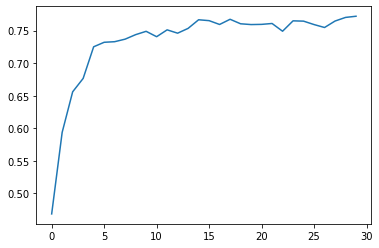

The model accuracy improved from:  0.6559915542602539 to:  0.6765899658203125
-------------------------------------------------------------------------
Epoch 5 / 30 : 
Training: 
Epoch 5/5
1769/1769 [==============================] - 316s 179ms/step - loss: 0.9423 - acc: 0.7373
Validation: 
208/208 [==============================] - 36s 172ms/step - loss: 0.9911 - acc: 0.7035


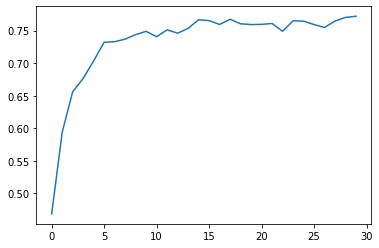

The model accuracy improved from:  0.6765899658203125 to:  0.7035032510757446
-------------------------------------------------------------------------
Epoch 6 / 30 : 
Training: 
Epoch 6/6
1769/1769 [==============================] - 348s 197ms/step - loss: 0.8166 - acc: 0.7682
Validation: 
208/208 [==============================] - 36s 172ms/step - loss: 0.9981 - acc: 0.7224


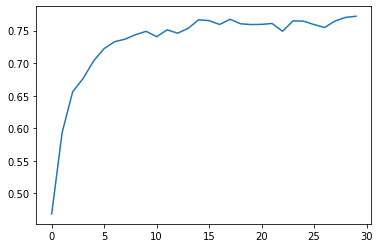

The model accuracy improved from:  0.7035032510757446 to:  0.7224477529525757
-------------------------------------------------------------------------
Epoch 7 / 30 : 
Training: 
Epoch 7/7
1769/1769 [==============================] - 316s 179ms/step - loss: 0.7967 - acc: 0.7926
Validation: 
208/208 [==============================] - 36s 173ms/step - loss: 1.0239 - acc: 0.7241


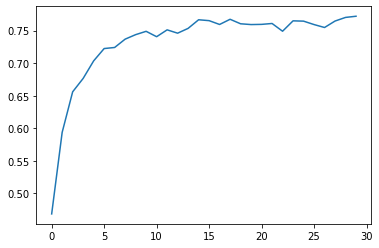

The model accuracy improved from:  0.7224477529525757 to:  0.7241016626358032
-------------------------------------------------------------------------
Epoch 8 / 30 : 
Training: 
Epoch 8/8
1769/1769 [==============================] - 316s 179ms/step - loss: 0.7339 - acc: 0.8123
Validation: 
208/208 [==============================] - 36s 171ms/step - loss: 0.9697 - acc: 0.7519


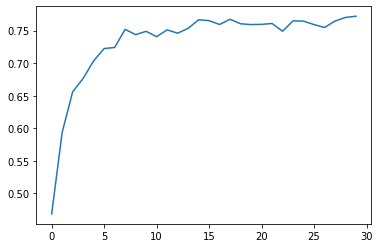

The model accuracy improved from:  0.7241016626358032 to:  0.7519170045852661
-------------------------------------------------------------------------
Epoch 9 / 30 : 
Training: 
Epoch 9/9
1769/1769 [==============================] - 316s 179ms/step - loss: 0.7635 - acc: 0.8265
Validation: 
208/208 [==============================] - 36s 171ms/step - loss: 1.0023 - acc: 0.7506


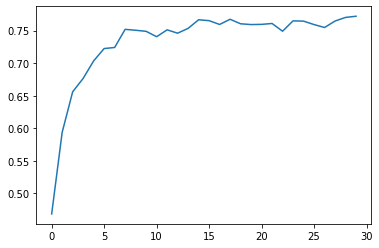

The model accuracy did not improve, patience_i =  1
-------------------------------------------------------------------------
Epoch 10 / 30 : 
Training: 
Epoch 10/10
1769/1769 [==============================] - 315s 178ms/step - loss: 0.6646 - acc: 0.8378
Validation: 
208/208 [==============================] - 36s 171ms/step - loss: 0.9606 - acc: 0.7585


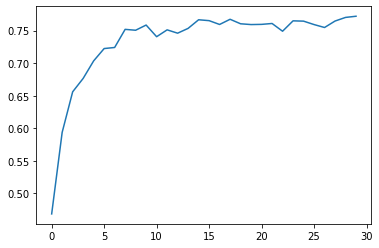

The model accuracy improved from:  0.7519170045852661 to:  0.7585325241088867
-------------------------------------------------------------------------
Epoch 11 / 30 : 
Training: 
Epoch 11/11
1769/1769 [==============================] - 315s 178ms/step - loss: 0.6791 - acc: 0.8473
Validation: 
208/208 [==============================] - 36s 172ms/step - loss: 0.9782 - acc: 0.7471


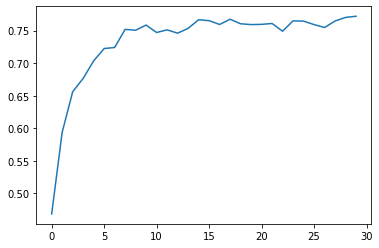

The model accuracy did not improve, patience_i =  1
-------------------------------------------------------------------------
Epoch 12 / 30 : 
Training: 
Epoch 12/12
1769/1769 [==============================] - 345s 195ms/step - loss: 0.6408 - acc: 0.8527
Validation: 
208/208 [==============================] - 36s 171ms/step - loss: 0.9693 - acc: 0.7584


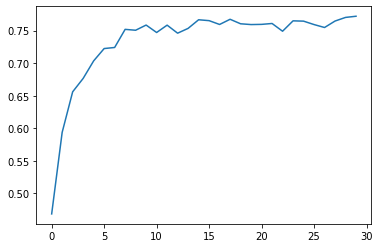

The model accuracy did not improve, patience_i =  2
-------------------------------------------------------------------------
Epoch 13 / 30 : 
Training: 
Epoch 13/13
1769/1769 [==============================] - 315s 178ms/step - loss: 0.5719 - acc: 0.8616
Validation: 
208/208 [==============================] - 36s 172ms/step - loss: 1.1132 - acc: 0.7471


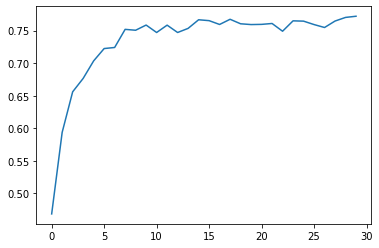

The model accuracy did not improve, patience_i =  3
-------------------------------------------------------------------------
Epoch 14 / 30 : 
Training: 
Epoch 14/14
1769/1769 [==============================] - 316s 179ms/step - loss: 0.6146 - acc: 0.8660
Validation: 
208/208 [==============================] - 36s 172ms/step - loss: 1.0234 - acc: 0.7606


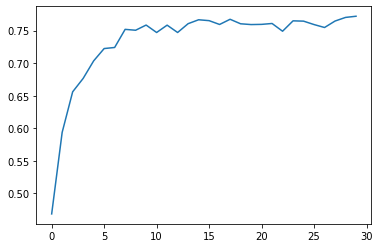

The model accuracy improved from:  0.7585325241088867 to:  0.7606375217437744
-------------------------------------------------------------------------
Epoch 15 / 30 : 
Training: 
Epoch 15/15
1769/1769 [==============================] - 316s 178ms/step - loss: 0.5595 - acc: 0.8701
Validation: 
208/208 [==============================] - 36s 172ms/step - loss: 1.2014 - acc: 0.7483


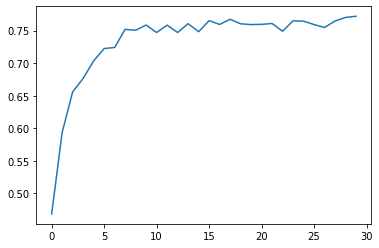

The model accuracy did not improve, patience_i =  1
-------------------------------------------------------------------------
Epoch 16 / 30 : 
Training: 
Epoch 16/16
1769/1769 [==============================] - 316s 178ms/step - loss: 0.5445 - acc: 0.8739
Validation: 
208/208 [==============================] - 36s 173ms/step - loss: 1.0680 - acc: 0.7688


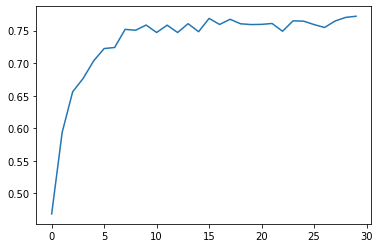

The model accuracy improved from:  0.7606375217437744 to:  0.7687565684318542
-------------------------------------------------------------------------
Epoch 17 / 30 : 
Training: 
Epoch 17/17
1769/1769 [==============================] - 316s 179ms/step - loss: 0.5404 - acc: 0.8747
Validation: 
208/208 [==============================] - 36s 171ms/step - loss: 1.2354 - acc: 0.7665


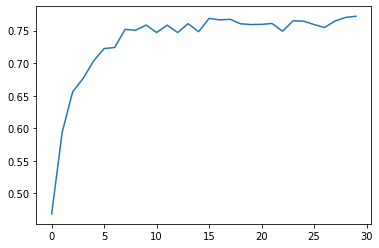

The model accuracy did not improve, patience_i =  1
-------------------------------------------------------------------------
Epoch 18 / 30 : 
Training: 
Epoch 18/18
1769/1769 [==============================] - 315s 178ms/step - loss: 0.5226 - acc: 0.8784
Validation: 
208/208 [==============================] - 36s 172ms/step - loss: 1.0411 - acc: 0.7662


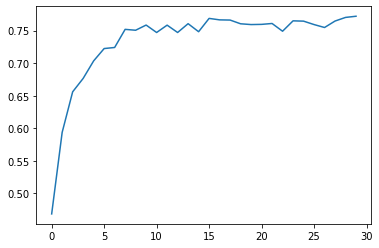

The model accuracy did not improve, patience_i =  2
-------------------------------------------------------------------------
Epoch 19 / 30 : 
Training: 
Epoch 19/19
1769/1769 [==============================] - 315s 178ms/step - loss: 0.5595 - acc: 0.8809
Validation: 
208/208 [==============================] - 36s 172ms/step - loss: 1.1296 - acc: 0.7618


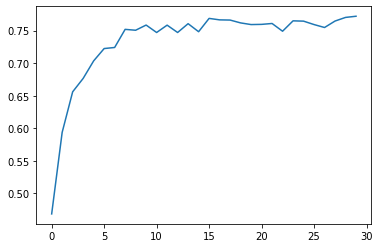

The model accuracy did not improve, patience_i =  3
-------------------------------------------------------------------------
Epoch 20 / 30 : 
Training: 
Epoch 20/20
1769/1769 [==============================] - 315s 178ms/step - loss: 0.6228 - acc: 0.8809
Validation: 
208/208 [==============================] - 36s 172ms/step - loss: 1.3027 - acc: 0.7671


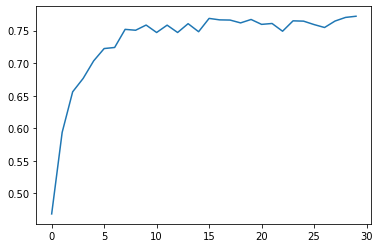

The model accuracy did not improve, patience_i =  4
-------------------------------------------------------------------------
Epoch 21 / 30 : 
Training: 
Epoch 21/21
1769/1769 [==============================] - 315s 178ms/step - loss: 0.6561 - acc: 0.8846
Validation: 
208/208 [==============================] - 36s 172ms/step - loss: 1.3134 - acc: 0.7676


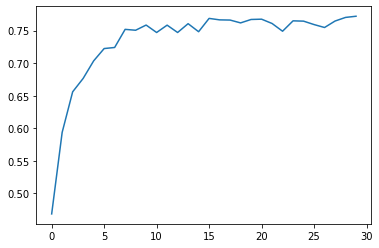

The model accuracy did not improve, patience_i =  5
-------------------------------------------------------------------------
Epoch 22 / 30 : 
Training: 
Epoch 22/22
1769/1769 [==============================] - 314s 178ms/step - loss: 0.5094 - acc: 0.8846
Validation: 
208/208 [==============================] - 36s 172ms/step - loss: 1.3045 - acc: 0.7513


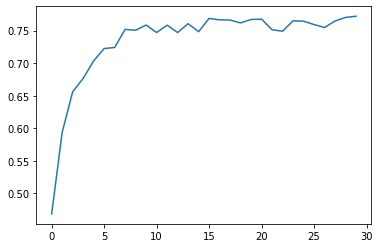

The model accuracy did not improve, patience_i =  6
-------------------------------------------------------------------------
Epoch 23 / 30 : 
Training: 
Epoch 23/23
1769/1769 [==============================] - 316s 179ms/step - loss: 0.5048 - acc: 0.8836
Validation: 
208/208 [==============================] - 36s 171ms/step - loss: 1.1428 - acc: 0.7527


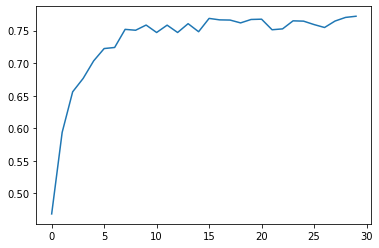

The model accuracy did not improve, patience_i =  7
-------------------------------------------------------------------------
Epoch 24 / 30 : 
Training: 
Epoch 24/24
1769/1769 [==============================] - 315s 178ms/step - loss: 0.4990 - acc: 0.8860
Validation: 
208/208 [==============================] - 36s 172ms/step - loss: 1.2536 - acc: 0.7701


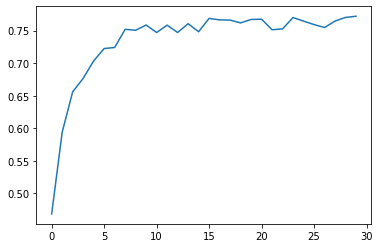

The model accuracy improved from:  0.7687565684318542 to:  0.7701097726821899
-------------------------------------------------------------------------
Epoch 25 / 30 : 
Training: 
Epoch 25/25
1769/1769 [==============================] - 315s 178ms/step - loss: 0.4981 - acc: 0.8878
Validation: 
208/208 [==============================] - 36s 171ms/step - loss: 1.3685 - acc: 0.7315


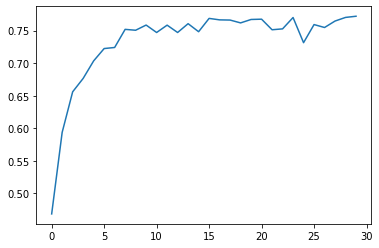

The model accuracy did not improve, patience_i =  1
-------------------------------------------------------------------------
Epoch 26 / 30 : 
Training: 
Epoch 26/26
1769/1769 [==============================] - 347s 196ms/step - loss: 0.5076 - acc: 0.8846
Validation: 
208/208 [==============================] - 36s 173ms/step - loss: 1.0833 - acc: 0.7582


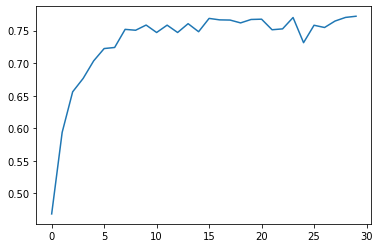

The model accuracy did not improve, patience_i =  2
-------------------------------------------------------------------------
Epoch 27 / 30 : 
Training: 
Epoch 27/27
1769/1769 [==============================] - 315s 178ms/step - loss: 0.5844 - acc: 0.8829
Validation: 
208/208 [==============================] - 36s 173ms/step - loss: 1.1847 - acc: 0.7561


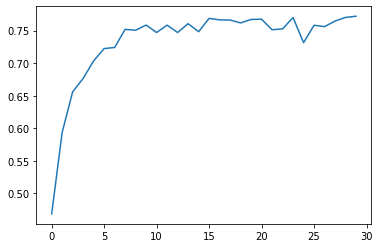

The model accuracy did not improve, patience_i =  3
-------------------------------------------------------------------------
Epoch 28 / 30 : 
Training: 
Epoch 28/28
1769/1769 [==============================] - 315s 178ms/step - loss: 0.5227 - acc: 0.8845
Validation: 
208/208 [==============================] - 36s 174ms/step - loss: 1.4080 - acc: 0.7680


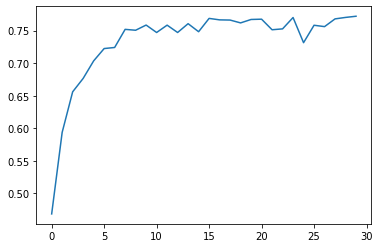

The model accuracy did not improve, patience_i =  4
-------------------------------------------------------------------------
Epoch 29 / 30 : 
Training: 
Epoch 29/29
1769/1769 [==============================] - 316s 179ms/step - loss: 0.6769 - acc: 0.8844
Validation: 
208/208 [==============================] - 36s 172ms/step - loss: 1.0401 - acc: 0.7695


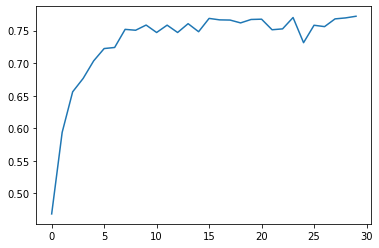

The model accuracy did not improve, patience_i =  5
-------------------------------------------------------------------------
Epoch 30 / 30 : 
Training: 
Epoch 30/30
1769/1769 [==============================] - 317s 179ms/step - loss: 0.5484 - acc: 0.8835
Validation: 
208/208 [==============================] - 36s 173ms/step - loss: 1.4099 - acc: 0.7629


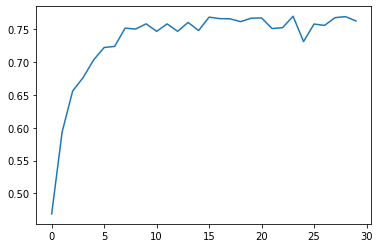

The model accuracy did not improve, patience_i =  6
-------------------------------------------------------------------------
Testing: 
105/105 [==============================] - 20s 193ms/step - loss: 1.3702 - acc: 0.7577
Test Results:  1.3701927661895752 0.7577118873596191
-------------------------------------------------------------------------
Epoch 1 / 30 : 
Training: 
1769/1769 [==============================] - 314s 178ms/step - loss: 1.7562 - acc: 0.3535
Validation: 
208/208 [==============================] - 36s 171ms/step - loss: 1.4606 - acc: 0.4735


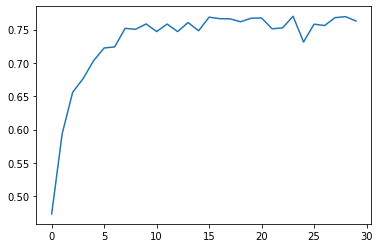

The model accuracy improved from:  0 to:  0.47346264123916626
-------------------------------------------------------------------------
Epoch 2 / 30 : 
Training: 
Epoch 2/2
1769/1769 [==============================] - 316s 179ms/step - loss: 1.3426 - acc: 0.5477
Validation: 
208/208 [==============================] - 36s 173ms/step - loss: 1.2255 - acc: 0.5849


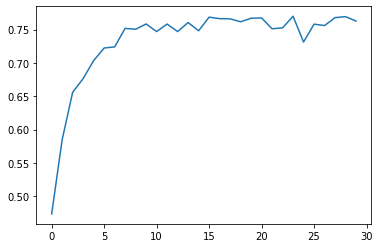

The model accuracy improved from:  0.47346264123916626 to:  0.5848744511604309
-------------------------------------------------------------------------
Epoch 3 / 30 : 
Training: 
Epoch 3/3
1769/1769 [==============================] - 315s 178ms/step - loss: 1.3311 - acc: 0.6388
Validation: 
208/208 [==============================] - 35s 170ms/step - loss: 1.1760 - acc: 0.6261


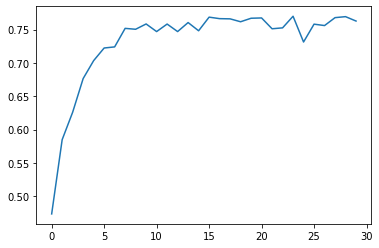

The model accuracy improved from:  0.5848744511604309 to:  0.6260712742805481
-------------------------------------------------------------------------
Epoch 4 / 30 : 
Training: 
Epoch 4/4
1769/1769 [==============================] - 314s 177ms/step - loss: 1.0674 - acc: 0.6995
Validation: 
208/208 [==============================] - 35s 170ms/step - loss: 1.0414 - acc: 0.6766


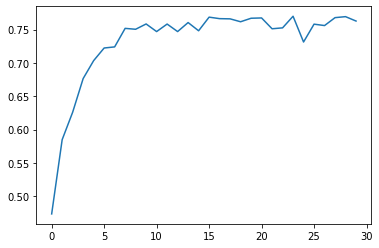

The model accuracy improved from:  0.6260712742805481 to:  0.6765899658203125
-------------------------------------------------------------------------
Epoch 5 / 30 : 
Training: 
Epoch 5/5
1769/1769 [==============================] - 314s 178ms/step - loss: 0.9600 - acc: 0.7385
Validation: 
208/208 [==============================] - 67s 320ms/step - loss: 1.0537 - acc: 0.6903


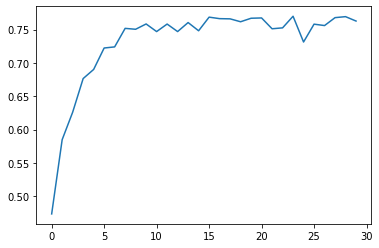

The model accuracy improved from:  0.6765899658203125 to:  0.6902721524238586
-------------------------------------------------------------------------
Epoch 6 / 30 : 
Training: 
Epoch 6/6
1769/1769 [==============================] - 346s 196ms/step - loss: 0.8516 - acc: 0.7695
Validation: 
208/208 [==============================] - 35s 170ms/step - loss: 1.0013 - acc: 0.7094


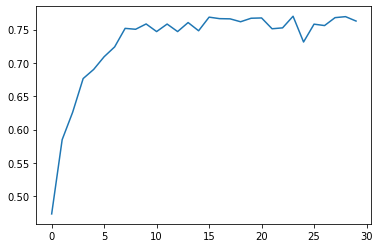

The model accuracy improved from:  0.6902721524238586 to:  0.709367036819458
-------------------------------------------------------------------------
Epoch 7 / 30 : 
Training: 
Epoch 7/7
1769/1769 [==============================] - 314s 177ms/step - loss: 0.7795 - acc: 0.7953
Validation: 
208/208 [==============================] - 36s 171ms/step - loss: 0.9855 - acc: 0.7188


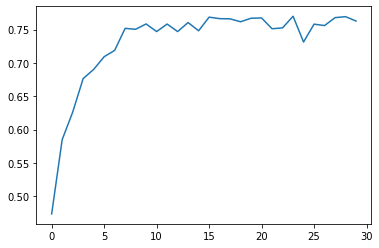

The model accuracy improved from:  0.709367036819458 to:  0.7188392877578735
-------------------------------------------------------------------------
Epoch 8 / 30 : 
Training: 
Epoch 8/8
1769/1769 [==============================] - 315s 178ms/step - loss: 0.7754 - acc: 0.8104
Validation: 
208/208 [==============================] - 35s 170ms/step - loss: 1.0004 - acc: 0.7297


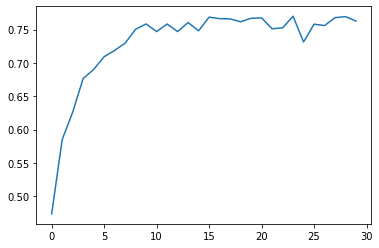

The model accuracy improved from:  0.7188392877578735 to:  0.72966468334198
-------------------------------------------------------------------------
Epoch 9 / 30 : 
Training: 
Epoch 9/9
1769/1769 [==============================] - 315s 178ms/step - loss: 0.6842 - acc: 0.8239
Validation: 
208/208 [==============================] - 36s 171ms/step - loss: 1.1181 - acc: 0.7294


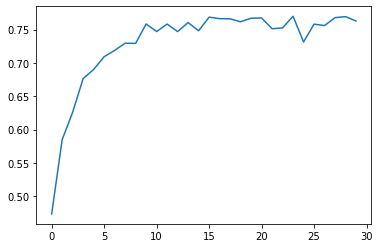

The model accuracy did not improve, patience_i =  1
-------------------------------------------------------------------------
Epoch 10 / 30 : 
Training: 
Epoch 10/10
1769/1769 [==============================] - 315s 178ms/step - loss: 0.6473 - acc: 0.8378
Validation: 
208/208 [==============================] - 35s 171ms/step - loss: 1.0226 - acc: 0.7461


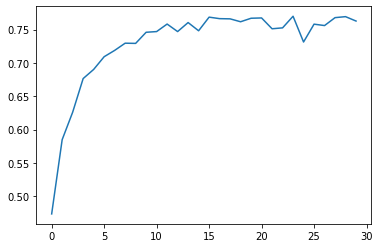

The model accuracy improved from:  0.72966468334198 to:  0.7460532188415527
-------------------------------------------------------------------------
Epoch 11 / 30 : 
Training: 
Epoch 11/11
1769/1769 [==============================] - 345s 195ms/step - loss: 0.6722 - acc: 0.8481
Validation: 
208/208 [==============================] - 36s 172ms/step - loss: 1.1822 - acc: 0.7328


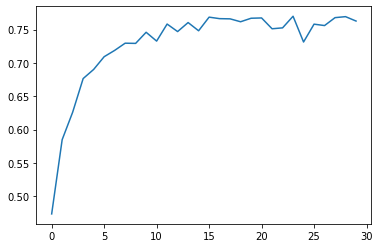

The model accuracy did not improve, patience_i =  1
-------------------------------------------------------------------------
Epoch 12 / 30 : 
Training: 
Epoch 12/12
1769/1769 [==============================] - 314s 178ms/step - loss: 0.6525 - acc: 0.8544
Validation: 
208/208 [==============================] - 36s 171ms/step - loss: 1.1045 - acc: 0.7509


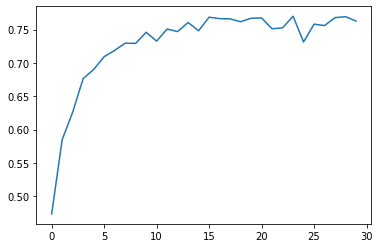

The model accuracy improved from:  0.7460532188415527 to:  0.7508645057678223
-------------------------------------------------------------------------
Epoch 13 / 30 : 
Training: 
Epoch 13/13
1769/1769 [==============================] - 314s 178ms/step - loss: 0.6027 - acc: 0.8600
Validation: 
208/208 [==============================] - 35s 171ms/step - loss: 1.0332 - acc: 0.7563


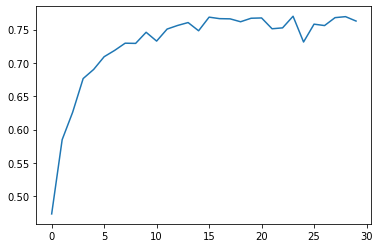

The model accuracy improved from:  0.7508645057678223 to:  0.7562772631645203
-------------------------------------------------------------------------
Epoch 14 / 30 : 
Training: 
Epoch 14/14
1769/1769 [==============================] - 315s 178ms/step - loss: 0.5809 - acc: 0.8657
Validation: 
208/208 [==============================] - 36s 171ms/step - loss: 1.1895 - acc: 0.7424


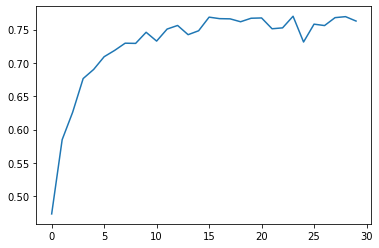

The model accuracy did not improve, patience_i =  1
-------------------------------------------------------------------------
Epoch 15 / 30 : 
Training: 
Epoch 15/15
1769/1769 [==============================] - 315s 178ms/step - loss: 0.6003 - acc: 0.8716
Validation: 
208/208 [==============================] - 36s 171ms/step - loss: 1.1412 - acc: 0.7524


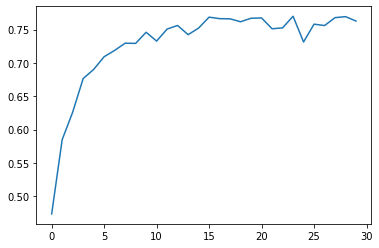

The model accuracy did not improve, patience_i =  2
-------------------------------------------------------------------------
Epoch 16 / 30 : 
Training: 
Epoch 16/16
1769/1769 [==============================] - 314s 177ms/step - loss: 0.5762 - acc: 0.8696
Validation: 
208/208 [==============================] - 35s 171ms/step - loss: 1.0918 - acc: 0.7521


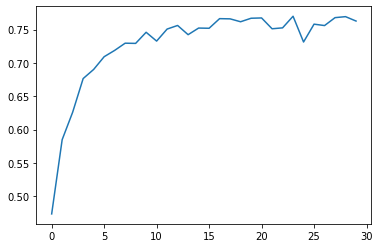

The model accuracy did not improve, patience_i =  3
-------------------------------------------------------------------------
Epoch 17 / 30 : 
Training: 
Epoch 17/17
1769/1769 [==============================] - 314s 177ms/step - loss: 0.5801 - acc: 0.8716
Validation: 
208/208 [==============================] - 35s 170ms/step - loss: 1.1301 - acc: 0.7534


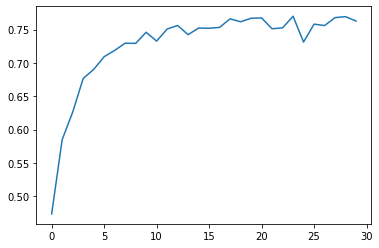

The model accuracy did not improve, patience_i =  4
-------------------------------------------------------------------------
Epoch 18 / 30 : 
Training: 
Epoch 18/18
1769/1769 [==============================] - 313s 177ms/step - loss: 0.5495 - acc: 0.8733
Validation: 
208/208 [==============================] - 36s 172ms/step - loss: 1.1597 - acc: 0.7507


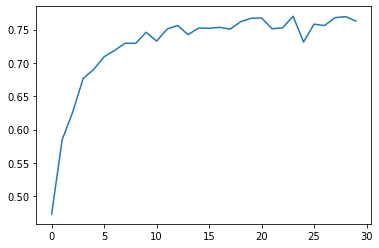

The model accuracy did not improve, patience_i =  5
-------------------------------------------------------------------------
Epoch 19 / 30 : 
Training: 
Epoch 19/19
1769/1769 [==============================] - 377s 213ms/step - loss: 0.5591 - acc: 0.8775
Validation: 
208/208 [==============================] - 36s 171ms/step - loss: 1.1712 - acc: 0.7534


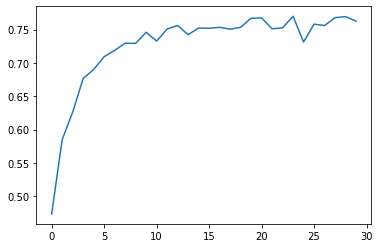

The model accuracy did not improve, patience_i =  6
-------------------------------------------------------------------------
Epoch 20 / 30 : 
Training: 
Epoch 20/20
1769/1769 [==============================] - 315s 178ms/step - loss: 0.5952 - acc: 0.8772
Validation: 
208/208 [==============================] - 36s 172ms/step - loss: 1.1409 - acc: 0.7552


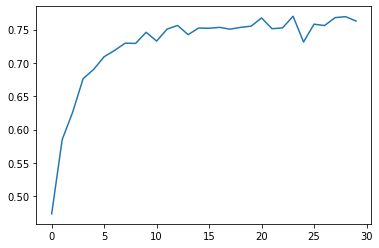

The model accuracy did not improve, patience_i =  7
-------------------------------------------------------------------------
Epoch 21 / 30 : 
Training: 
Epoch 21/21
1769/1769 [==============================] - 314s 178ms/step - loss: 0.6025 - acc: 0.8778
Validation: 
208/208 [==============================] - 35s 170ms/step - loss: 1.5062 - acc: 0.7194


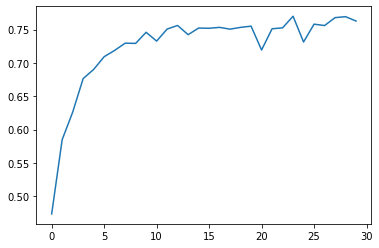

The model accuracy did not improve, patience_i =  8
-------------------------------------------------------------------------
Epoch 22 / 30 : 
Training: 
Epoch 22/22
1769/1769 [==============================] - 314s 178ms/step - loss: 0.5601 - acc: 0.8783
Validation: 
208/208 [==============================] - 36s 171ms/step - loss: 1.0772 - acc: 0.7528


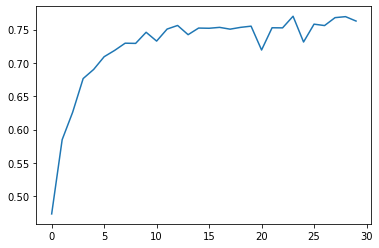

The model accuracy did not improve, patience_i =  9
-------------------------------------------------------------------------
Epoch 23 / 30 : 
Training: 
Epoch 23/23
1769/1769 [==============================] - 314s 178ms/step - loss: 0.5406 - acc: 0.8796
Validation: 
208/208 [==============================] - 36s 172ms/step - loss: 1.0968 - acc: 0.7158


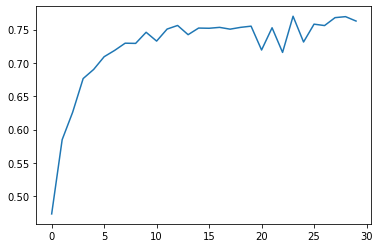

The model accuracy did not improve, patience_i =  10
-------------------------------------------------------------------------
Epoch 24 / 30 : 
Training: 
Epoch 24/24
1769/1769 [==============================] - 314s 178ms/step - loss: 0.5547 - acc: 0.8829
Validation: 
208/208 [==============================] - 36s 171ms/step - loss: 1.1798 - acc: 0.7620


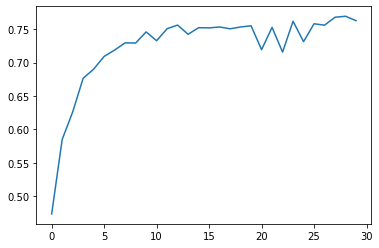

The model accuracy improved from:  0.7562772631645203 to:  0.7619906663894653
-------------------------------------------------------------------------
Epoch 25 / 30 : 
Training: 
Epoch 25/25
1769/1769 [==============================] - 315s 178ms/step - loss: 0.5345 - acc: 0.8835
Validation: 
208/208 [==============================] - 36s 172ms/step - loss: 1.2886 - acc: 0.7600


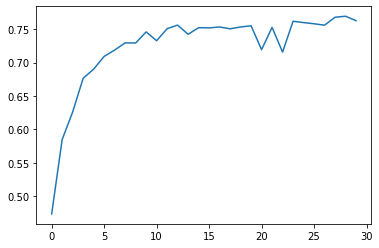

The model accuracy did not improve, patience_i =  1
-------------------------------------------------------------------------
Epoch 26 / 30 : 
Training: 
Epoch 26/26
1769/1769 [==============================] - 315s 178ms/step - loss: 0.5437 - acc: 0.8889
Validation: 
208/208 [==============================] - 36s 171ms/step - loss: 1.2968 - acc: 0.6407


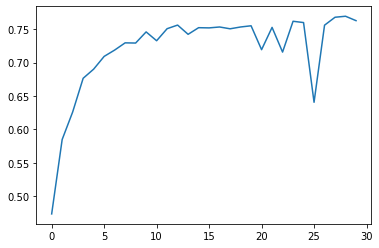

The model accuracy did not improve, patience_i =  2
-------------------------------------------------------------------------
Epoch 27 / 30 : 
Training: 
Epoch 27/27
1769/1769 [==============================] - 315s 178ms/step - loss: 0.5216 - acc: 0.8878
Validation: 
208/208 [==============================] - 36s 171ms/step - loss: 1.1690 - acc: 0.7262


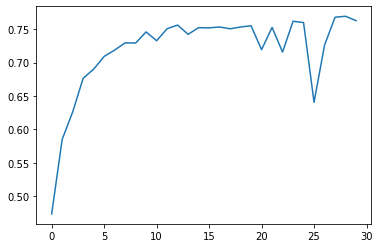

The model accuracy did not improve, patience_i =  3
-------------------------------------------------------------------------
Epoch 28 / 30 : 
Training: 
Epoch 28/28
1769/1769 [==============================] - 314s 177ms/step - loss: 0.5236 - acc: 0.8878
Validation: 
208/208 [==============================] - 35s 170ms/step - loss: 1.2894 - acc: 0.7602


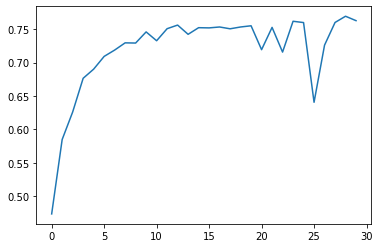

The model accuracy did not improve, patience_i =  4
-------------------------------------------------------------------------
Epoch 29 / 30 : 
Training: 
Epoch 29/29
1769/1769 [==============================] - 315s 178ms/step - loss: 0.5249 - acc: 0.8871
Validation: 
208/208 [==============================] - 36s 172ms/step - loss: 1.1316 - acc: 0.6933


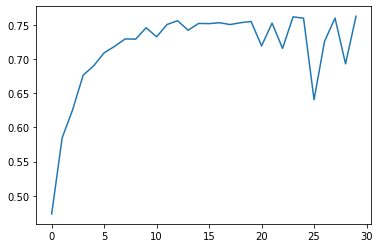

The model accuracy did not improve, patience_i =  5
-------------------------------------------------------------------------
Epoch 30 / 30 : 
Training: 
Epoch 30/30
1769/1769 [==============================] - 346s 195ms/step - loss: 0.7154 - acc: 0.8894
Validation: 
208/208 [==============================] - 36s 171ms/step - loss: 1.3089 - acc: 0.7558


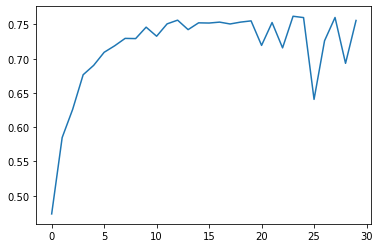

The model accuracy did not improve, patience_i =  6
-------------------------------------------------------------------------
Testing: 
105/105 [==============================] - 19s 179ms/step - loss: 1.3630 - acc: 0.7547
Test Results:  1.3629850149154663 0.7547169923782349
-------------------------------------------------------------------------
Epoch 1 / 30 : 
Training: 
1769/1769 [==============================] - 315s 178ms/step - loss: 1.7788 - acc: 0.3464
Validation: 
208/208 [==============================] - 36s 171ms/step - loss: 1.5038 - acc: 0.4614


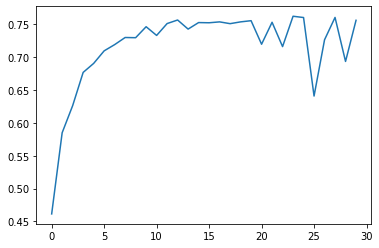

The model accuracy improved from:  0 to:  0.46143436431884766
-------------------------------------------------------------------------
Epoch 2 / 30 : 
Training: 
Epoch 2/2
1769/1769 [==============================] - 314s 178ms/step - loss: 1.3799 - acc: 0.5280
Validation: 
208/208 [==============================] - 36s 172ms/step - loss: 1.3028 - acc: 0.5692


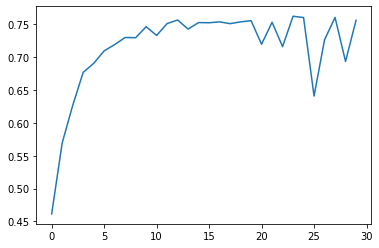

The model accuracy improved from:  0.46143436431884766 to:  0.5692377090454102
-------------------------------------------------------------------------
Epoch 3 / 30 : 
Training: 
Epoch 3/3
1769/1769 [==============================] - 314s 178ms/step - loss: 1.1724 - acc: 0.6215
Validation: 
208/208 [==============================] - 35s 169ms/step - loss: 1.1760 - acc: 0.6213


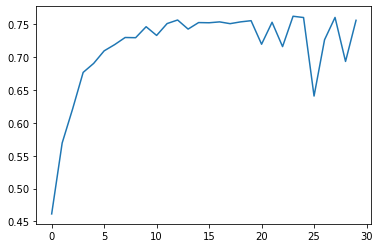

The model accuracy improved from:  0.5692377090454102 to:  0.6212599873542786
-------------------------------------------------------------------------
Epoch 4 / 30 : 
Training: 
Epoch 4/4
1769/1769 [==============================] - 315s 178ms/step - loss: 1.0174 - acc: 0.6851
Validation: 
208/208 [==============================] - 36s 171ms/step - loss: 1.0526 - acc: 0.6776


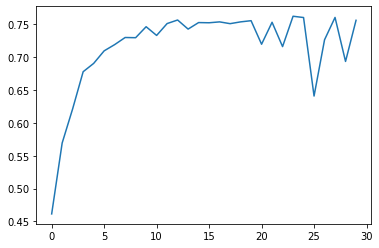

The model accuracy improved from:  0.6212599873542786 to:  0.6776424646377563
-------------------------------------------------------------------------
Epoch 5 / 30 : 
Training: 
Epoch 5/5
1769/1769 [==============================] - 315s 178ms/step - loss: 0.9241 - acc: 0.7291
Validation: 
208/208 [==============================] - 36s 171ms/step - loss: 1.0668 - acc: 0.6861


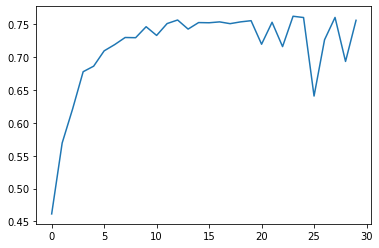

The model accuracy improved from:  0.6776424646377563 to:  0.686062216758728
-------------------------------------------------------------------------
Epoch 6 / 30 : 
Training: 
Epoch 6/6
1769/1769 [==============================] - 314s 178ms/step - loss: 0.8372 - acc: 0.7589
Validation: 
208/208 [==============================] - 36s 171ms/step - loss: 1.0256 - acc: 0.7094


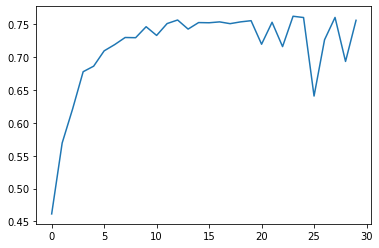

The model accuracy improved from:  0.686062216758728 to:  0.709367036819458
-------------------------------------------------------------------------
Epoch 7 / 30 : 
Training: 
Epoch 7/7
1769/1769 [==============================] - 315s 178ms/step - loss: 0.7877 - acc: 0.7817
Validation: 
208/208 [==============================] - 36s 171ms/step - loss: 1.0576 - acc: 0.7154


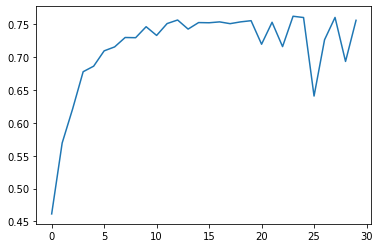

The model accuracy improved from:  0.709367036819458 to:  0.7153811454772949
-------------------------------------------------------------------------
Epoch 8 / 30 : 
Training: 
Epoch 8/8
1769/1769 [==============================] - 315s 178ms/step - loss: 0.7273 - acc: 0.8033
Validation: 
208/208 [==============================] - 36s 172ms/step - loss: 0.9953 - acc: 0.7415


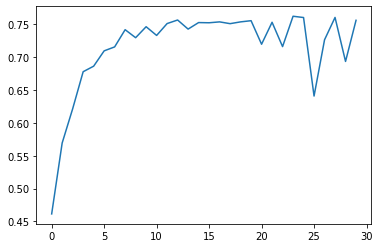

The model accuracy improved from:  0.7153811454772949 to:  0.741542637348175
-------------------------------------------------------------------------
Epoch 9 / 30 : 
Training: 
Epoch 9/9
1769/1769 [==============================] - 314s 178ms/step - loss: 0.7737 - acc: 0.8219
Validation: 
208/208 [==============================] - 36s 172ms/step - loss: 1.0580 - acc: 0.7151


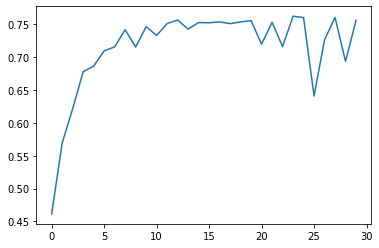

The model accuracy did not improve, patience_i =  1
-------------------------------------------------------------------------
Epoch 10 / 30 : 
Training: 
Epoch 10/10
1769/1769 [==============================] - 315s 178ms/step - loss: 0.6667 - acc: 0.8353
Validation: 
208/208 [==============================] - 36s 172ms/step - loss: 1.0990 - acc: 0.7279


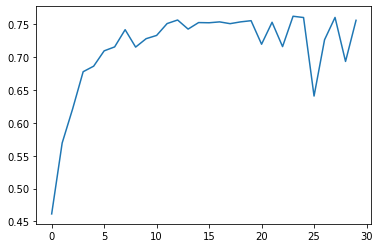

The model accuracy did not improve, patience_i =  2
-------------------------------------------------------------------------
Epoch 11 / 30 : 
Training: 
Epoch 11/11
1769/1769 [==============================] - 314s 178ms/step - loss: 0.6299 - acc: 0.8429
Validation: 
208/208 [==============================] - 35s 170ms/step - loss: 1.0783 - acc: 0.7390


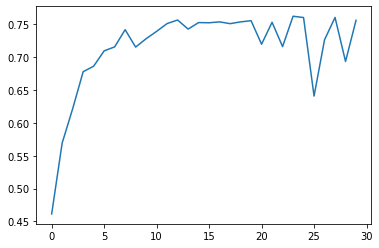

The model accuracy did not improve, patience_i =  3
-------------------------------------------------------------------------
Epoch 12 / 30 : 
Training: 
Epoch 12/12
1769/1769 [==============================] - 316s 178ms/step - loss: 0.6119 - acc: 0.8512
Validation: 
208/208 [==============================] - 36s 172ms/step - loss: 1.0314 - acc: 0.7461


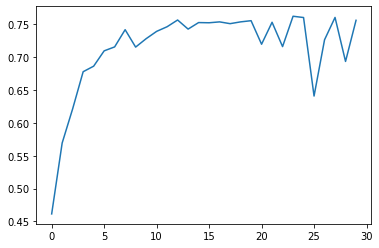

The model accuracy improved from:  0.741542637348175 to:  0.7460532188415527
-------------------------------------------------------------------------
Epoch 13 / 30 : 
Training: 
Epoch 13/13
1769/1769 [==============================] - 314s 178ms/step - loss: 0.5813 - acc: 0.8591
Validation: 
208/208 [==============================] - 36s 171ms/step - loss: 1.1020 - acc: 0.7465


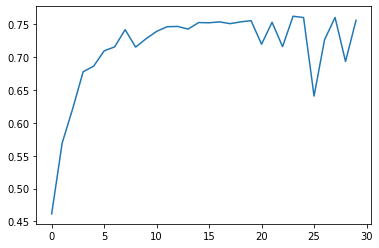

The model accuracy improved from:  0.7460532188415527 to:  0.7465043067932129
-------------------------------------------------------------------------
Epoch 14 / 30 : 
Training: 
Epoch 14/14
1769/1769 [==============================] - 315s 178ms/step - loss: 0.5792 - acc: 0.8636
Validation: 
208/208 [==============================] - 36s 172ms/step - loss: 1.1791 - acc: 0.7495


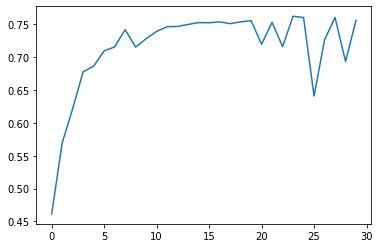

The model accuracy improved from:  0.7465043067932129 to:  0.7495113611221313
-------------------------------------------------------------------------
Epoch 15 / 30 : 
Training: 
Epoch 15/15
1769/1769 [==============================] - 316s 178ms/step - loss: 0.5764 - acc: 0.8648
Validation: 
208/208 [==============================] - 36s 171ms/step - loss: 1.1856 - acc: 0.7462


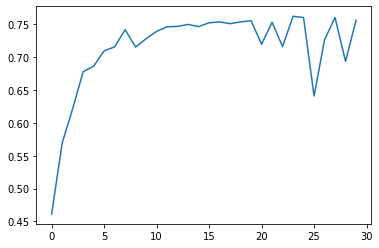

The model accuracy did not improve, patience_i =  1
-------------------------------------------------------------------------
Epoch 16 / 30 : 
Training: 
Epoch 16/16
1769/1769 [==============================] - 314s 178ms/step - loss: 0.5572 - acc: 0.8680
Validation: 
208/208 [==============================] - 36s 172ms/step - loss: 1.2187 - acc: 0.7477


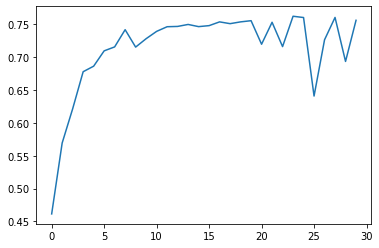

The model accuracy did not improve, patience_i =  2
-------------------------------------------------------------------------
Epoch 17 / 30 : 
Training: 
Epoch 17/17
1769/1769 [==============================] - 315s 178ms/step - loss: 0.5561 - acc: 0.8699
Validation: 
208/208 [==============================] - 36s 171ms/step - loss: 1.2685 - acc: 0.7447


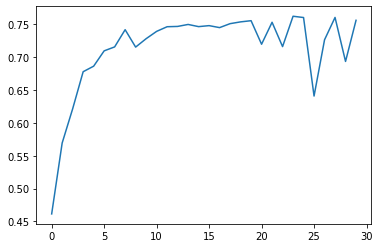

The model accuracy did not improve, patience_i =  3
-------------------------------------------------------------------------
Epoch 18 / 30 : 
Training: 
Epoch 18/18
1769/1769 [==============================] - 346s 195ms/step - loss: 0.5706 - acc: 0.8703
Validation: 
208/208 [==============================] - 68s 325ms/step - loss: 1.2211 - acc: 0.7450


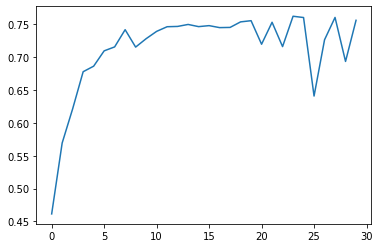

The model accuracy did not improve, patience_i =  4
-------------------------------------------------------------------------
Epoch 19 / 30 : 
Training: 
Epoch 19/19
1769/1769 [==============================] - 314s 178ms/step - loss: 0.5620 - acc: 0.8710
Validation: 
208/208 [==============================] - 35s 171ms/step - loss: 1.2869 - acc: 0.7470


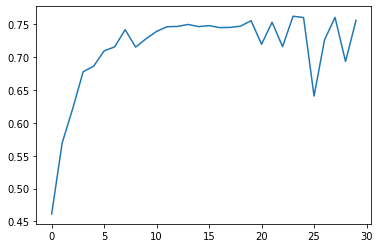

The model accuracy did not improve, patience_i =  5
-------------------------------------------------------------------------
Epoch 20 / 30 : 
Training: 
Epoch 20/20
1769/1769 [==============================] - 315s 178ms/step - loss: 0.5454 - acc: 0.8734
Validation: 
208/208 [==============================] - 36s 171ms/step - loss: 1.2634 - acc: 0.7558


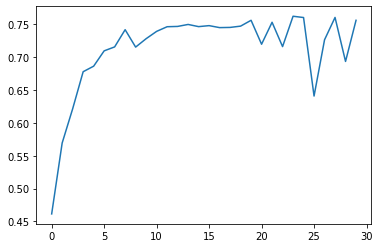

The model accuracy improved from:  0.7495113611221313 to:  0.7558261752128601
-------------------------------------------------------------------------
Epoch 21 / 30 : 
Training: 
Epoch 21/21
1769/1769 [==============================] - 344s 194ms/step - loss: 0.5509 - acc: 0.8769
Validation: 
208/208 [==============================] - 35s 170ms/step - loss: 1.1603 - acc: 0.7468


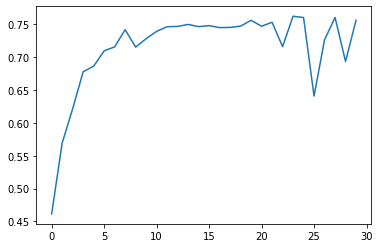

The model accuracy did not improve, patience_i =  1
-------------------------------------------------------------------------
Epoch 22 / 30 : 
Training: 
Epoch 22/22
1769/1769 [==============================] - 315s 178ms/step - loss: 0.5493 - acc: 0.8775
Validation: 
208/208 [==============================] - 67s 322ms/step - loss: 1.0639 - acc: 0.7429


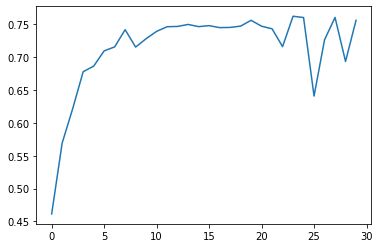

The model accuracy did not improve, patience_i =  2
-------------------------------------------------------------------------
Epoch 23 / 30 : 
Training: 
Epoch 23/23
1769/1769 [==============================] - 315s 178ms/step - loss: 0.5359 - acc: 0.8775
Validation: 
208/208 [==============================] - 36s 173ms/step - loss: 1.1146 - acc: 0.7390


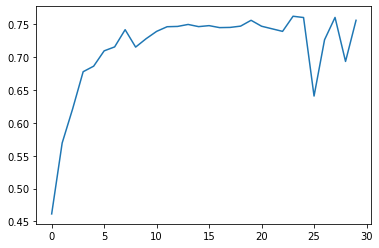

The model accuracy did not improve, patience_i =  3
-------------------------------------------------------------------------
Epoch 24 / 30 : 
Training: 
Epoch 24/24
1769/1769 [==============================] - 314s 178ms/step - loss: 0.5470 - acc: 0.8781
Validation: 
208/208 [==============================] - 36s 171ms/step - loss: 1.2228 - acc: 0.7439


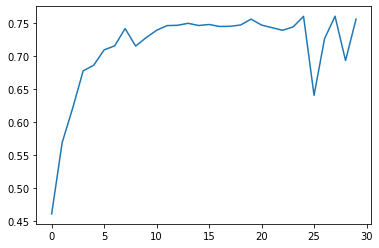

The model accuracy did not improve, patience_i =  4
-------------------------------------------------------------------------
Epoch 25 / 30 : 
Training: 
Epoch 25/25
1769/1769 [==============================] - 315s 178ms/step - loss: 0.5786 - acc: 0.8771
Validation: 
208/208 [==============================] - 36s 175ms/step - loss: 1.2015 - acc: 0.7552


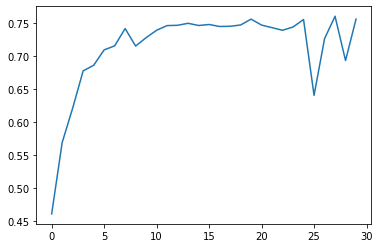

The model accuracy did not improve, patience_i =  5
-------------------------------------------------------------------------
Epoch 26 / 30 : 
Training: 
Epoch 26/26
1769/1769 [==============================] - 315s 178ms/step - loss: 0.5392 - acc: 0.8795
Validation: 
208/208 [==============================] - 36s 171ms/step - loss: 1.5697 - acc: 0.7480


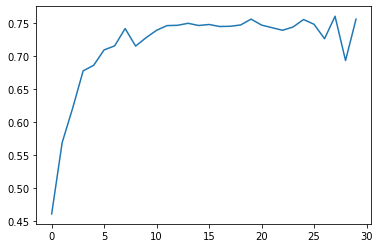

The model accuracy did not improve, patience_i =  6
-------------------------------------------------------------------------
Epoch 27 / 30 : 
Training: 
Epoch 27/27
1769/1769 [==============================] - 314s 177ms/step - loss: 0.5344 - acc: 0.8811
Validation: 
208/208 [==============================] - 36s 172ms/step - loss: 1.2100 - acc: 0.7593


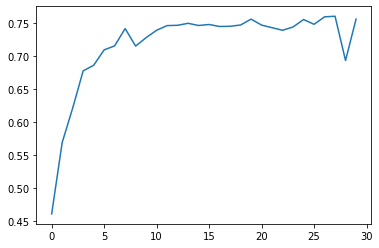

The model accuracy improved from:  0.7558261752128601 to:  0.7592843174934387
-------------------------------------------------------------------------
Epoch 28 / 30 : 
Training: 
Epoch 28/28
1769/1769 [==============================] - 314s 178ms/step - loss: 0.5190 - acc: 0.8826
Validation: 
208/208 [==============================] - 36s 173ms/step - loss: 1.2174 - acc: 0.7546


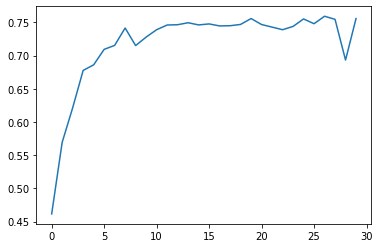

The model accuracy did not improve, patience_i =  1
-------------------------------------------------------------------------
Epoch 29 / 30 : 
Training: 
Epoch 29/29
1769/1769 [==============================] - 315s 178ms/step - loss: 0.5252 - acc: 0.8814
Validation: 
208/208 [==============================] - 35s 170ms/step - loss: 1.3303 - acc: 0.7474


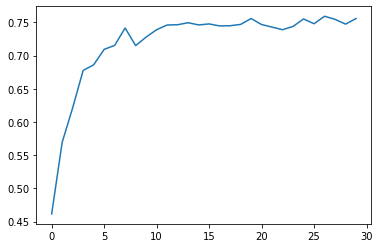

The model accuracy did not improve, patience_i =  2
-------------------------------------------------------------------------
Epoch 30 / 30 : 
Training: 
Epoch 30/30
1769/1769 [==============================] - 315s 178ms/step - loss: 0.5196 - acc: 0.8844
Validation: 
208/208 [==============================] - 36s 171ms/step - loss: 1.2841 - acc: 0.7405


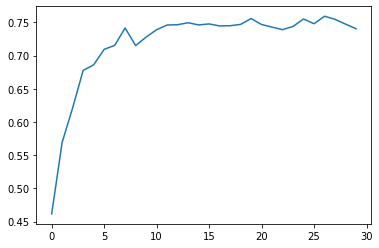

The model accuracy did not improve, patience_i =  3
-------------------------------------------------------------------------
Testing: 
105/105 [==============================] - 19s 180ms/step - loss: 1.2891 - acc: 0.7409
Test Results:  1.289128303527832 0.7409403920173645
-------------------------------------------------------------------------
Epoch 1 / 30 : 
Training: 
1769/1769 [==============================] - 315s 178ms/step - loss: 1.7771 - acc: 0.3492
Validation: 
208/208 [==============================] - 36s 173ms/step - loss: 1.5131 - acc: 0.4520


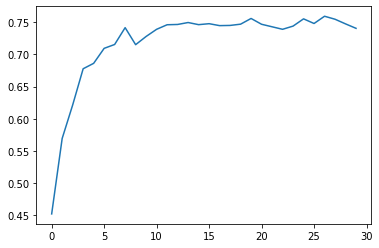

The model accuracy improved from:  0 to:  0.45196211338043213
-------------------------------------------------------------------------
Epoch 2 / 30 : 
Training: 
Epoch 2/2
1769/1769 [==============================] - 315s 178ms/step - loss: 1.3978 - acc: 0.5284
Validation: 
208/208 [==============================] - 36s 171ms/step - loss: 1.2807 - acc: 0.5792


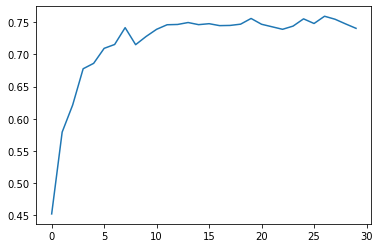

The model accuracy improved from:  0.45196211338043213 to:  0.5791610479354858
-------------------------------------------------------------------------
Epoch 3 / 30 : 
Training: 
Epoch 3/3
1769/1769 [==============================] - 315s 178ms/step - loss: 1.2021 - acc: 0.6199
Validation: 
208/208 [==============================] - 36s 171ms/step - loss: 1.1799 - acc: 0.6118


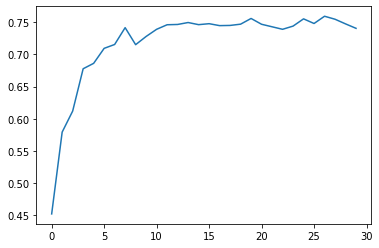

The model accuracy improved from:  0.5791610479354858 to:  0.6117876768112183
-------------------------------------------------------------------------
Epoch 4 / 30 : 
Training: 
Epoch 4/4
1769/1769 [==============================] - 315s 178ms/step - loss: 1.0411 - acc: 0.6772
Validation: 
208/208 [==============================] - 36s 171ms/step - loss: 1.0964 - acc: 0.6649


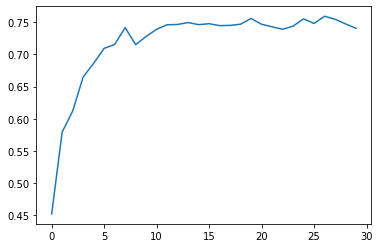

The model accuracy improved from:  0.6117876768112183 to:  0.6648624539375305
-------------------------------------------------------------------------
Epoch 5 / 30 : 
Training: 
Epoch 5/5
1769/1769 [==============================] - 315s 178ms/step - loss: 0.9272 - acc: 0.7196
Validation: 
208/208 [==============================] - 67s 323ms/step - loss: 1.1111 - acc: 0.6776


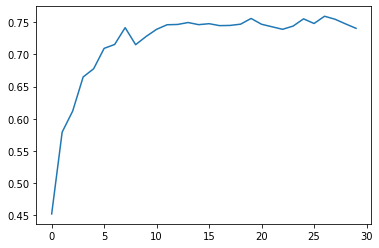

The model accuracy improved from:  0.6648624539375305 to:  0.6776424646377563
-------------------------------------------------------------------------
Epoch 6 / 30 : 
Training: 
Epoch 6/6
1769/1769 [==============================] - 315s 178ms/step - loss: 0.8774 - acc: 0.7529
Validation: 
208/208 [==============================] - 36s 172ms/step - loss: 1.1035 - acc: 0.6892


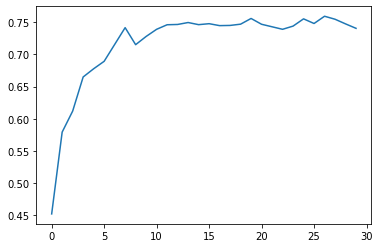

The model accuracy improved from:  0.6776424646377563 to:  0.6892196536064148
-------------------------------------------------------------------------
Epoch 7 / 30 : 
Training: 
Epoch 7/7
1769/1769 [==============================] - 312s 177ms/step - loss: 0.8005 - acc: 0.7774
Validation: 
208/208 [==============================] - 35s 170ms/step - loss: 1.0438 - acc: 0.7112


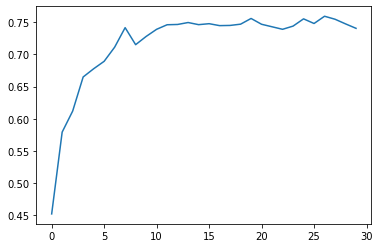

The model accuracy improved from:  0.6892196536064148 to:  0.7111712694168091
-------------------------------------------------------------------------
Epoch 8 / 30 : 
Training: 
Epoch 8/8
1769/1769 [==============================] - 315s 178ms/step - loss: 0.7606 - acc: 0.7963
Validation: 
208/208 [==============================] - 36s 172ms/step - loss: 1.0366 - acc: 0.7247


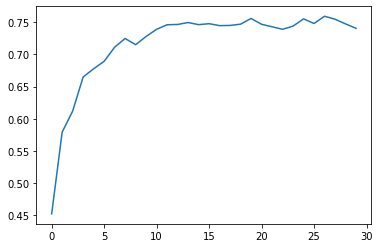

The model accuracy improved from:  0.7111712694168091 to:  0.7247030735015869
-------------------------------------------------------------------------
Epoch 9 / 30 : 
Training: 
Epoch 9/9
1769/1769 [==============================] - 313s 177ms/step - loss: 0.7335 - acc: 0.8101
Validation: 
208/208 [==============================] - 36s 171ms/step - loss: 1.0924 - acc: 0.7295


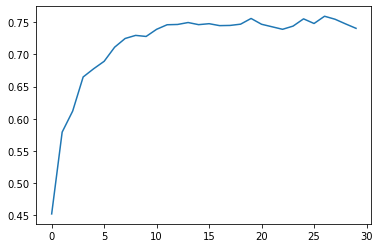

The model accuracy improved from:  0.7247030735015869 to:  0.7295143604278564
-------------------------------------------------------------------------
Epoch 10 / 30 : 
Training: 
Epoch 10/10
1769/1769 [==============================] - 316s 178ms/step - loss: 0.6861 - acc: 0.8206
Validation: 
208/208 [==============================] - 36s 171ms/step - loss: 1.0510 - acc: 0.7327


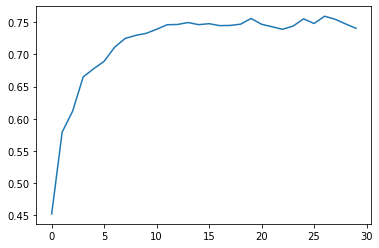

The model accuracy improved from:  0.7295143604278564 to:  0.7326717972755432
-------------------------------------------------------------------------
Epoch 11 / 30 : 
Training: 
Epoch 11/11
1769/1769 [==============================] - 315s 178ms/step - loss: 0.6981 - acc: 0.8290
Validation: 
208/208 [==============================] - 36s 172ms/step - loss: 1.1266 - acc: 0.7246


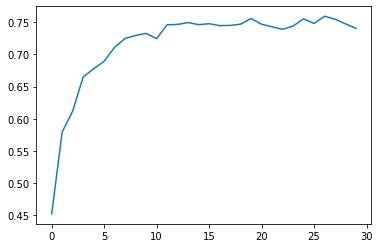

The model accuracy did not improve, patience_i =  1
-------------------------------------------------------------------------
Epoch 12 / 30 : 
Training: 
Epoch 12/12
1769/1769 [==============================] - 315s 178ms/step - loss: 0.6924 - acc: 0.8333
Validation: 
208/208 [==============================] - 36s 171ms/step - loss: 1.0503 - acc: 0.7255


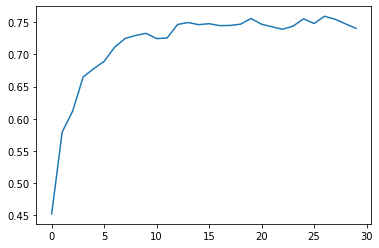

The model accuracy did not improve, patience_i =  2
-------------------------------------------------------------------------
Epoch 13 / 30 : 
Training: 
Epoch 13/13
1769/1769 [==============================] - 345s 195ms/step - loss: 0.7302 - acc: 0.8400
Validation: 
208/208 [==============================] - 36s 171ms/step - loss: 1.1399 - acc: 0.7436


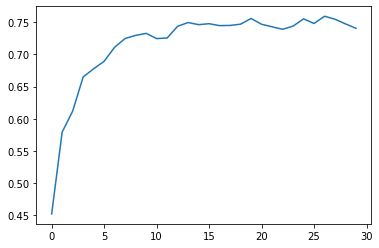

The model accuracy improved from:  0.7326717972755432 to:  0.743647575378418
-------------------------------------------------------------------------
Epoch 14 / 30 : 
Training: 
Epoch 14/14
1769/1769 [==============================] - 314s 177ms/step - loss: 0.6394 - acc: 0.8457
Validation: 
208/208 [==============================] - 35s 171ms/step - loss: 1.1911 - acc: 0.7379


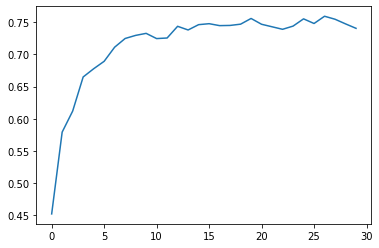

The model accuracy did not improve, patience_i =  1
-------------------------------------------------------------------------
Epoch 15 / 30 : 
Training: 
Epoch 15/15
1769/1769 [==============================] - 314s 178ms/step - loss: 0.6138 - acc: 0.8525
Validation: 
208/208 [==============================] - 36s 172ms/step - loss: 1.2015 - acc: 0.7411


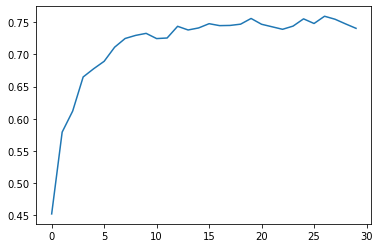

The model accuracy did not improve, patience_i =  2
-------------------------------------------------------------------------
Epoch 16 / 30 : 
Training: 
Epoch 16/16
1769/1769 [==============================] - 346s 195ms/step - loss: 0.6195 - acc: 0.8565
Validation: 
208/208 [==============================] - 67s 321ms/step - loss: 1.0353 - acc: 0.7331


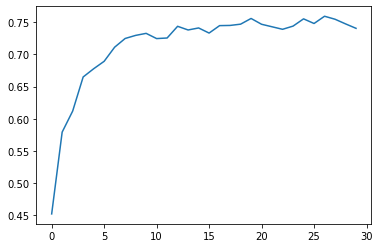

The model accuracy did not improve, patience_i =  3
-------------------------------------------------------------------------
Epoch 17 / 30 : 
Training: 
Epoch 17/17
1769/1769 [==============================] - 315s 178ms/step - loss: 0.7150 - acc: 0.8594
Validation: 
208/208 [==============================] - 36s 172ms/step - loss: 1.2313 - acc: 0.7364


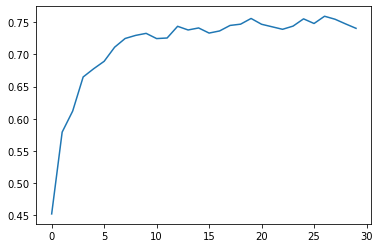

The model accuracy did not improve, patience_i =  4
-------------------------------------------------------------------------
Epoch 18 / 30 : 
Training: 
Epoch 18/18
1769/1769 [==============================] - 314s 178ms/step - loss: 0.6022 - acc: 0.8610
Validation: 
208/208 [==============================] - 36s 171ms/step - loss: 1.2066 - acc: 0.7315


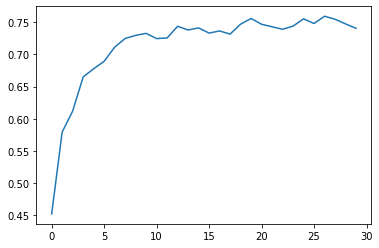

The model accuracy did not improve, patience_i =  5
-------------------------------------------------------------------------
Epoch 19 / 30 : 
Training: 
Epoch 19/19
1769/1769 [==============================] - 315s 178ms/step - loss: 0.6062 - acc: 0.8583
Validation: 
208/208 [==============================] - 36s 172ms/step - loss: 1.1070 - acc: 0.7503


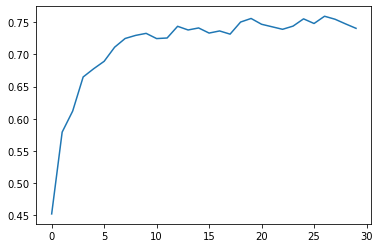

The model accuracy improved from:  0.743647575378418 to:  0.7502630949020386
-------------------------------------------------------------------------
Epoch 20 / 30 : 
Training: 
Epoch 20/20
1769/1769 [==============================] - 315s 178ms/step - loss: 0.6042 - acc: 0.8624
Validation: 
208/208 [==============================] - 35s 170ms/step - loss: 1.1629 - acc: 0.7387


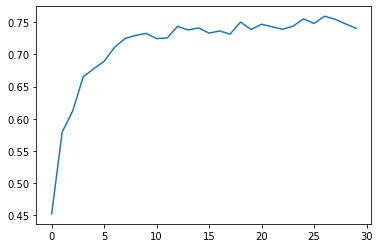

The model accuracy did not improve, patience_i =  1
-------------------------------------------------------------------------
Epoch 21 / 30 : 
Training: 
Epoch 21/21
1769/1769 [==============================] - 315s 178ms/step - loss: 0.6903 - acc: 0.8612
Validation: 
208/208 [==============================] - 36s 172ms/step - loss: 1.2214 - acc: 0.7415


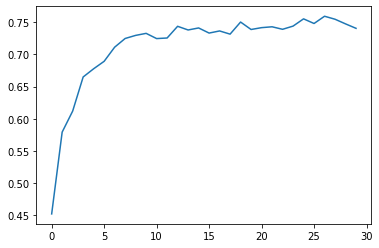

The model accuracy did not improve, patience_i =  2
-------------------------------------------------------------------------
Epoch 22 / 30 : 
Training: 
Epoch 22/22
1769/1769 [==============================] - 315s 178ms/step - loss: 0.6036 - acc: 0.8642s - loss: 0.6040 -
Validation: 
208/208 [==============================] - 36s 171ms/step - loss: 1.3080 - acc: 0.7482


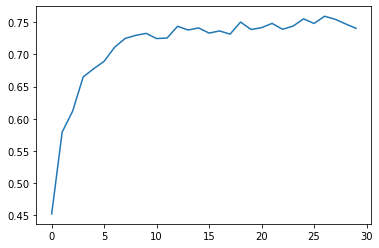

The model accuracy did not improve, patience_i =  3
-------------------------------------------------------------------------
Epoch 23 / 30 : 
Training: 
Epoch 23/23
1769/1769 [==============================] - 315s 178ms/step - loss: 0.5999 - acc: 0.8661
Validation: 
208/208 [==============================] - 36s 172ms/step - loss: 1.3175 - acc: 0.7449


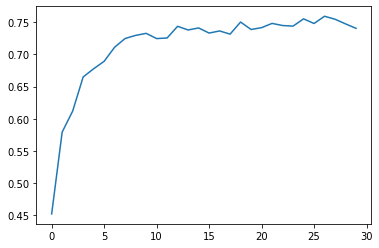

The model accuracy did not improve, patience_i =  4
-------------------------------------------------------------------------
Epoch 24 / 30 : 
Training: 
Epoch 24/24
1769/1769 [==============================] - 314s 178ms/step - loss: 0.5906 - acc: 0.8662
Validation: 
208/208 [==============================] - 36s 171ms/step - loss: 1.1954 - acc: 0.7464


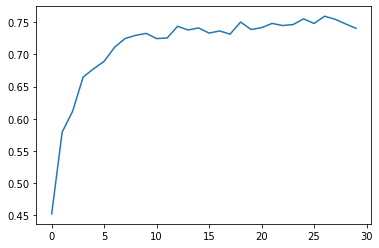

The model accuracy did not improve, patience_i =  5
-------------------------------------------------------------------------
Epoch 25 / 30 : 
Training: 
Epoch 25/25
1769/1769 [==============================] - 315s 178ms/step - loss: 0.5884 - acc: 0.8697
Validation: 
208/208 [==============================] - 36s 172ms/step - loss: 1.4537 - acc: 0.7304


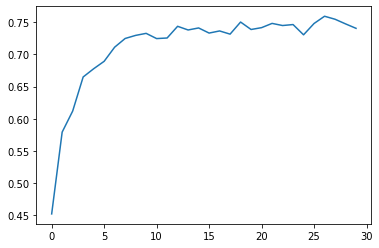

The model accuracy did not improve, patience_i =  6
-------------------------------------------------------------------------
Epoch 26 / 30 : 
Training: 
Epoch 26/26
1769/1769 [==============================] - 346s 196ms/step - loss: 0.6667 - acc: 0.8693
Validation: 
208/208 [==============================] - 36s 171ms/step - loss: 1.0991 - acc: 0.7497


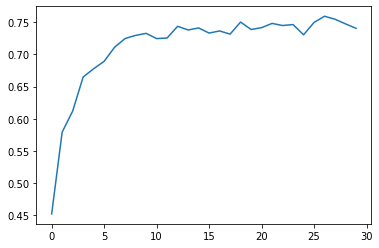

The model accuracy did not improve, patience_i =  7
-------------------------------------------------------------------------
Epoch 27 / 30 : 
Training: 
Epoch 27/27
1769/1769 [==============================] - 315s 178ms/step - loss: 0.8355 - acc: 0.8663
Validation: 
208/208 [==============================] - 36s 173ms/step - loss: 1.2892 - acc: 0.7211


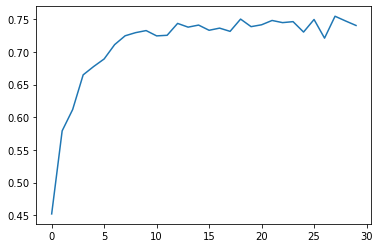

The model accuracy did not improve, patience_i =  8
-------------------------------------------------------------------------
Epoch 28 / 30 : 
Training: 
Epoch 28/28
1769/1769 [==============================] - 313s 177ms/step - loss: 0.6359 - acc: 0.8701
Validation: 
208/208 [==============================] - 35s 170ms/step - loss: 1.2456 - acc: 0.7552


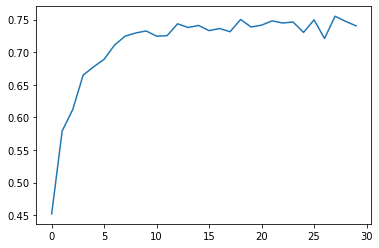

The model accuracy improved from:  0.7502630949020386 to:  0.7552247643470764
-------------------------------------------------------------------------
Epoch 29 / 30 : 
Training: 
Epoch 29/29
1769/1769 [==============================] - 315s 178ms/step - loss: 0.6095 - acc: 0.8712
Validation: 
208/208 [==============================] - 36s 171ms/step - loss: 1.1942 - acc: 0.7485


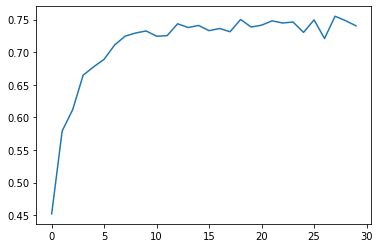

The model accuracy did not improve, patience_i =  1
-------------------------------------------------------------------------
Epoch 30 / 30 : 
Training: 
Epoch 30/30
1769/1769 [==============================] - 315s 178ms/step - loss: 0.6145 - acc: 0.8715
Validation: 
208/208 [==============================] - 36s 171ms/step - loss: 1.1932 - acc: 0.7438


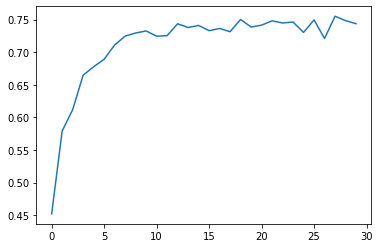

The model accuracy did not improve, patience_i =  2
-------------------------------------------------------------------------
Testing: 
105/105 [==============================] - 19s 180ms/step - loss: 1.2172 - acc: 0.7353
Test Results:  1.21724271774292 0.7352500557899475
-------------------------------------------------------------------------
Epoch 1 / 30 : 
Training: 
1769/1769 [==============================] - 314s 178ms/step - loss: 1.7810 - acc: 0.3342
Validation: 
208/208 [==============================] - 36s 171ms/step - loss: 1.5157 - acc: 0.4455


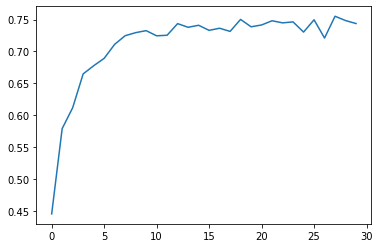

The model accuracy improved from:  0 to:  0.44549691677093506
-------------------------------------------------------------------------
Epoch 2 / 30 : 
Training: 
Epoch 2/2
1769/1769 [==============================] - 346s 196ms/step - loss: 1.4271 - acc: 0.4931
Validation: 
208/208 [==============================] - 35s 170ms/step - loss: 1.3190 - acc: 0.5351


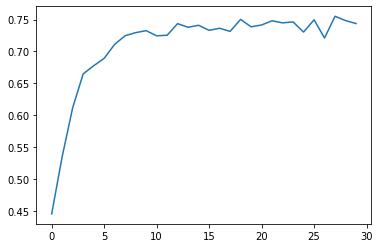

The model accuracy improved from:  0.44549691677093506 to:  0.5351074934005737
-------------------------------------------------------------------------
Epoch 3 / 30 : 
Training: 
Epoch 3/3
1769/1769 [==============================] - 315s 178ms/step - loss: 1.2387 - acc: 0.5798
Validation: 
208/208 [==============================] - 35s 170ms/step - loss: 1.2152 - acc: 0.5913


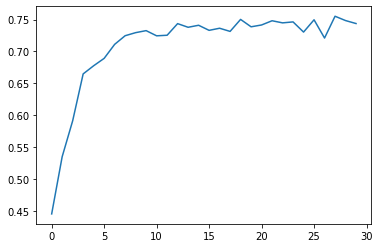

The model accuracy improved from:  0.5351074934005737 to:  0.591339647769928
-------------------------------------------------------------------------
Epoch 4 / 30 : 
Training: 
Epoch 4/4
1769/1769 [==============================] - 314s 177ms/step - loss: 1.1041 - acc: 0.6378
Validation: 
208/208 [==============================] - 36s 171ms/step - loss: 1.1245 - acc: 0.6367


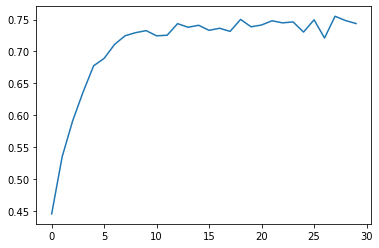

The model accuracy improved from:  0.591339647769928 to:  0.636746346950531
-------------------------------------------------------------------------
Epoch 5 / 30 : 
Training: 
Epoch 5/5
1769/1769 [==============================] - 313s 177ms/step - loss: 1.0101 - acc: 0.6791
Validation: 
208/208 [==============================] - 35s 170ms/step - loss: 1.1348 - acc: 0.6494


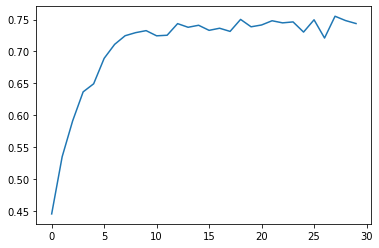

The model accuracy improved from:  0.636746346950531 to:  0.6493760347366333
-------------------------------------------------------------------------
Epoch 6 / 30 : 
Training: 
Epoch 6/6
1769/1769 [==============================] - 314s 178ms/step - loss: 0.9384 - acc: 0.7106
Validation: 
208/208 [==============================] - 36s 172ms/step - loss: 1.0814 - acc: 0.6631


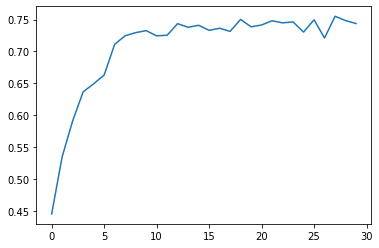

The model accuracy improved from:  0.6493760347366333 to:  0.6630581617355347
-------------------------------------------------------------------------
Epoch 7 / 30 : 
Training: 
Epoch 7/7
1769/1769 [==============================] - 315s 178ms/step - loss: 0.8885 - acc: 0.7364
Validation: 
208/208 [==============================] - 35s 170ms/step - loss: 1.1210 - acc: 0.6647


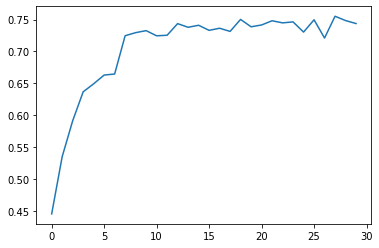

The model accuracy improved from:  0.6630581617355347 to:  0.6647120714187622
-------------------------------------------------------------------------
Epoch 8 / 30 : 
Training: 
Epoch 8/8
1769/1769 [==============================] - 314s 177ms/step - loss: 0.8530 - acc: 0.7571
Validation: 
208/208 [==============================] - 36s 171ms/step - loss: 1.2349 - acc: 0.6790


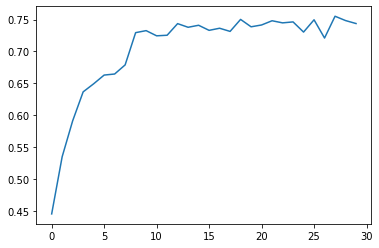

The model accuracy improved from:  0.6647120714187622 to:  0.678995668888092
-------------------------------------------------------------------------
Epoch 9 / 30 : 
Training: 
Epoch 9/9
1769/1769 [==============================] - 314s 177ms/step - loss: 0.7983 - acc: 0.7724
Validation: 
208/208 [==============================] - 36s 171ms/step - loss: 1.0516 - acc: 0.7008


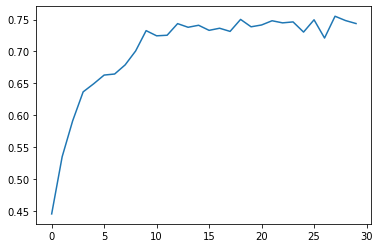

The model accuracy improved from:  0.678995668888092 to:  0.700796902179718
-------------------------------------------------------------------------
Epoch 10 / 30 : 
Training: 
Epoch 10/10
1769/1769 [==============================] - 314s 177ms/step - loss: 0.7871 - acc: 0.7831
Validation: 
208/208 [==============================] - 36s 171ms/step - loss: 1.0990 - acc: 0.7034


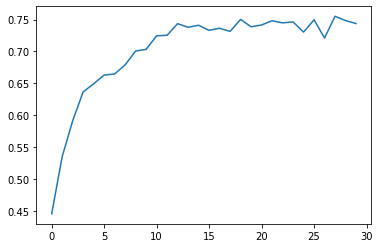

The model accuracy improved from:  0.700796902179718 to:  0.7033528685569763
-------------------------------------------------------------------------
Epoch 11 / 30 : 
Training: 
Epoch 11/11
1769/1769 [==============================] - 314s 177ms/step - loss: 0.7819 - acc: 0.7950
Validation: 
208/208 [==============================] - 36s 171ms/step - loss: 1.1370 - acc: 0.7164


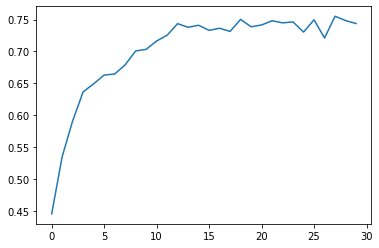

The model accuracy improved from:  0.7033528685569763 to:  0.7164336442947388
-------------------------------------------------------------------------
Epoch 12 / 30 : 
Training: 
Epoch 12/12
1769/1769 [==============================] - 314s 177ms/step - loss: 0.7421 - acc: 0.8038
Validation: 
208/208 [==============================] - 36s 171ms/step - loss: 1.1149 - acc: 0.6773


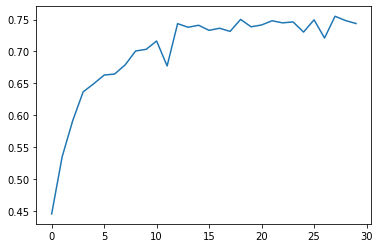

The model accuracy did not improve, patience_i =  1
-------------------------------------------------------------------------
Epoch 13 / 30 : 
Training: 
Epoch 13/13
1769/1769 [==============================] - 314s 177ms/step - loss: 0.7307 - acc: 0.8057
Validation: 
208/208 [==============================] - 35s 170ms/step - loss: 1.0690 - acc: 0.7163


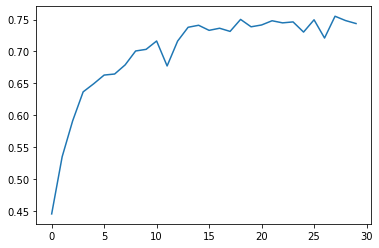

The model accuracy did not improve, patience_i =  2
-------------------------------------------------------------------------
Epoch 14 / 30 : 
Training: 
Epoch 14/14
1769/1769 [==============================] - 345s 195ms/step - loss: 0.7190 - acc: 0.8162
Validation: 
208/208 [==============================] - 36s 171ms/step - loss: 1.2571 - acc: 0.7137


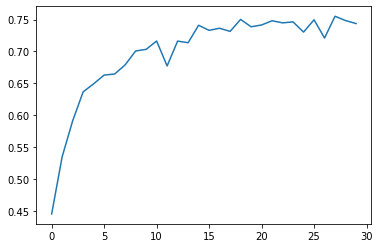

The model accuracy did not improve, patience_i =  3
-------------------------------------------------------------------------
Epoch 15 / 30 : 
Training: 
Epoch 15/15
1769/1769 [==============================] - 314s 178ms/step - loss: 0.7172 - acc: 0.8203
Validation: 
208/208 [==============================] - 36s 172ms/step - loss: 1.2453 - acc: 0.7031


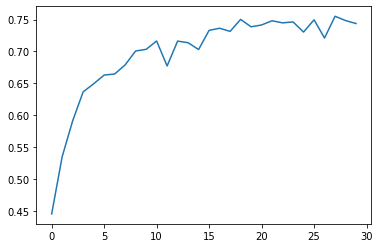

The model accuracy did not improve, patience_i =  4
-------------------------------------------------------------------------
Epoch 16 / 30 : 
Training: 
Epoch 16/16
1769/1769 [==============================] - 315s 178ms/step - loss: 0.7555 - acc: 0.8226
Validation: 
208/208 [==============================] - 36s 172ms/step - loss: 1.3358 - acc: 0.7092


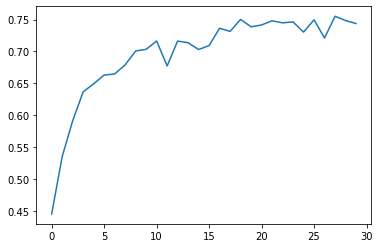

The model accuracy did not improve, patience_i =  5
-------------------------------------------------------------------------
Epoch 17 / 30 : 
Training: 
Epoch 17/17
1769/1769 [==============================] - 314s 177ms/step - loss: 0.7128 - acc: 0.8256
Validation: 
208/208 [==============================] - 35s 171ms/step - loss: 1.1056 - acc: 0.7241


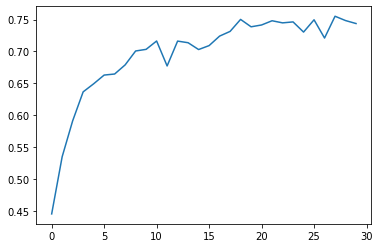

The model accuracy improved from:  0.7164336442947388 to:  0.7241016626358032
-------------------------------------------------------------------------
Epoch 18 / 30 : 
Training: 
Epoch 18/18
1769/1769 [==============================] - 314s 177ms/step - loss: 0.6971 - acc: 0.8296
Validation: 
208/208 [==============================] - 36s 172ms/step - loss: 1.1963 - acc: 0.7229


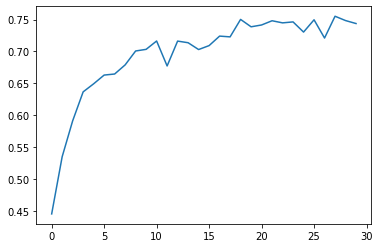

The model accuracy did not improve, patience_i =  1
-------------------------------------------------------------------------
Epoch 19 / 30 : 
Training: 
Epoch 19/19
1769/1769 [==============================] - 314s 177ms/step - loss: 0.6929 - acc: 0.8305
Validation: 
208/208 [==============================] - 67s 322ms/step - loss: 1.2081 - acc: 0.7154


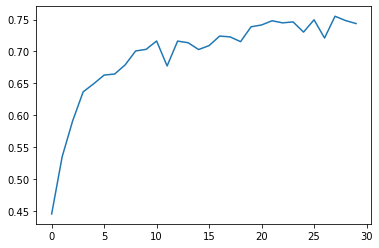

The model accuracy did not improve, patience_i =  2
-------------------------------------------------------------------------
Epoch 20 / 30 : 
Training: 
Epoch 20/20
1769/1769 [==============================] - 314s 177ms/step - loss: 0.6748 - acc: 0.8357
Validation: 
208/208 [==============================] - 36s 172ms/step - loss: 1.1950 - acc: 0.6829


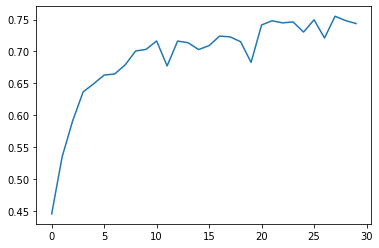

The model accuracy did not improve, patience_i =  3
-------------------------------------------------------------------------
Epoch 21 / 30 : 
Training: 
Epoch 21/21
1769/1769 [==============================] - 314s 178ms/step - loss: 0.6658 - acc: 0.8400
Validation: 
208/208 [==============================] - 36s 172ms/step - loss: 1.1147 - acc: 0.7215


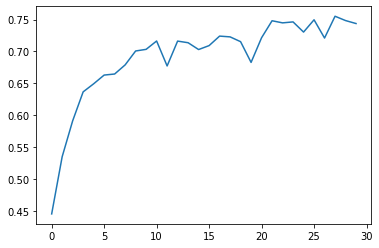

The model accuracy did not improve, patience_i =  4
-------------------------------------------------------------------------
Epoch 22 / 30 : 
Training: 
Epoch 22/22
1769/1769 [==============================] - 314s 177ms/step - loss: 0.6961 - acc: 0.8440
Validation: 
208/208 [==============================] - 36s 172ms/step - loss: 1.2960 - acc: 0.6822


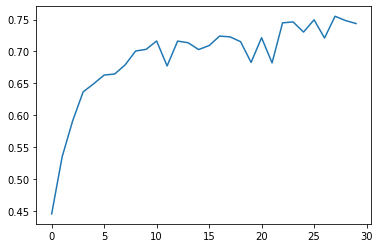

The model accuracy did not improve, patience_i =  5
-------------------------------------------------------------------------
Epoch 23 / 30 : 
Training: 
Epoch 23/23
1769/1769 [==============================] - 314s 178ms/step - loss: 0.6591 - acc: 0.8452
Validation: 
208/208 [==============================] - 35s 170ms/step - loss: 1.2648 - acc: 0.7351


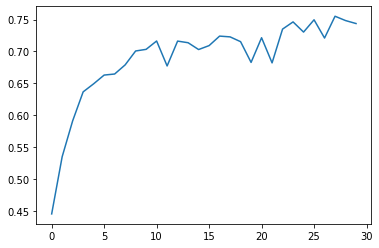

The model accuracy improved from:  0.7241016626358032 to:  0.735077440738678
-------------------------------------------------------------------------
Epoch 24 / 30 : 
Training: 
Epoch 24/24
1769/1769 [==============================] - 345s 195ms/step - loss: 0.6409 - acc: 0.8473
Validation: 
208/208 [==============================] - 36s 171ms/step - loss: 1.3090 - acc: 0.7288


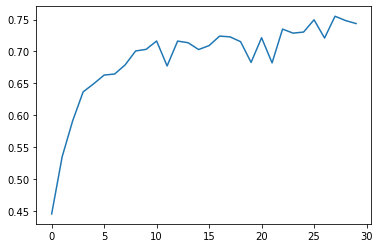

The model accuracy did not improve, patience_i =  1
-------------------------------------------------------------------------
Epoch 25 / 30 : 
Training: 
Epoch 25/25
1769/1769 [==============================] - 314s 178ms/step - loss: 0.6361 - acc: 0.8501
Validation: 
208/208 [==============================] - 36s 171ms/step - loss: 1.3587 - acc: 0.7300


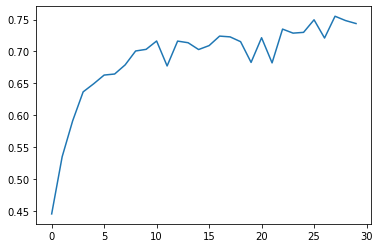

The model accuracy did not improve, patience_i =  2
-------------------------------------------------------------------------
Epoch 26 / 30 : 
Training: 
Epoch 26/26
1769/1769 [==============================] - 314s 177ms/step - loss: 0.6640 - acc: 0.8529
Validation: 
208/208 [==============================] - 36s 171ms/step - loss: 1.1381 - acc: 0.7164


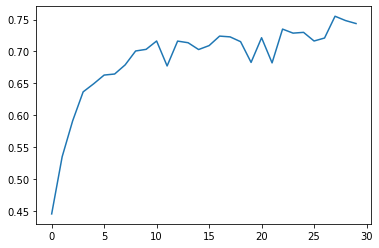

The model accuracy did not improve, patience_i =  3
-------------------------------------------------------------------------
Epoch 27 / 30 : 
Training: 
Epoch 27/27
1769/1769 [==============================] - 313s 177ms/step - loss: 0.6234 - acc: 0.8531
Validation: 
208/208 [==============================] - 35s 170ms/step - loss: 1.2184 - acc: 0.7355


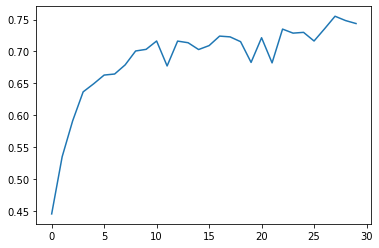

The model accuracy improved from:  0.735077440738678 to:  0.7355284690856934
-------------------------------------------------------------------------
Epoch 28 / 30 : 
Training: 
Epoch 28/28
1769/1769 [==============================] - 313s 177ms/step - loss: 0.6105 - acc: 0.8591
Validation: 
208/208 [==============================] - 35s 171ms/step - loss: 1.1288 - acc: 0.7325


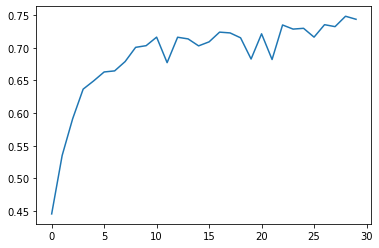

The model accuracy did not improve, patience_i =  1
-------------------------------------------------------------------------
Epoch 29 / 30 : 
Training: 
Epoch 29/29
1769/1769 [==============================] - 314s 178ms/step - loss: 0.6401 - acc: 0.8587
Validation: 
208/208 [==============================] - 36s 171ms/step - loss: 1.1086 - acc: 0.6981


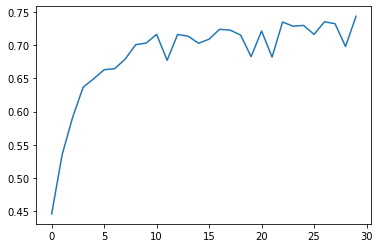

The model accuracy did not improve, patience_i =  2
-------------------------------------------------------------------------
Epoch 30 / 30 : 
Training: 
Epoch 30/30
1769/1769 [==============================] - 313s 177ms/step - loss: 0.6055 - acc: 0.8609
Validation: 
208/208 [==============================] - 35s 170ms/step - loss: 1.1782 - acc: 0.7238


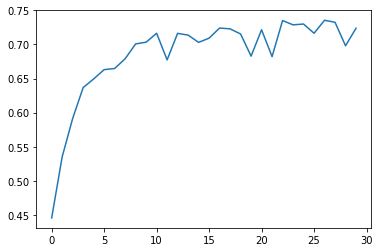

The model accuracy did not improve, patience_i =  3
-------------------------------------------------------------------------
Testing: 
105/105 [==============================] - 18s 176ms/step - loss: 1.1938 - acc: 0.7209
Test Results:  1.1937774419784546 0.7208744883537292
-------------------------------------------------------------------------
Epoch 1 / 30 : 
Training: 
1769/1769 [==============================] - 345s 195ms/step - loss: 1.8274 - acc: 0.3161
Validation: 
208/208 [==============================] - 36s 171ms/step - loss: 1.5943 - acc: 0.4160


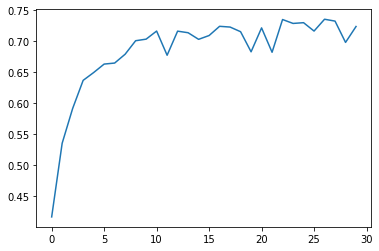

The model accuracy improved from:  0 to:  0.41602766513824463
-------------------------------------------------------------------------
Epoch 2 / 30 : 
Training: 
Epoch 2/2
1769/1769 [==============================] - 313s 177ms/step - loss: 1.4789 - acc: 0.4776
Validation: 
208/208 [==============================] - 36s 171ms/step - loss: 1.3797 - acc: 0.5210


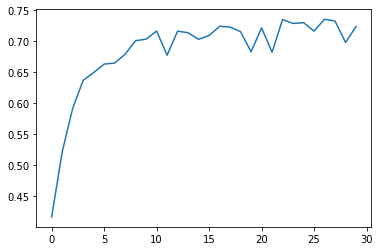

The model accuracy improved from:  0.41602766513824463 to:  0.5209742784500122
-------------------------------------------------------------------------
Epoch 3 / 30 : 
Training: 
Epoch 3/3
1769/1769 [==============================] - 314s 178ms/step - loss: 1.2756 - acc: 0.5642
Validation: 
208/208 [==============================] - 35s 171ms/step - loss: 1.2900 - acc: 0.5754


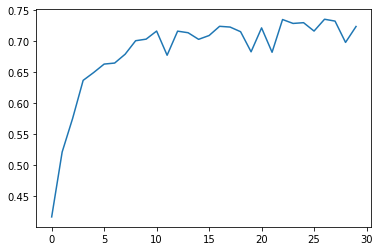

The model accuracy improved from:  0.5209742784500122 to:  0.5754022002220154
-------------------------------------------------------------------------
Epoch 4 / 30 : 
Training: 
Epoch 4/4
1769/1769 [==============================] - 313s 177ms/step - loss: 1.1806 - acc: 0.6197s - loss: 1.18
Validation: 
208/208 [==============================] - 35s 170ms/step - loss: 1.1918 - acc: 0.6195


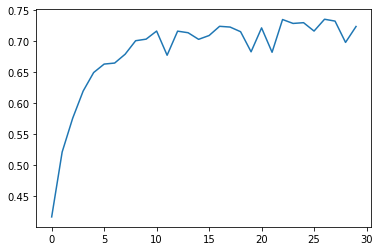

The model accuracy improved from:  0.5754022002220154 to:  0.6194556951522827
-------------------------------------------------------------------------
Epoch 5 / 30 : 
Training: 
Epoch 5/5
1769/1769 [==============================] - 314s 178ms/step - loss: 1.0629 - acc: 0.6651
Validation: 
208/208 [==============================] - 36s 172ms/step - loss: 1.1570 - acc: 0.6324


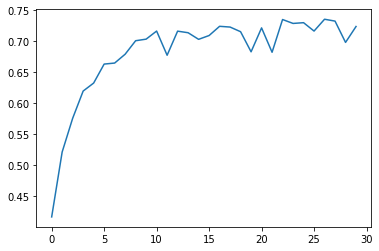

The model accuracy improved from:  0.6194556951522827 to:  0.6323860883712769
-------------------------------------------------------------------------
Epoch 6 / 30 : 
Training: 
Epoch 6/6
1769/1769 [==============================] - 313s 177ms/step - loss: 0.9958 - acc: 0.6931
Validation: 
208/208 [==============================] - 68s 325ms/step - loss: 1.1056 - acc: 0.6554


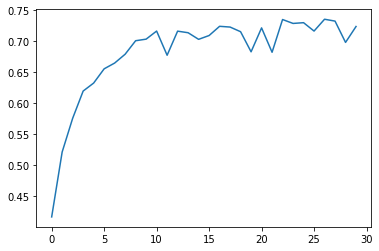

The model accuracy improved from:  0.6323860883712769 to:  0.6553901433944702
-------------------------------------------------------------------------
Epoch 7 / 30 : 
Training: 
Epoch 7/7
1769/1769 [==============================] - 345s 195ms/step - loss: 0.9298 - acc: 0.7186
Validation: 
208/208 [==============================] - 36s 172ms/step - loss: 1.0659 - acc: 0.6769


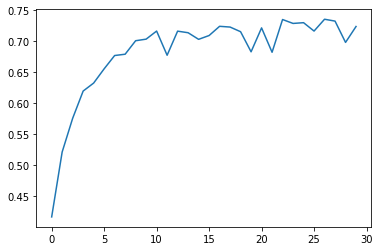

The model accuracy improved from:  0.6553901433944702 to:  0.6768906712532043
-------------------------------------------------------------------------
Epoch 8 / 30 : 
Training: 
Epoch 8/8
1769/1769 [==============================] - 315s 178ms/step - loss: 0.9056 - acc: 0.7387
Validation: 
208/208 [==============================] - 35s 171ms/step - loss: 1.1986 - acc: 0.6531


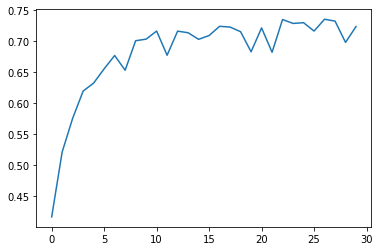

The model accuracy did not improve, patience_i =  1
-------------------------------------------------------------------------
Epoch 9 / 30 : 
Training: 
Epoch 9/9
1769/1769 [==============================] - 312s 177ms/step - loss: 0.8816 - acc: 0.7552
Validation: 
208/208 [==============================] - 36s 171ms/step - loss: 1.0801 - acc: 0.6849


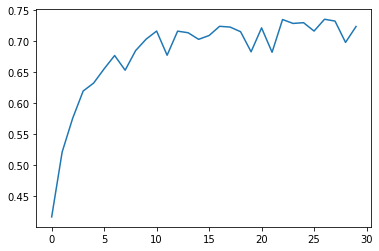

The model accuracy improved from:  0.6768906712532043 to:  0.6848593950271606
-------------------------------------------------------------------------
Epoch 10 / 30 : 
Training: 
Epoch 10/10
1769/1769 [==============================] - 313s 177ms/step - loss: 0.8079 - acc: 0.7679
Validation: 
208/208 [==============================] - 35s 169ms/step - loss: 1.1854 - acc: 0.6668


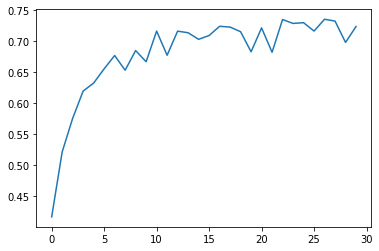

The model accuracy did not improve, patience_i =  1
-------------------------------------------------------------------------
Epoch 11 / 30 : 
Training: 
Epoch 11/11
1769/1769 [==============================] - 313s 177ms/step - loss: 0.7961 - acc: 0.7801
Validation: 
208/208 [==============================] - 36s 173ms/step - loss: 1.1419 - acc: 0.6877


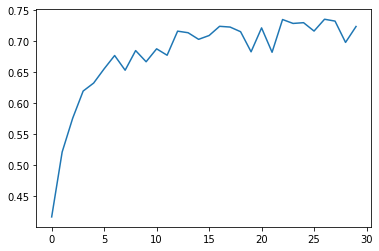

The model accuracy improved from:  0.6848593950271606 to:  0.6877161264419556
-------------------------------------------------------------------------
Epoch 12 / 30 : 
Training: 
Epoch 12/12
1769/1769 [==============================] - 314s 177ms/step - loss: 0.7574 - acc: 0.7907
Validation: 
208/208 [==============================] - 35s 171ms/step - loss: 1.1011 - acc: 0.7044


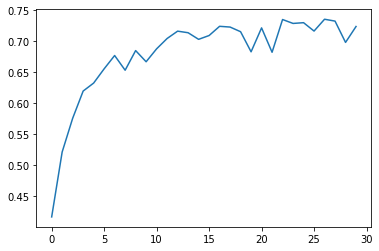

The model accuracy improved from:  0.6877161264419556 to:  0.7044053673744202
-------------------------------------------------------------------------
Epoch 13 / 30 : 
Training: 
Epoch 13/13
1769/1769 [==============================] - 315s 178ms/step - loss: 0.7395 - acc: 0.7997
Validation: 
208/208 [==============================] - 36s 172ms/step - loss: 1.1203 - acc: 0.7142


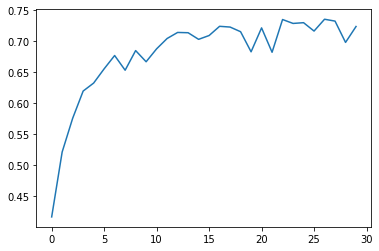

The model accuracy improved from:  0.7044053673744202 to:  0.7141783237457275
-------------------------------------------------------------------------
Epoch 14 / 30 : 
Training: 
Epoch 14/14
1769/1769 [==============================] - 315s 178ms/step - loss: 0.8082 - acc: 0.8097
Validation: 
208/208 [==============================] - 36s 171ms/step - loss: 1.0780 - acc: 0.7224


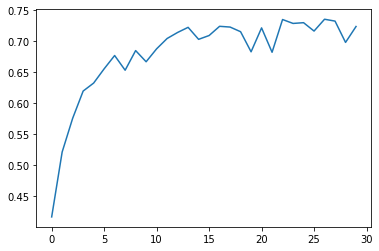

The model accuracy improved from:  0.7141783237457275 to:  0.7224477529525757
-------------------------------------------------------------------------
Epoch 15 / 30 : 
Training: 
Epoch 15/15
1769/1769 [==============================] - 315s 178ms/step - loss: 0.7103 - acc: 0.8140
Validation: 
208/208 [==============================] - 36s 173ms/step - loss: 1.1289 - acc: 0.7221


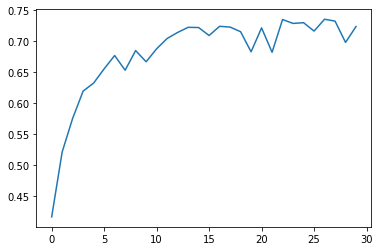

The model accuracy did not improve, patience_i =  1
-------------------------------------------------------------------------
Epoch 16 / 30 : 
Training: 
Epoch 16/16
1769/1769 [==============================] - 315s 178ms/step - loss: 0.6892 - acc: 0.8224
Validation: 
208/208 [==============================] - 35s 170ms/step - loss: 1.1383 - acc: 0.6925


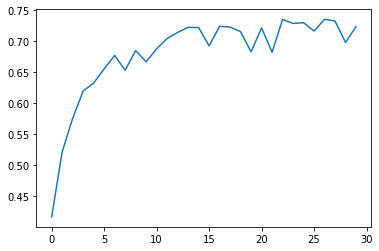

The model accuracy did not improve, patience_i =  2
-------------------------------------------------------------------------
Epoch 17 / 30 : 
Training: 
Epoch 17/17
1769/1769 [==============================] - 315s 178ms/step - loss: 0.6959 - acc: 0.8237
Validation: 
208/208 [==============================] - 36s 172ms/step - loss: 1.0588 - acc: 0.7268


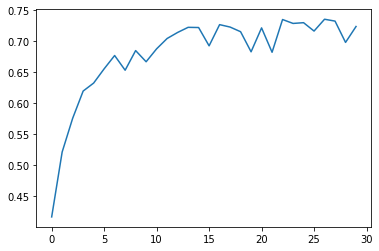

The model accuracy improved from:  0.7224477529525757 to:  0.7268080115318298
-------------------------------------------------------------------------
Epoch 18 / 30 : 
Training: 
Epoch 18/18
1769/1769 [==============================] - 316s 179ms/step - loss: 0.6840 - acc: 0.8292
Validation: 
208/208 [==============================] - 36s 171ms/step - loss: 1.1312 - acc: 0.7261


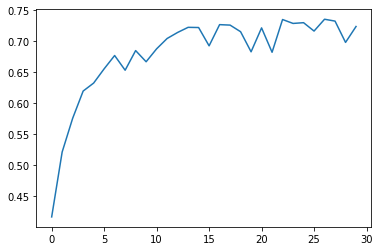

The model accuracy did not improve, patience_i =  1
-------------------------------------------------------------------------
Epoch 19 / 30 : 
Training: 
Epoch 19/19
1769/1769 [==============================] - 345s 195ms/step - loss: 0.7855 - acc: 0.8292
Validation: 
208/208 [==============================] - 36s 172ms/step - loss: 1.1896 - acc: 0.7089


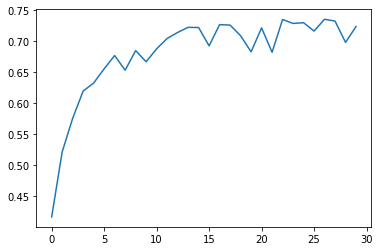

The model accuracy did not improve, patience_i =  2
-------------------------------------------------------------------------
Epoch 20 / 30 : 
Training: 
Epoch 20/20
1769/1769 [==============================] - 345s 195ms/step - loss: 0.6633 - acc: 0.8347
Validation: 
208/208 [==============================] - 35s 170ms/step - loss: 1.1298 - acc: 0.7300


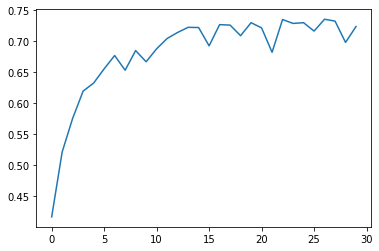

The model accuracy improved from:  0.7268080115318298 to:  0.7299654483795166
-------------------------------------------------------------------------
Epoch 21 / 30 : 
Training: 
Epoch 21/21
1769/1769 [==============================] - 345s 195ms/step - loss: 0.6451 - acc: 0.8405
Validation: 
208/208 [==============================] - 36s 171ms/step - loss: 1.1187 - acc: 0.7199


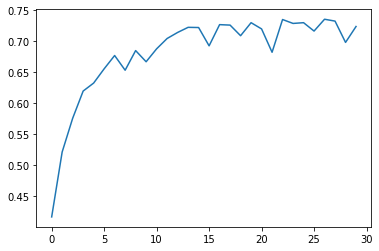

The model accuracy did not improve, patience_i =  1
-------------------------------------------------------------------------
Epoch 22 / 30 : 
Training: 
Epoch 22/22
1769/1769 [==============================] - 314s 177ms/step - loss: 0.6704 - acc: 0.8448
Validation: 
208/208 [==============================] - 35s 170ms/step - loss: 1.1251 - acc: 0.7319


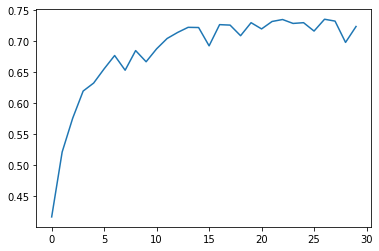

The model accuracy improved from:  0.7299654483795166 to:  0.7319200038909912
-------------------------------------------------------------------------
Epoch 23 / 30 : 
Training: 
Epoch 23/23
1769/1769 [==============================] - 313s 177ms/step - loss: 0.6495 - acc: 0.8425
Validation: 
208/208 [==============================] - 36s 171ms/step - loss: 1.3322 - acc: 0.7128


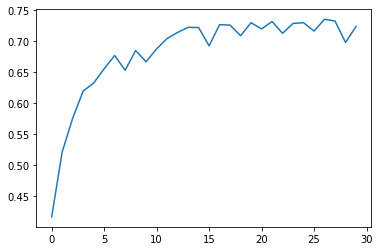

The model accuracy did not improve, patience_i =  1
-------------------------------------------------------------------------
Epoch 24 / 30 : 
Training: 
Epoch 24/24
1769/1769 [==============================] - 315s 178ms/step - loss: 0.6429 - acc: 0.8479
Validation: 
208/208 [==============================] - 36s 171ms/step - loss: 1.1316 - acc: 0.7185


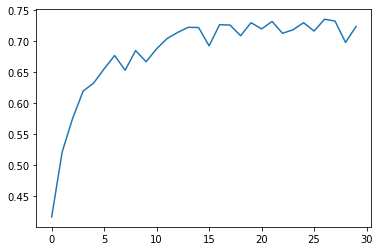

The model accuracy did not improve, patience_i =  2
-------------------------------------------------------------------------
Epoch 25 / 30 : 
Training: 
Epoch 25/25
1769/1769 [==============================] - 314s 177ms/step - loss: 0.7813 - acc: 0.8452
Validation: 
208/208 [==============================] - 36s 171ms/step - loss: 1.2677 - acc: 0.7322


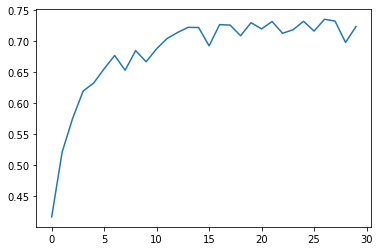

The model accuracy improved from:  0.7319200038909912 to:  0.7322207093238831
-------------------------------------------------------------------------
Epoch 26 / 30 : 
Training: 
Epoch 26/26
1769/1769 [==============================] - 314s 177ms/step - loss: 0.6433 - acc: 0.8471
Validation: 
208/208 [==============================] - 36s 171ms/step - loss: 1.1115 - acc: 0.7283


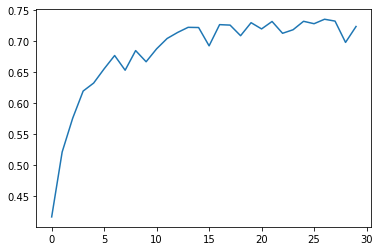

The model accuracy did not improve, patience_i =  1
-------------------------------------------------------------------------
Epoch 27 / 30 : 
Training: 
Epoch 27/27
1769/1769 [==============================] - 313s 177ms/step - loss: 0.6421 - acc: 0.8482
Validation: 
208/208 [==============================] - 36s 171ms/step - loss: 1.3014 - acc: 0.7288


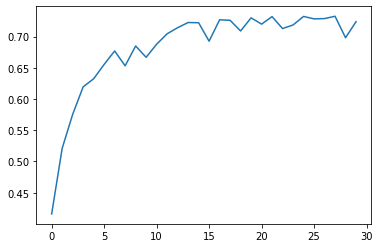

The model accuracy did not improve, patience_i =  2
-------------------------------------------------------------------------
Epoch 28 / 30 : 
Training: 
Epoch 28/28
1769/1769 [==============================] - 315s 178ms/step - loss: 0.6263 - acc: 0.8537
Validation: 
208/208 [==============================] - 35s 170ms/step - loss: 1.3541 - acc: 0.7133


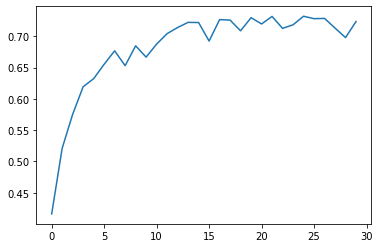

The model accuracy did not improve, patience_i =  3
-------------------------------------------------------------------------
Epoch 29 / 30 : 
Training: 
Epoch 29/29
1769/1769 [==============================] - 345s 195ms/step - loss: 0.6303 - acc: 0.8534
Validation: 
208/208 [==============================] - 36s 172ms/step - loss: 1.1967 - acc: 0.7345


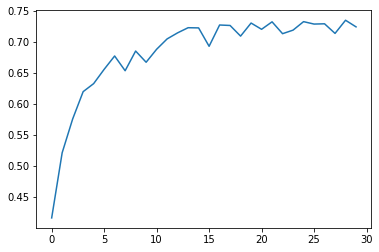

The model accuracy improved from:  0.7322207093238831 to:  0.7344760298728943
-------------------------------------------------------------------------
Epoch 30 / 30 : 
Training: 
Epoch 30/30
1769/1769 [==============================] - 314s 178ms/step - loss: 0.6201 - acc: 0.8555
Validation: 
208/208 [==============================] - 36s 171ms/step - loss: 1.1637 - acc: 0.7238


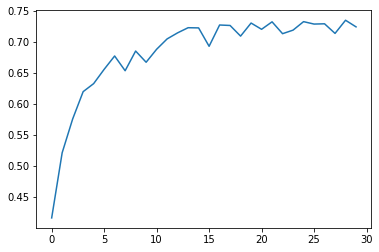

The model accuracy did not improve, patience_i =  1
-------------------------------------------------------------------------
Testing: 
105/105 [==============================] - 18s 175ms/step - loss: 1.2226 - acc: 0.7125
Test Results:  1.2226215600967407 0.7124887704849243
-------------------------------------------------------------------------
Epoch 1 / 30 : 
Training: 
1769/1769 [==============================] - 314s 177ms/step - loss: 1.8043 - acc: 0.3261
Validation: 
208/208 [==============================] - 36s 172ms/step - loss: 1.5888 - acc: 0.4132


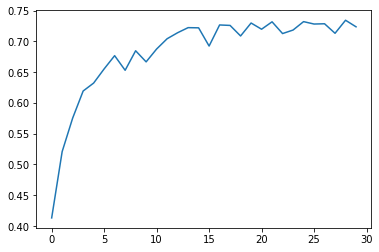

The model accuracy improved from:  0 to:  0.4131709635257721
-------------------------------------------------------------------------
Epoch 2 / 30 : 
Training: 
Epoch 2/2
1769/1769 [==============================] - 315s 178ms/step - loss: 1.4459 - acc: 0.4942
Validation: 
208/208 [==============================] - 35s 170ms/step - loss: 1.3939 - acc: 0.5405


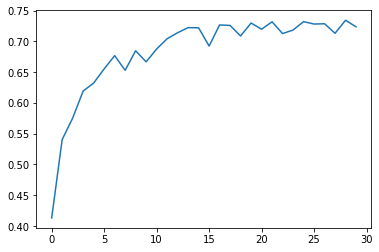

The model accuracy improved from:  0.4131709635257721 to:  0.5405202507972717
-------------------------------------------------------------------------
Epoch 3 / 30 : 
Training: 
Epoch 3/3
1769/1769 [==============================] - 314s 178ms/step - loss: 1.2716 - acc: 0.5817
Validation: 
208/208 [==============================] - 36s 171ms/step - loss: 1.2239 - acc: 0.5943


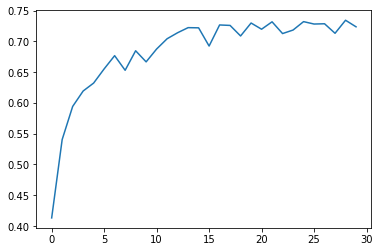

The model accuracy improved from:  0.5405202507972717 to:  0.5943467020988464
-------------------------------------------------------------------------
Epoch 4 / 30 : 
Training: 
Epoch 4/4
1769/1769 [==============================] - 316s 178ms/step - loss: 1.1244 - acc: 0.6426
Validation: 
208/208 [==============================] - 36s 171ms/step - loss: 1.1365 - acc: 0.6370


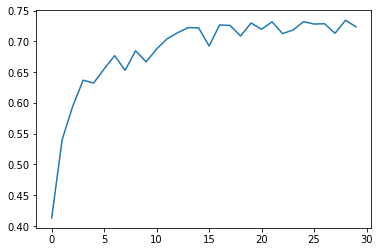

The model accuracy improved from:  0.5943467020988464 to:  0.6370470523834229
-------------------------------------------------------------------------
Epoch 5 / 30 : 
Training: 
Epoch 5/5
1769/1769 [==============================] - 313s 177ms/step - loss: 1.0401 - acc: 0.6811
Validation: 
208/208 [==============================] - 35s 171ms/step - loss: 1.1273 - acc: 0.6521


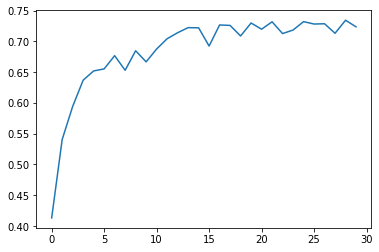

The model accuracy improved from:  0.6370470523834229 to:  0.6520823836326599
-------------------------------------------------------------------------
Epoch 6 / 30 : 
Training: 
Epoch 6/6
1769/1769 [==============================] - 315s 178ms/step - loss: 0.9430 - acc: 0.7132
Validation: 
208/208 [==============================] - 35s 170ms/step - loss: 1.0785 - acc: 0.6785


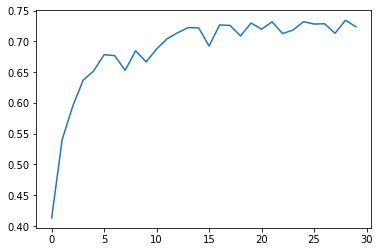

The model accuracy improved from:  0.6520823836326599 to:  0.6785445809364319
-------------------------------------------------------------------------
Epoch 7 / 30 : 
Training: 
Epoch 7/7
1769/1769 [==============================] - 315s 178ms/step - loss: 0.8832 - acc: 0.7376
Validation: 
208/208 [==============================] - 36s 171ms/step - loss: 1.0806 - acc: 0.6891


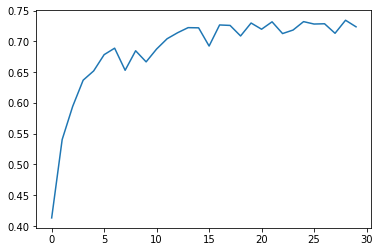

The model accuracy improved from:  0.6785445809364319 to:  0.6890693306922913
-------------------------------------------------------------------------
Epoch 8 / 30 : 
Training: 
Epoch 8/8
1769/1769 [==============================] - 315s 178ms/step - loss: 0.8241 - acc: 0.7602
Validation: 
208/208 [==============================] - 36s 171ms/step - loss: 1.0799 - acc: 0.6931


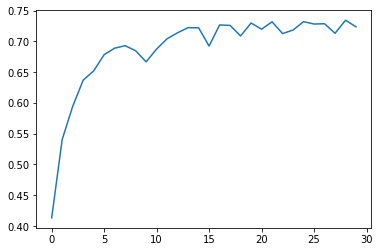

The model accuracy improved from:  0.6890693306922913 to:  0.6931288242340088
-------------------------------------------------------------------------
Epoch 9 / 30 : 
Training: 
Epoch 9/9
1769/1769 [==============================] - 314s 178ms/step - loss: 0.7839 - acc: 0.7774
Validation: 
208/208 [==============================] - 35s 170ms/step - loss: 1.1083 - acc: 0.6852


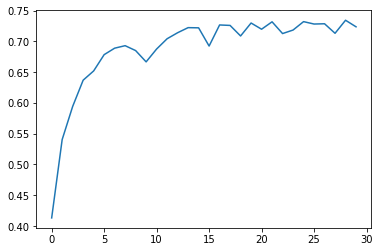

The model accuracy did not improve, patience_i =  1
-------------------------------------------------------------------------
Epoch 10 / 30 : 
Training: 
Epoch 10/10
1769/1769 [==============================] - 312s 176ms/step - loss: 0.7417 - acc: 0.7929
Validation: 
208/208 [==============================] - 35s 170ms/step - loss: 1.0740 - acc: 0.6972


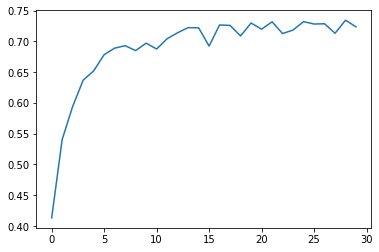

The model accuracy improved from:  0.6931288242340088 to:  0.6971883773803711
-------------------------------------------------------------------------
Epoch 11 / 30 : 
Training: 
Epoch 11/11
1769/1769 [==============================] - 314s 177ms/step - loss: 0.7081 - acc: 0.8042
Validation: 
208/208 [==============================] - 36s 171ms/step - loss: 1.1231 - acc: 0.7133


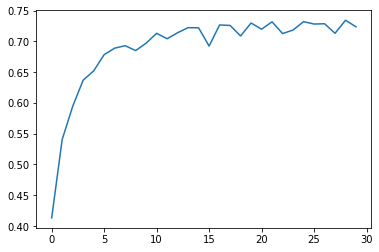

The model accuracy improved from:  0.6971883773803711 to:  0.713276207447052
-------------------------------------------------------------------------
Epoch 12 / 30 : 
Training: 
Epoch 12/12
1769/1769 [==============================] - 314s 177ms/step - loss: 0.6827 - acc: 0.8161
Validation: 
208/208 [==============================] - 35s 170ms/step - loss: 1.1720 - acc: 0.7106


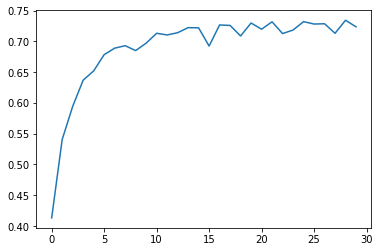

The model accuracy did not improve, patience_i =  1
-------------------------------------------------------------------------
Epoch 13 / 30 : 
Training: 
Epoch 13/13
1769/1769 [==============================] - 346s 195ms/step - loss: 0.6689 - acc: 0.8268
Validation: 
208/208 [==============================] - 36s 172ms/step - loss: 1.1937 - acc: 0.7157


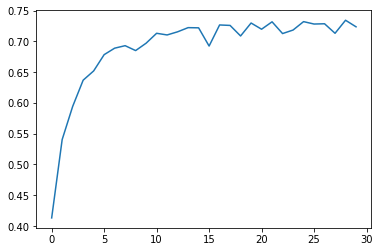

The model accuracy improved from:  0.713276207447052 to:  0.7156818509101868
-------------------------------------------------------------------------
Epoch 14 / 30 : 
Training: 
Epoch 14/14
1769/1769 [==============================] - 315s 178ms/step - loss: 0.6624 - acc: 0.8336
Validation: 
208/208 [==============================] - 36s 171ms/step - loss: 1.1296 - acc: 0.7264


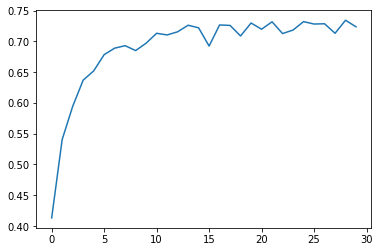

The model accuracy improved from:  0.7156818509101868 to:  0.7263569235801697
-------------------------------------------------------------------------
Epoch 15 / 30 : 
Training: 
Epoch 15/15
1769/1769 [==============================] - 314s 178ms/step - loss: 0.6352 - acc: 0.8402
Validation: 
208/208 [==============================] - 36s 172ms/step - loss: 1.0592 - acc: 0.7233


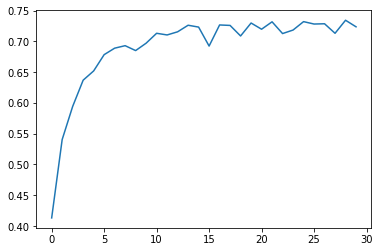

The model accuracy did not improve, patience_i =  1
-------------------------------------------------------------------------
Epoch 16 / 30 : 
Training: 
Epoch 16/16
1769/1769 [==============================] - 314s 178ms/step - loss: 0.6185 - acc: 0.8448
Validation: 
208/208 [==============================] - 35s 170ms/step - loss: 1.2542 - acc: 0.7267


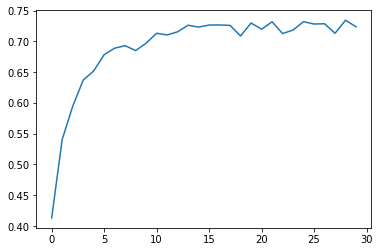

The model accuracy improved from:  0.7263569235801697 to:  0.7266576290130615
-------------------------------------------------------------------------
Epoch 17 / 30 : 
Training: 
Epoch 17/17
1769/1769 [==============================] - 315s 178ms/step - loss: 0.5970 - acc: 0.8494
Validation: 
208/208 [==============================] - 36s 172ms/step - loss: 1.1902 - acc: 0.7355


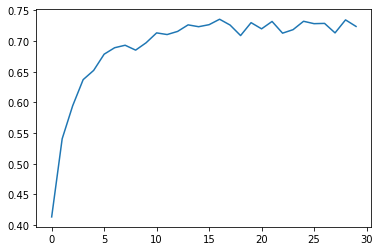

The model accuracy improved from:  0.7266576290130615 to:  0.7355284690856934
-------------------------------------------------------------------------
Epoch 18 / 30 : 
Training: 
Epoch 18/18
1769/1769 [==============================] - 314s 178ms/step - loss: 0.5992 - acc: 0.8562
Validation: 
208/208 [==============================] - 36s 172ms/step - loss: 1.4617 - acc: 0.7208


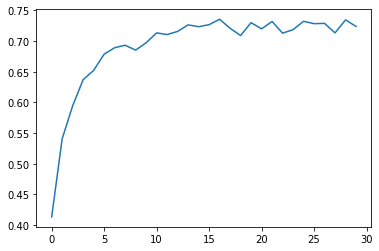

The model accuracy did not improve, patience_i =  1
-------------------------------------------------------------------------
Epoch 19 / 30 : 
Training: 
Epoch 19/19
1769/1769 [==============================] - 315s 178ms/step - loss: 0.5988 - acc: 0.8559
Validation: 
208/208 [==============================] - 36s 172ms/step - loss: 1.2468 - acc: 0.7188


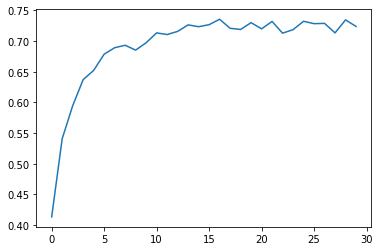

The model accuracy did not improve, patience_i =  2
-------------------------------------------------------------------------
Epoch 20 / 30 : 
Training: 
Epoch 20/20
1769/1769 [==============================] - 315s 178ms/step - loss: 0.5760 - acc: 0.8610
Validation: 
208/208 [==============================] - 35s 171ms/step - loss: 1.1486 - acc: 0.7280


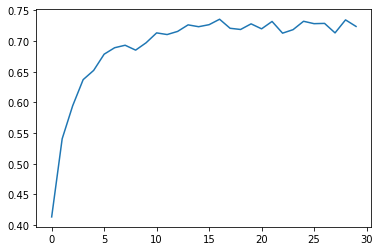

The model accuracy did not improve, patience_i =  3
-------------------------------------------------------------------------
Epoch 21 / 30 : 
Training: 
Epoch 21/21
1769/1769 [==============================] - 315s 178ms/step - loss: 0.5794 - acc: 0.8650
Validation: 
208/208 [==============================] - 36s 173ms/step - loss: 1.1837 - acc: 0.7388


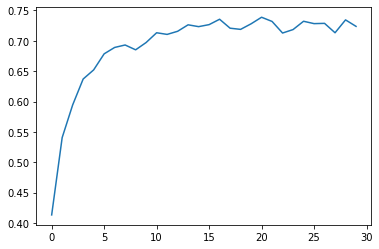

The model accuracy improved from:  0.7355284690856934 to:  0.7388362884521484
-------------------------------------------------------------------------
Epoch 22 / 30 : 
Training: 
Epoch 22/22
1769/1769 [==============================] - 314s 178ms/step - loss: 0.5771 - acc: 0.8642
Validation: 
208/208 [==============================] - 36s 171ms/step - loss: 1.2793 - acc: 0.7378


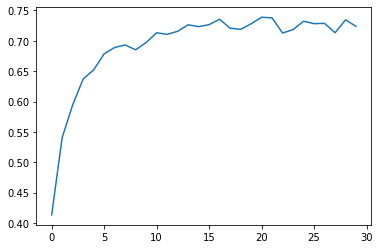

The model accuracy did not improve, patience_i =  1
-------------------------------------------------------------------------
Epoch 23 / 30 : 
Training: 
Epoch 23/23
1769/1769 [==============================] - 315s 178ms/step - loss: 0.5820 - acc: 0.8674
Validation: 
208/208 [==============================] - 36s 172ms/step - loss: 1.2140 - acc: 0.7352


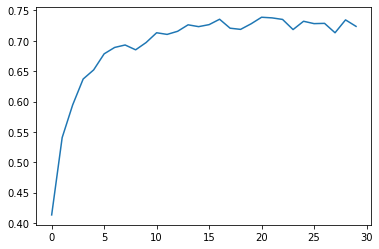

The model accuracy did not improve, patience_i =  2
-------------------------------------------------------------------------
Epoch 24 / 30 : 
Training: 
Epoch 24/24
1769/1769 [==============================] - 314s 178ms/step - loss: 0.5670 - acc: 0.8689
Validation: 
208/208 [==============================] - 35s 170ms/step - loss: 1.3578 - acc: 0.7393


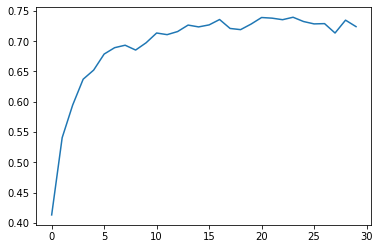

The model accuracy improved from:  0.7388362884521484 to:  0.7392873167991638
-------------------------------------------------------------------------
Epoch 25 / 30 : 
Training: 
Epoch 25/25
1769/1769 [==============================] - 315s 178ms/step - loss: 0.5595 - acc: 0.8696
Validation: 
208/208 [==============================] - 36s 172ms/step - loss: 1.1780 - acc: 0.7370


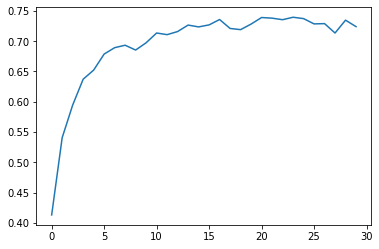

The model accuracy did not improve, patience_i =  1
-------------------------------------------------------------------------
Epoch 26 / 30 : 
Training: 
Epoch 26/26
1769/1769 [==============================] - 314s 178ms/step - loss: 0.5897 - acc: 0.8714
Validation: 
208/208 [==============================] - 36s 171ms/step - loss: 1.2664 - acc: 0.7438


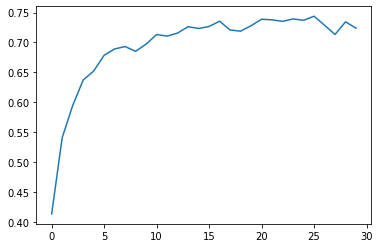

The model accuracy improved from:  0.7392873167991638 to:  0.7437978982925415
-------------------------------------------------------------------------
Epoch 27 / 30 : 
Training: 
Epoch 27/27
1769/1769 [==============================] - 314s 178ms/step - loss: 0.5585 - acc: 0.8756
Validation: 
208/208 [==============================] - 36s 171ms/step - loss: 1.1658 - acc: 0.7283


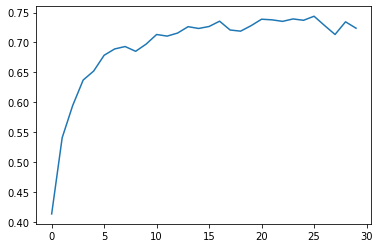

The model accuracy did not improve, patience_i =  1
-------------------------------------------------------------------------
Epoch 28 / 30 : 
Training: 
Epoch 28/28
1769/1769 [==============================] - 314s 178ms/step - loss: 0.6363 - acc: 0.8737
Validation: 
208/208 [==============================] - 35s 170ms/step - loss: 1.2668 - acc: 0.7429


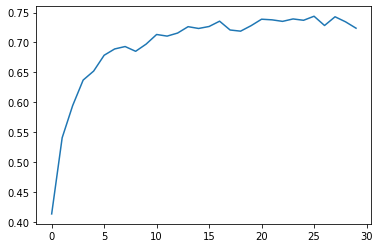

The model accuracy did not improve, patience_i =  2
-------------------------------------------------------------------------
Epoch 29 / 30 : 
Training: 
Epoch 29/29
1769/1769 [==============================] - 314s 178ms/step - loss: 0.5540 - acc: 0.8737
Validation: 
208/208 [==============================] - 36s 172ms/step - loss: 1.2392 - acc: 0.7379


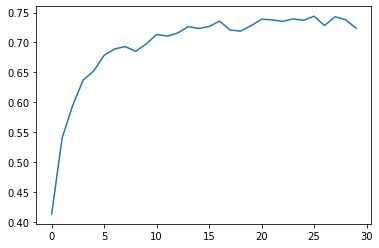

The model accuracy did not improve, patience_i =  3
-------------------------------------------------------------------------
Epoch 30 / 30 : 
Training: 
Epoch 30/30
1769/1769 [==============================] - 344s 195ms/step - loss: 0.5641 - acc: 0.8754
Validation: 
208/208 [==============================] - 35s 170ms/step - loss: 1.3505 - acc: 0.7402


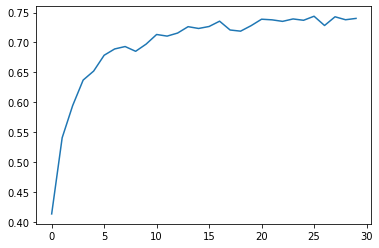

The model accuracy did not improve, patience_i =  4
-------------------------------------------------------------------------
Testing: 
105/105 [==============================] - 18s 174ms/step - loss: 1.3323 - acc: 0.7344
Test Results:  1.332275629043579 0.7343515753746033


In [15]:
training_history = np.zeros(shape=(2,epochs))
validation_history = np.zeros(shape=(2,epochs))
test_history = [0,0]
#print(model.metrics_names)

NoBeamsTest = [15, 10, 6, 3, 1]
NoTests = 3

for i in NoBeamsTest:
    for j in range(0, NoTests):
        use_index = np.arange(i, dtype = np.int)
        input_shape = (i, 128, 128)
        model = BuildModel(input_shape)
        felix_fit_new(model, batch_size, epochs, CPUworkers, [EarlyStop, Checkpoint], AllPaths, "npy", training_history, validation_history, TrainingPatience, test_history, "acc", use_index)

In [ ]:
1.3018012046813965 0.7613058090209961
1.05343759059906 0.7586103677749634
1.330857515335083 0.7508236169815063
1.1092171669006348 0.7229709625244141
1.2589836120605469 0.7187780737876892



15
0.9739919900894165 0.7337526082992554
1.3477684259414673 0.7361485362052917
1.2320550680160522 0.75262051820755

10
1.0369402170181274 0.7643007040023804
1.198324203491211 0.7705900073051453
1.1639018058776855 0.7589098811149597

6
1.0559215545654297 0.7478286623954773
1.206514596939087 0.7616052627563477
1.3701927661895752 0.7577118873596191

3
1.3629850149154663 0.7547169923782349
1.289128303527832 0.7409403920173645
1.21724271774292 0.7352500557899475

1
1.1937774419784546 0.7208744883537292
1.2589836120605469 0.7187780737876892
1.07 70.6

In [43]:
model.save(NewPath+ModelName)
np.save(NewPath+"/training_history.npy", training_history)
np.save(NewPath+"/validation_history.npy", validation_history)